EM27 Ratios
============
This notebook uses data processed by Data_Setup.ipynb to calculate ratios of the EM27 data and create manuscript figures. Paths may need to be altered to match local setup. This notebook was built to create the analysis and figures for the Meyer 2025 paper (https://doi.org/10.1029/2025JD044398).  

# Setup

In [1]:
#Import Packages
import sys
import pickle
import seaborn as sns
import os
import scipy
import json
import pytz
import datetime
import string
import itertools
import statsmodels.api as sm
import scipy.stats as stats
import pylab
import copy
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker                        
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.legend as mlegend
from matplotlib.colors import Normalize
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cartopy.crs as ccrs
from joblib import Parallel, delayed
import cartopy.io.img_tiles as cimgt
import xarray as xr
from pylr2 import regress2
import warnings

sys.path.append('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/')
from atmos.utils import met_utils, datetime_utils, plot_utils, regression_utils, df_utils, ac_utils

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [2]:
#Define the paths
project_path = '/uufs/chpc.utah.edu/common/home/u0890904/public_html/Projects/SLV_EM27_2025'
project_figures_path = os.path.join(project_path,'Figures')
project_data_path = os.path.join(project_path,'Data')

In [3]:
#Load data from Data_Setup
inst_ids = ['ha','ua']

oof_df_concat = pd.read_parquet(os.path.join(project_data_path, 'corr_oof_df_concat.parquet'))
oof_dfs = df_utils.get_dict_from_df(oof_df_concat, key_col = 'key', index_col = 'dt')

surface_ak_df_concat = pd.read_parquet(os.path.join(project_data_path, 'surface_ak_df_concat.parquet'))
surface_ak_dfs = df_utils.get_dict_from_df(surface_ak_df_concat, key_col = 'key', index_col = 'dt')
for ak_df in surface_ak_dfs.values():
    ak_df.rename(columns={f'{gas}_surf_ak':f'{gas}(ppm)_surf_ak' for gas in ['xco','xco2','xch4']},inplace=True)

met_dfs_concat = pd.read_parquet(os.path.join(project_data_path, 'met_dfs_concat.parquet'))
met_dfs = df_utils.get_dict_from_df(met_dfs_concat, key_col = 'key', index_col = 'dt')

with open(os.path.join(project_data_path, 'smoke_outliers.json'), 'rb') as f:
    smoke_outliers = json.load(f)
smoke_outlier_dates = pd.to_datetime(smoke_outliers["max"]).date

## Define Functions

In [4]:
# Extra EM27 Dataframe Functions not yet moved to atmos

def merge_ak(df, ak_df, resample_freq, resample_kwargs = {'label':'right','closed':'right'}):
    """
    Resample averaging kernel data and merge it with the resampled DataFrame.

    Args:
        df: Resampled DataFrame with computed statistics.
        ak_df: DataFrame containing averaging kernel information.
        resample_freq: Str, resampling frequency.
        resample_kwargs: Additional keyword arguments for resampling.
        
    Returns:
        Merged DataFrame with averaging kernel data included.
    """
    ak_resampled = ak_df.resample(resample_freq, **resample_kwargs).mean()
    return df.merge(ak_resampled, left_index=True, right_index=True, how='left')


def aggregate_full_df(df, ak_df, resample_freq, col_names, err_col_names = None, resample_with_stats_kwargs = {}):
    """
    Resample the DataFrame and compute statistics for specified columns.

    Args:
        df: DataFrame to be resampled.
        ak_df: DataFrame containing averaging kernel information.
        resample_freq: Str, resampling frequency.
        col_names: List of column names to compute statistics for.
        err_col_names: List of error column names (optional).
        resample_with_stats_kwargs: Additional keyword arguments for resampling.

    Returns:
        DataFrame with resampled statistics.
    """

    working_df = df.copy()
    if err_col_names is None:
        err_col_names = [f'{col}_error' for col in col_names]
    if len(col_names) != len(err_col_names):
        raise ValueError('col_names and err_col_names must be the same length')

    # Resample the DataFrame and compute statistics for each column
    agg_dfs = [] 
    for col_name, err_col_name in zip(col_names, err_col_names):
        agg_df = df_utils.resample_with_stats(working_df, col_name, err_col_name, resample_freq, **resample_with_stats_kwargs)
        agg_dfs.append(agg_df)

    agg_df_full = pd.concat(agg_dfs, axis=1)

    # Include numeric columns not in col_names, eunsruing they are numeric
    other_col_names = [col for col in df.select_dtypes(include='number').columns if col not in col_names and col not in err_col_names]
    if other_col_names:
        for other_col_name in other_col_names:
            other_agg_mean = df_utils.resample_with_stats(working_df, other_col_name, None, resample_freq, **resample_with_stats_kwargs)
            agg_df_full = pd.concat([agg_df_full, other_agg_mean], axis=1)

    # Add averaging kernel data if provided
    if ak_df is not None:
        agg_df_full = merge_ak(agg_df_full, ak_df, resample_freq)

    return agg_df_full

def resample_and_get_excess(df,ak_df,resample_freq,gases,quantile,resample_with_stats_kwargs = {}):
    """
    Resample the DataFrame and compute excess values for specified gases.

    Args:
        df: DataFrame to be resampled.
        ak_df: DataFrame containing averaging kernel information.
        resample_freq: Str, resampling frequency.
        gases: List of gas names to compute excess values for.
        quantile: Float, quantile value for excess calculation.
        resample_with_stats_kwargs: Additional keyword arguments for resampling.

    Returns:
        DataFrame with excess values for specified gases.
        col_quantiles: Dictionary of quantile values for each gas.
    """

    out_df = df.copy()
    aggregate_df = aggregate_full_df(out_df,ak_df, resample_freq, gases, resample_with_stats_kwargs = resample_with_stats_kwargs) # resample the data
    quantile_gas_names = [f'{gas}_wmean' for gas in gases] # get the gas names for the quantile calculation
    quantile_df,col_quantiles = df_utils.subtract_quantile(aggregate_df, quantile_gas_names,quantile) #subtract the quantile

    # Divide by the averaging kernel for each gas
    for gas in gases:
        ak_col_name = f'{gas}_surf_ak'
        for col in quantile_df.columns:
            if col.startswith(gas) and not col.endswith('surf_ak'):
                quantile_df = ac_utils.div_by_ak(quantile_df,col,ak_col_name)

    return quantile_df, col_quantiles

def build_anom(day_oof_df,ak_df,gases,sza_bin_size,co2_thresh):
    """Build daily anomaly and skipped DataFrames.
    Args:
        day_oof_df: DataFrame containing daily OOF data.
        ak_df: DataFrame containing averaging kernel information.
        gases: List of gas names to compute anomalies for.
        sza_bin_size: Float, size of the solar zenith angle bins.
        co2_thresh: Float, CO2 threshold for anomaly calculation.

    Returns:
        anom_df: DataFrame containing daily anomalies.
        skipped_df: DataFrame containing skipped rows.
    """

    if len(day_oof_df.dropna()) == 0:
        return None, None
    binned_summary_df = ac_utils.create_binned_summary(day_oof_df,ak_df,sza_bin_size,gases)
    anom_df, skipped_df = ac_utils.daily_anomaly_creator(binned_summary_df,gases,co2_thresh) #get the anomaly and skipped rows dataframes 
    date = day_oof_df.index[0].date() #get the date 
    anom_df['date'] = date #add date columns to each of the dataframes
    skipped_df['date'] = date

    return anom_df, skipped_df    

def get_day_dfs(daily_oof_dict,daily_met_dict,ak_df,date_str,gases,oof_resample,oof_background_quantile,oof_filter_dict = None,resample_with_stats_kwargs = {}):
    """Get daily DataFrames for a specific date.

    Args:
        daily_oof_dict: Dictionary of daily OOF DataFrames.
        daily_met_dict: Dictionary of daily MET DataFrames.
        ak_df: DataFrame containing averaging kernel information.
        date_str: Str, date string in 'YYYY-MM-DD' format.
        gases: List of gas names to compute excess values for.
        oof_resample: Str, resampling frequency for OOF data.
        oof_background_quantile: Float, quantile value for excess calculation.
        oof_filter_dict: Dictionary of filters to apply to OOF data (optional).
        resample_with_stats_kwargs: Additional keyword arguments for resampling.
    Returns:
        day_dfs: Dictionary containing daily DataFrames for OOF, MET, and quantile data.
    """
    
    oof_df = daily_oof_dict[date_str].copy()
    met_df = daily_met_dict[date_str].copy()
    if oof_filter_dict is not None: #apply the filters to the oof_df
        oof_df = df_utils.apply_filters(oof_df, oof_filter_dict)

    if len(oof_df) == 0: #check if the oof_df is empty after filtering
        print(f'No data after filter for {date_str}')
        return None
    q = int(oof_background_quantile*100) 

    #resample the oof_df 
    quantile_df, col_quantiles = resample_and_get_excess(oof_df,ak_df,oof_resample,gases,oof_background_quantile,resample_with_stats_kwargs = resample_with_stats_kwargs)
    
    if len(quantile_df.dropna()) == 0:
        print(f'No quantile data {date_str}')
        return None
    
    day_dfs = {
        'date_str':date_str,
        'oof_df':oof_df,
        'quantile_df':quantile_df,
        'met_df':met_df,
        'col_quantiles':col_quantiles
    }
    return day_dfs

In [5]:
# Rolling Ratio Functions
def get_regressions(df,regr_params,regr_type,keep_outputs):
    """
    Perform full regression analysis on a DataFrame.

    Args:
        df: DataFrame to perform regression on.
        regr_params: Dictionary containing regression parameters.
        regr_type: Str, type of regression to perform ('york', 'odr', 'ols', 'rma').
        keep_outputs: List of regression output keys to keep.

    Returns:    
        regr_outputs: Dictionary containing regression results.
    """

    working_df = df.copy()
    regr_outputs = {}
    for regr_label,xy in regr_params['regr_labels'].items():
        regr_outputs[regr_label] = {}
        x_name = xy['x_name']
        y_name = xy['y_name']
        x_err_name = xy['x_err_name']
        y_err_name = xy['y_err_name']
        if regr_type == 'york': #if the regression type is york, use the york regression function
            regr_output = regression_utils.york_regression(working_df,x_name,y_name,x_err_name,y_err_name)
        elif regr_type == 'odr':
            regr_output = regression_utils.odr_regression(working_df,x_name,y_name,x_err_name,y_err_name,odr_kwargs={'beta0': (0.007, 0)},out_keychange={'res_var': 'chi_squared'})
        elif regr_type == 'ols':
            regr_output = regression_utils.ols_regression(working_df,x_name,y_name)
        elif regr_type == 'rma':
            regr_output = regression_utils.rma_regression(working_df,x_name,y_name)
        else:
            raise ValueError(f"Unsupported regression type: {regr_type}")
        for key in regr_output.keys():
            if key in keep_outputs:
                regr_outputs[regr_label][key] = regr_output[key]
    return regr_outputs

def flatten_regr_dict(d, regr_type,sep='_'):
    """
    Flatten a nested dictionary of regression results.

    Args:
        d: Nested dictionary of regression results.
        regr_type: Str, type of regression.
        sep: Str, separator for flattening keys.

    Returns:
        flat_dict: Flattened dictionary of regression results.  
    """

    items = []
    for regr_label, regr_dict in d.items():
        for k, v in regr_dict.items():
            new_key = f"{regr_label}{sep}{regr_type}{sep}{k}"
            items.append((new_key, v))
    return dict(items)


def rolling_regression_creator(df, regr_params, rolling_window, regr_resample=None,
                                        resample_eq_or_all='eq',
                                        n_jobs=-1):
    """
    Parallelized rolling regression computation that produces deterministic results.

    Args:
        df: pandas DataFrame with DatetimeIndex
        regr_params: dict, regression parameters and labels
        regr_resample: str, optional resample frequency
        resample_eq_or_all: 'eq' or 'all', determines which data to use after resampling
        min_obs_per_window: int, minimum observations per window
        n_jobs: int, number of parallel jobs (-1 = all cores)

    Returns:
        rolling_regr_df: DataFrame containing rolling regression results
    """
    df = df.sort_index()

    # Resample if needed
    if regr_resample is None:
        resampled_regr_df = df_for_regression = df
    else:
        resampled = df.resample(regr_resample).mean(numeric_only=True).dropna()
        resampled_regr_df = resampled
        df_for_regression = resampled if resample_eq_or_all == 'eq' else df


    # Only pass necessary columns to workers
    needed_cols = []
    for xy in regr_params['regr_labels'].values():
        needed_cols += [xy['x_name'], xy['y_name'], xy['x_err_name'], xy['y_err_name']]
    needed_cols = list(set(needed_cols))  # unique columns
    df_for_regression = df_for_regression[needed_cols].copy()
    resampled_regr_df = resampled_regr_df[needed_cols].copy()


    def safe_loc(df, idx, col):
        """Robust lookup for tz-aware timestamps"""
        pos = df.index.get_indexer([idx])[0]
        if pos == -1:
            return None
        return df.iloc[pos][col]

    def compute_window(dt):
        """Compute one rolling window"""

        window_df = get_window_df(df_for_regression, dt, rolling_window, 'before')
        window_nobs = len(window_df.dropna())
        result = {'dt': dt, 'window_nobs': window_nobs}

        if window_nobs <= 1:
            return result

        for regr_label, xy in regr_params['regr_labels'].items():
            x_name, y_name = xy['x_name'], xy['y_name']
            x_err_name, y_err_name = xy['x_err_name'], xy['y_err_name']

            x_vals = window_df[x_name]
            y_vals = window_df[y_name]

            # Basic stats
            x_min, x_max = x_vals.min(), x_vals.max()
            y_min, y_max = y_vals.min(), y_vals.max()
            x_mean, y_mean = x_vals.mean(), y_vals.mean()
            x_std, y_std = x_vals.std(), y_vals.std()
            x_range, y_range = x_max - x_min, y_max - y_min

            # Time differences
            x_time_diff = safe_time_diff(window_df,x_name)# (x_vals.idxmax() - x_vals.idxmin()).total_seconds() if len(x_vals) > 1 else None
            y_time_diff = safe_time_diff(window_df,x_name)#(y_vals.idxmax() - y_vals.idxmin()).total_seconds() if len(y_vals) > 1 else None

            # Current values at dt
            current_values = {
                f'{x_name}': safe_loc(resampled_regr_df, dt, x_name),
                f'{y_name}': safe_loc(resampled_regr_df, dt, y_name),
                f'{x_err_name}': safe_loc(resampled_regr_df, dt, x_err_name),
                f'{y_err_name}': safe_loc(resampled_regr_df, dt, y_err_name),
            }

            stats = {
                f'{x_name}_mean': x_mean, f'{y_name}_mean': y_mean,
                f'{x_name}_std': x_std, f'{y_name}_std': y_std,
                f'{x_name}_min': x_min, f'{y_name}_min': y_min,
                f'{x_name}_max': x_max, f'{y_name}_max': y_max,
                f'{x_name}_range': x_range, f'{y_name}_range': y_range,
                f'{x_name}_time_diff': x_time_diff, f'{y_name}_time_diff': y_time_diff,
            }

            result.update(stats)
            result.update(current_values)

        # Regressions 
        for regr_type, keep_outputs in regr_params['regr_type_details'].items():
            window_regr_out = get_regressions(window_df, regr_params, regr_type, keep_outputs)
            result.update(flatten_regr_dict(window_regr_out, regr_type))

        return result


    #Run parallel
    rolling_results = Parallel(n_jobs=n_jobs)(
        delayed(compute_window)(dt) for dt in resampled_regr_df.index
    )


    rolling_regr_df = pd.DataFrame(rolling_results).set_index('dt').sort_index()
    return rolling_regr_df

def safe_time_diff(df, col):
    """Return time difference between min and max values in seconds, or NaN if not computable.
    
    Args:
        df: DataFrame with DatetimeIndex
        col: Column name to compute time difference for

    Returns:
        Time difference in seconds, or NaN if not computable.    
    """
    if col not in df or df[col].empty:
        return np.nan
    
    try:
        col_min = df[col].min()
        col_max = df[col].max()
        
        # ensure scalar values
        if hasattr(col_min, "item"):
            col_min = col_min.item()
        if hasattr(col_max, "item"):
            col_max = col_max.item()

        # if all values are identical
        if col_min == col_max:
            return np.nan

        min_idx = df[df[col] == col_min].index
        max_idx = df[df[col] == col_max].index
        if min_idx.empty or max_idx.empty:
            return np.nan

        return (max_idx[0] - min_idx[0]).total_seconds()
    
    except Exception:
        return np.nan

def get_window_df(df, dt, window_size, how='before'):
    """
    Get a window of data around a specific datetime.

    Args:
        df: DataFrame with a sorted DatetimeIndex
        dt: Datetime to center the window around
        window_size: time delta or str convertible to Timedelta
        how: 'before', 'after', or 'center'
    Returns:
        DataFrame window
    """
    window_tdelt = pd.to_timedelta(window_size)

    if how == 'before':
        return df.loc[(df.index > dt - window_tdelt) & (df.index <= dt)]
    elif how == 'after':
        return df.loc[(df.index >= dt) & (df.index < dt + window_tdelt)]
    elif how == 'center':
        half = window_tdelt / 2
        return df.loc[(df.index >= dt - half) & (df.index < dt + half)]
    
def compute_min_obs(dt_raw, dt_resample, pct_required = 0.5):
    """Compute the minimum number of observations required in a resampling window.

    Args:
        dt_raw: Raw data time interval (str or Timedelta)
        dt_resample: Resampling time interval (str or Timedelta)
        pct_required: Float, percentage of expected observations required (default 0.5)

    Returns:
        min_obs: Int, minimum number of observations required
    """
    
    if type(dt_raw) == str:
        dt_raw = pd.to_timedelta(dt_raw)
    expected = dt_resample/dt_raw
    min_obs = int(np.ceil(expected*pct_required))
    return min_obs


In [6]:
# Define some extra functions for filtering and grouping
def find_grouped_periods(df, grouping_details):
    """
    Groups periods of time based on a specified threshold.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a DateTime index.
        grouping_details (dict): Dictionary containing grouping details:
            - 'tdelta': Time delta threshold for grouping.
            - 'nratio_good_thresh': Minimum number of "good" ratios in a group.

    Returns:
        pd.DataFrame: DataFrame with a new column 'good_group' indicating the grouped periods.
        list: List of dictionaries containing grouped periods with start and end datetimes.
    """

    deltas = df.index.to_series().diff()  # create a column with the difference between rows
    dt_groups = []  # initialize a list of "groups"
    
    for i in range(len(df)):  # loop through the rows
        dt = df.index[i]  # get the datetime
        delta = deltas.iloc[i]  # get the difference between that row and the previous row
        
        if i == 0:  # always get the first row
            dt_groups.append([dt])  # and append it to the group as a list
            continue
        
        if delta <= grouping_details['tdelta']:  # if the previous row is within the threshold for "within group"
            dt_groups[-1].append(dt)  # append it to the most recently created group
        else:
            dt_groups.append([dt])  # otherwise, start a new group and append that datetime as a list

    grouped_periods = []  # initialize the grouped periods
    for dt_group in dt_groups:  # loop through the groups
        if len(dt_group) >= grouping_details['nratio_good_thresh']:  # if there are more than the minimum number of "good" ratios in the group
            grouped_periods.append(dict(dt1=dt_group[0],
                                        dt2=dt_group[-1],
                                        n_good=len(dt_group)))  # append it to the good grouped periods 
    mask = pd.Series(False, index=df.index)
    for period in grouped_periods:  # loop through the good grouped periods
        mask |= (df.index >= period['dt1']) & (df.index <= period['dt2'])

    df['good_group'] = mask
    return df, grouped_periods

def assign_time_groups(df, gap_threshold='30min'):
    """
    Identifies time gaps in a DataFrame with a datetime index and assigns group labels.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a DateTime index.
        gap_threshold (str or pd.Timedelta, optional): Time gap threshold to define groups (default: '30min').

    Returns:
        pd.DataFrame: Copy of the original DataFrame with an added 'group' column.
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DateTimeIndex.")

    df = df.copy()  # Avoid modifying the original DataFrame
    df['time_diff'] = df.index.to_series().diff()  # Compute time differences
    gap_threshold = pd.Timedelta(gap_threshold) if isinstance(gap_threshold, str) else gap_threshold
    df['group'] = (df['time_diff'] > gap_threshold).cumsum()  # Assign group labels
    
    return df.drop(columns=['time_diff'])  # Drop helper column

def add_filter_and_group_cols(df, filters_dict, grouping_details):
    """
    Apply filters and group periods in a DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a DateTime index.
        filters_dict (dict): Dictionary of filters to apply.
        grouping_details (dict): Dictionary containing grouping details.

    Returns:
        pd.DataFrame: DataFrame with added filter and group columns.
    """
    
    working_df = df.copy()
    for regr_label, filters in filters_dict.items():
        filtered_df = df_utils.apply_filters(working_df, filters)
        grouped_df, grouped_periods = find_grouped_periods(filtered_df, grouping_details)
        grouped_df = grouped_df.loc[grouped_df['good_group']]
        
        working_df[f'{regr_label}_pass_filter'] = working_df.index.isin(filtered_df.index)
        working_df[f'{regr_label}_good_group'] = working_df.index.isin(grouped_df.index)
        
        good_df = working_df.loc[working_df[f'{regr_label}_good_group']]
        good_df = assign_time_groups(good_df, gap_threshold=grouping_details['tdelta'])

        working_df[f'{regr_label}_good_group'] = np.nan
        for group in good_df['group'].unique():
            group_df = good_df[good_df['group'] == group]
            working_df.loc[working_df.index.isin(group_df.index), f'{regr_label}_good_group'] = group
            working_df[f'{regr_label}_good_group'] = working_df[f'{regr_label}_good_group'].astype('Int64')
        
    return working_df

def build_filter_sets(q, param_grid):
    """
    Build a dictionary of filter sets based on parameter grid.  

    Args:
        q: Int, quantile value (0-100)
        param_grid: Dict, parameter grid with keys:
            - 'window_nobs': List of minimum observations in window
            - 'r2': List of minimum R-squared values
            - 'range': List of minimum range values
            - 'tdelta': List of time delta thresholds (as Timedelta)
            - 'nratio_good_thresh': List of minimum good ratio thresholds

    Returns:
        filter_sets: Dict, dictionary of filter sets with keys as filter names and values as tuples of (filters, grouping_details, params)
    """ 

    filter_sets = {}
    
    for combo in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), combo))
        
        filt_name = (
            f"nobs{params['window_nobs']}_"
            f"r2{params['r2']}_"
            f"rng{params['range']}_"
            f"tdelta{int(params['tdelta'].total_seconds()/60)}m_"
            f"ngood{params['nratio_good_thresh']}"
        )
        
        filters = {
            'ch4_co2': {
                'window_nobs': ('>', params['window_nobs']),
                f'ch4_co2_york_r_squared': ('>', params['r2']),
                f'xco2(ppm)_wmean_ex{q}q_divak_range': ('>', params['range']),
                f'xco2(ppm)_wmean_ex{q}q_divak_time_diff': ('>', params['time_diff']),
            },
            'co_co2': {
                'window_nobs': ('>', params['window_nobs']),
                f'co_co2_york_r_squared': ('>', params['r2']),
                f'xco2(ppm)_wmean_ex{q}q_divak_range': ('>', params['range']),
                f'xco2(ppm)_wmean_ex{q}q_divak_time_diff': ('>', params['time_diff']),
            }
        }
        
        grouping_details = {
            'tdelta': params['tdelta'],
            'nratio_good_thresh': params['nratio_good_thresh']
        }
        
        # Keep filters, grouping, and raw parameters
        filter_sets[filt_name] = (filters, grouping_details, params)
    
    return filter_sets

def build_sensitivity_paths(inst_data_path, oof_resample_freqs, rolling_windows, rolling_regr_params,
                            save=False):
    """ Build paths for sensitivity analysis rolling regression files.

    Args:
        inst_data_path: Str, path to instrument data directory.
        oof_resample_freqs: List of str, resampling frequencies for OOF data.
        rolling_windows: List of str, rolling window sizes.
        rolling_regr_params: Dict, parameters for rolling regression.
        save: Bool, whether to compute and save rolling regression files.

    Returns:
        sensitivity_paths: Dict, keys are (resample, rolling_window) tuples, values are file paths. 
    """

    sensitivity_paths = {}
    for resample in oof_resample_freqs:
        #print("Resample:", resample)

        if save:
            all_quantile_df = pd.read_parquet(os.path.join(inst_data_path, "quantile", f"all_quantile_{resample}.parquet"))

        for rolling_window in rolling_windows:
            #print("  Rolling window:", rolling_window)

            if resample == "1min":
                regr_resample = "5min"
            else:
                regr_resample = resample

            regr_id = f"all_rolling_regr_{resample}res_{rolling_window}win.parquet"
            regr_path = os.path.join(inst_data_path, "rolling", regr_id)

            if save:
                rolling_regr_df = rolling_regression_creator(
                    all_quantile_df, rolling_regr_params, rolling_window,
                    regr_resample=regr_resample, resample_eq_or_all="all"
                )
                rolling_regr_df.to_parquet(regr_path, index=True)

            sensitivity_paths[(resample, rolling_window)] = regr_path

    return sensitivity_paths

def build_sensitivity_dfs(sensitivity_paths,filter_sets):
    """Build sensitivity DataFrames by applying filters and grouping.
    
    Args:
        sensitivity_paths: Dict, keys are (resample, rolling_window) tuples, values are file paths.
        filter_sets: Dict, keys are filter names, values are tuples of (filters, grouping_details, params).

    Returns:
        sensitivity_dfs: Dict, keys are (resample, rolling_window, filter_name) tuples, values are (filtered_df, params).
    """

    sensitivity_dfs = {}
    for (resample, rolling_window), path in sensitivity_paths.items():
        #print(f"Processing: Resample={resample}, Window={rolling_window}")
        rolling_regr_df = pd.read_parquet(path)
        for filt_name, (filters,grouping_details,params) in filter_sets.items():

            filtered_df = add_filter_and_group_cols(rolling_regr_df, filters, grouping_details)
            #filtered_df = df_utils.get_season_df(filtered_df,'JJA')
            
            key = (resample, rolling_window, filt_name)
            sensitivity_dfs[key] = (filtered_df, params)

    return sensitivity_dfs

def build_summary_df(sensitivity_dfs, regr_label):
    """Build summary DataFrame from sensitivity DataFrames.

    Args:
        sensitivity_dfs: Dict, keys are (resample, rolling_window, filter_name) tuples, values are (filtered_df, params).
        regr_label: Str, regression label to summarize.

    Returns:
        summary_df: DataFrame summarizing regression results.
    """
    
    summary_records = []
    for key, (df, params) in sensitivity_dfs.items():
        resample, window, filt = key
        slope_col = f'{regr_label}_york_slope'
        se_col = f'{regr_label}_york_se_slope'
        
        good = df[df[f'{regr_label}_good_group'].notnull()]
        #good = df[df[f'{regr_label}_pass_filter']]
        try:
            weighted_mean_slope = np.average(good[slope_col], weights=1/good[se_col]**2)
        except:
            weighted_mean_slope = np.nan

        record = {
            'resample': resample,
            'window': window,
            'filter': filt,
            'mean_slope': good[slope_col].mean(),
            'weighted_mean_slope': weighted_mean_slope,
            'std_slope': good[slope_col].std(),
            'mean_se_slope': good[se_col].mean(),
            'n_groups': good[f'{regr_label}_good_group'].nunique(),
            'n_points': len(good),

        }
        
        # expand params into columns
        record.update(params)
        
        summary_records.append(record)

    summary_df = pd.DataFrame(summary_records)
    summary_df['window_mins'] = summary_df['window'].apply(lambda x: int(x.replace('min', '')))

    return summary_df


## Define Plotting Styles

In [7]:
# These plotting dictionaries are used to define the style and labels for the plots
quantile_regr_plot_dict = {
    'co_co2': {
        'x_label': '${\Delta}X_{CO2}$' + ' (ppm)',  
        'y_label': '${\Delta}X_{CO}$' + ' (ppm)',   
        'permil': True,
        'line_label': [
            (False, r'${{\alpha}}_{{CO}}$: '), 
            (True, '{slope:.2f}'), 
            (False, r"$^o/_{oo}$"), 
            (False, '\n'), 
            (False, r'$r^2$: '), 
            (True, '{r_squared:.2f}')
        ],
        'annotate': True,
        'scatter_style': {"s": 15, "c": "#f08918", "zorder": 2},
        'errorbar_style': {"fmt": "o", "markersize": 0, "c": "darkorange", "alpha": 0.2, "zorder": 1, "linestyle": "none"},
        'linestyle': {"c": "k", "linewidth": 1.5,'linestyle':'-'}
    },
    'ch4_co2': {
        'x_label': '${\Delta}X_{CO2}$' + ' (ppm)',  
        'y_label': '${\Delta}X_{CH4}$' + ' (ppm)',   
        'permil': True,
        'line_label': [
            (False, r'${{\alpha}}_{{CH4,frr}}$: '), 
            (True, '{slope:.2f}'), 
            (False, r"$^o/_{oo}$"), 
            (False, '\n'), 
            (False, r'$r^2$: '), 
            (True, '{r_squared:.2f}')
        ],
        'annotate': True,
        'scatter_style': {"s": 15, "c": "firebrick", "zorder": 2},
        'errorbar_style': {"fmt": "o", "markersize": 0, "c": "firebrick", "alpha": 0.2, "zorder": 1, "linestyle": "none"},
        'linestyle': {"c": "k", "linewidth": 1.5,'linestyle':'-'}
    }
}

anom_regr_plot_dict = {
    'co_co2': {
        'x_label': '${\Delta}X_{CO2,anom}$' + ' (ppm)',  
        'y_label': '${\Delta}X_{CO,anom}$' + ' (ppm)',   
        'permil': True,
        'line_label': [
            (False, r'${{\alpha}}_{{CO}}$: '), 
            (True, '{slope:.2f}'), 
            (False, r"$^o/_{oo}$"), 
            (False, '\n'), 
            (False, r'$r^2$: '), 
            (True, '{r_squared:.2f}')
        ],
        'annotate': True,
        'scatter_style': {"s": 15, "c": "#f08918", "zorder": 2},
        'errorbar_style': {"fmt": "o", "markersize": 0, "c": "darkorange", "alpha": 0.2, "zorder": 1, "linestyle": "none"},
        'linestyle': {"c": "k", "linewidth": 1.5,'linestyle':'-'}
    },
    'ch4_co2': {
        'x_label': '${\Delta}X_{CO2,anom}$' + ' (ppm)',  
        'y_label': '${\Delta}X_{CH4,anom}$' + ' (ppm)',   
        'permil': True,
        'line_label': [
            (False, r'${{\alpha}}_{{CH4}}$: '), 
            (True, '{slope:.2f}'), 
            (False, r"$^o/_{oo}$"), 
            (False, '\n'), 
            (False, r'$r^2$: '), 
            (True, '{r_squared:.2f}')
        ],
        'annotate': True,
        'scatter_style': {"s": 15, "c": "firebrick", "zorder": 2},
        'errorbar_style': {"fmt": "o", "markersize": 0, "c": "firebrick", "alpha": 0.2, "zorder": 1, "linestyle": "none"},
        'linestyle': {"c": "k", "linewidth": 1.5,'linestyle':'-'}
    }
}

rolling_regr_plot_dict = {
    'co_co2': {
        'x_label': '${\Delta}X_{CO2}$' + ' (ppm)',  
        'y_label': '${\Delta}X_{CO}$' + ' (ppm)',   
        'permil': True,
        'scatter_style': {"s": 15, "c": "#f08918", "zorder": 2, "edgecolors": "#c1721b"},
        'errorbar_style': {"fmt": "o", "markersize": 0, "c": "darkorange", "alpha": 0.2, "zorder": 1, "linestyle": "none"},
        'linestyle': {"c": "k", "linewidth": 1.5, 'linestyle': '-','alpha' : 0.4}
    },
    'ch4_co2': {
        'x_label': '${\Delta}X_{CO2}$' + ' (ppm)',  
        'y_label': '${\Delta}X_{CH4}$' + ' (ppm)',   
        'permil': True,
        'scatter_style': {"s": 15, "c": "firebrick", "zorder": 2, 'edgecolors':'#921f1e','linewidth':1},
        'errorbar_style': {"fmt": "o", "markersize": 0, "c": "firebrick", "alpha": 0.2, "zorder": 1, "linestyle": "none"},
        'linestyle': {"c": "k", "linewidth": 1.5, 'linestyle': '-','alpha' : 0.5}
    }
}

seasonal_regr_plot_dict = {
    'co_co2': {
        'x_label': '',  
        'y_label': '${\\alpha}_{CO}$' +"  ($^o/_{oo}$)",
        'permil': True,
        'scatter_style': {"s": 1000, "c": "#f08918", "zorder": 2, "edgecolors": "#c1721b"},
        'errorbar_style': {"fmt": "o", "markersize": 0, "c": "darkorange", "alpha": 0.9, "zorder": 1,"linewidth":3,"capsize":7,'capthick':3},
        'inventory_style': {"s": 400,'marker':'s', "c": "k", "zorder": 2,'alpha':0.9}

    },
    'ch4_co2': {
        
        'x_label': '',  
        'y_label': '${\\alpha}_{CH4}$' +"  ($^o/_{oo}$)",
        'permil': True,
        'scatter_style': {"s": 1000, "c": "firebrick", "zorder": 2, 'edgecolors':'#921f1e','linewidth':1},
        'errorbar_style': {"fmt": "o", "markersize": 0, "c": "firebrick","alpha":0.9 ,"linewidth":3,"capsize":7,'capthick':3},
        'inventory_style': {"s": 400,'marker':'s', "c": "k", "zorder": 2}
    }
}


# Analyze Specific Instrument
This code was made to be modular so that it can be used for other instruments. For this project we focus on EM27 "ha" located at WBB. 

In [8]:
# Load data from specific instrument
inst_id = 'ha' #instrument ID
inst_site = 'WBB' #instrument site

oof_df_full = oof_dfs[inst_id].loc[oof_dfs[inst_id]['site'] == inst_site] #filter to the specific site
oof_df_full = ac_utils.add_rise_set(oof_df_full) #add rise / set column
oof_df = oof_df_full.copy() #make a copy to work with
oof_df = oof_df[~pd.Series(oof_df.index.date).isin(smoke_outlier_dates).values] #remove smoke outlier dates
oof_df = oof_df.loc[oof_df.index.date != datetime.date(2023, 8, 9)] #remove 2023-08-09 due to large ch4 spike
# oof_df.loc[oof_df['xco2(ppm)_error'] >= 1.0] = np.nan #filter out high error values
# oof_df.loc[oof_df['xch4(ppm)_error'] >= 0.005] = np.nan
# oof_df.loc[oof_df['xco(ppm)_error'] >= 0.005] = np.nan

gases = ['xco2(ppm)','xch4(ppm)','xco(ppm)']  #gases of interest
err_tags = ['wstd_divak'] #error tags to use as the the error in calculating the regressions
oof_filter_dict = { # filters to apply to the oof data for high error retrievals
    'xco2(ppm)_error': ('<', 1),
    'xch4(ppm)_error': ('<', 0.005),
    'xco(ppm)_error': ('<', 0.005)
    }

# Define parameters for daily quantile or excess processing
oof_background_quantile = 0.05 #quantile for excess calculation
q = int(oof_background_quantile*100) #quantile as integer for easier labeling
oof_dt_raw = pd.Timedelta('8sec') #original data time resolution of OOF data
pct_required = 0.5 #percent of expected obs to require per resample period

ak_df = surface_ak_dfs[inst_id] #get the averaging kernel dataframe for the instrument
met_df = met_dfs[inst_site] #get the met dataframe for the site

daily_oof_dict = df_utils.separate_daily_dfs(oof_df) #separate the oof dataframe into a dictionary of daily dataframes
daily_met_dict = df_utils.separate_daily_dfs(met_df) #separate the met dataframe into a dictionary of daily dataframes

inst_figures_path = os.path.join(project_figures_path,inst_id) #path to save figures for the instrument
inst_data_path = os.path.join(project_data_path,inst_id) #path to save data for the instrument

if not os.path.exists(inst_figures_path): #create the figure directory if it doesn't exist
    os.makedirs(inst_figures_path)
if not os.path.exists(inst_data_path): #create the data directory if it doesn't exist
    os.makedirs(inst_data_path)

In [9]:
global_savefig = False #whether to save the figures
global_showfig = True #whether to show the figures

# Load/Create Full Quantile (excess), Anomaly, and Rolling Ratio Data

## Anomaly

In [10]:
# # Load and save the full anomaly dataframes. This only needs to be run once, as the dataframes are saved to disk. After that, they can be loaded directly form the cell below.
# save_anom_dfs = True
# sza_bin_size = 0.5
# co2_thresh = 1

# all_anom_df = pd.DataFrame() #initialize the anomaly dataframe
# all_skipped_df = pd.DataFrame()  #initialize the skipped details dataframe
# for date_str, df in daily_oof_dict.items(): #for each day in the set of daily dataframes
#     anom_df, skipped_df = build_anom(df,ak_df,gases,sza_bin_size,co2_thresh) #build the anomaly and skipped dataframes
#     all_anom_df = pd.concat([all_anom_df,anom_df]) #concat with the previous date's dataframes
#     all_skipped_df = pd.concat([all_skipped_df,skipped_df])

# all_anom_df = all_anom_df.reset_index(drop=True) #reset the indicies for better viewing
# all_skipped_df = all_skipped_df.reset_index(drop = True)

# if save_anom_dfs:
#     os.makedirs(os.path.join(inst_data_path,'anom'),exist_ok=True) #make the anomaly directory if it doesn't exist
#     all_anom_df.to_parquet(os.path.join(inst_data_path,'anom',f'all_anom_df_{sza_bin_size}deg_{co2_thresh}ppm.parquet'),index = False) #save the anomaly dataframe
#     all_skipped_df.to_parquet(os.path.join(inst_data_path,'anom',f'all_skipped_df_{sza_bin_size}deg_{co2_thresh}ppm.parquet'),index = False) #save the skipped details dataframe

In [11]:
#Read from parquet instead of recalculating
sza_bin_size = 0.5
co2_thresh = 1
all_anom_df = pd.read_parquet(os.path.join(inst_data_path,'anom',f'all_anom_df_{sza_bin_size}deg_{co2_thresh}ppm.parquet'))
all_skipped_df = pd.read_parquet(os.path.join(inst_data_path,'anom',f'all_skipped_df_{sza_bin_size}deg_{co2_thresh}ppm.parquet'))

## Quantile

In [12]:
# Create and save the daily quantile dataframes. This only needs to be run once, as the dataframes are saved to disk. After that, they can be loaded directly form the cell below.

# oof_resample_freqs = ['1min','5min','10min']

# save_day_dfs = False
# save_quantile_dfs = True

# for oof_resample in oof_resample_freqs:
#     print(oof_resample)
#     min_obs = compute_min_obs(oof_dt_raw, pd.Timedelta(oof_resample), pct_required)
#     resample_with_stats_kwargs = {'min_obs': min_obs}
#     all_quantile_df = pd.DataFrame() #initialize the quantile dataframe
#     for date_str, df in daily_oof_dict.items(): #for each day in the set of daily dataframes
#         print(date_str)
#         day_dfs = get_day_dfs(daily_oof_dict,daily_met_dict,ak_df,
#                               date_str,gases,oof_resample,oof_background_quantile,
#                               oof_filter_dict,resample_with_stats_kwargs = resample_with_stats_kwargs)
#         if day_dfs is None:
#             continue
        
#         quantile_df = day_dfs['quantile_df']
#         quantile_df['date'] = pd.to_datetime(date_str).date() #add date columns to each of the dataframes
#         all_quantile_df = pd.concat([all_quantile_df,quantile_df]) #

#         if save_day_dfs:
#             os.makedirs(os.path.join(inst_data_path,'day_dfs'),exist_ok=True) #make the day_dfs directory if it doesn't exist
#             pkl_id = f"{date_str}_{oof_resample}.pkl"
#             save_path = os.path.join(inst_data_path,'day_dfs',pkl_id)
#             with open(save_path,'wb') as f:
#                 pickle.dump(day_dfs,f)


#     if save_quantile_dfs:
#         os.makedirs(os.path.join(inst_data_path,'quantile'),exist_ok=True) #make the quantile directory if it doesn't exist
#         quantile_id = f"all_quantile_{oof_resample}.parquet"
#         quantile_path = os.path.join(inst_data_path,'quantile',quantile_id)
#         all_quantile_df.to_parquet(quantile_path,index = True)

In [13]:
#Read from parquet instead of recalculating
oof_resample = '5min'
all_quantile_df = pd.read_parquet(os.path.join(inst_data_path,'quantile',f'all_quantile_{oof_resample}.parquet'))

## Rolling Ratios

In [14]:
# Define parameters for rolling regressions
rolling_regr_params = {'regr_labels': {'ch4_co2':{'x_name':f'xco2(ppm)_wmean_ex{q}q_divak',
                                           'y_name':f'xch4(ppm)_wmean_ex{q}q_divak',
                                           'x_err_name':f'xco2(ppm)_wstd_divak',
                                           'y_err_name':f'xch4(ppm)_wstd_divak',
                                           'permil':True},
                                'co_co2': {'x_name':f'xco2(ppm)_wmean_ex{q}q_divak',
                                           'y_name':f'xco(ppm)_wmean_ex{q}q_divak',
                                           'x_err_name':f'xco2(ppm)_wstd_divak',
                                           'y_err_name':f'xco(ppm)_wstd_divak',
                                           'permil':True},
                                        },    
                    'regr_type_details':{'york': ['slope','intercept','r','r_squared','R_squared','S','se_slope']},
                }

oof_resample_freqs = ['5min']#['1min', '5min','10min']
rolling_windows = ['15min','30min','45min','60min','75min','90min','120min','180min','240min','360min','480min','1440min','2880min']

In [15]:
# Build all of the rolling regression dataframes for each resample frequency and window. This only needs to be run once, as the dataframes are saved to disk. After that, they can be loaded directly where needed. 
# sensitivity_paths = {}
# for resample in oof_resample_freqs:
#     print('Resample: ',resample)
#     all_quantile_df = pd.read_parquet(os.path.join(inst_data_path,'quantile',f'all_quantile_{resample}.parquet'))    
#     for rolling_window in rolling_windows:
#         print('  Rolling window: ',rolling_window)
#         if resample == '1min':
#             regr_resample = '5min'
#         else:
#             regr_resample = resample
#         rolling_regr_df = rolling_regression_creator(all_quantile_df,rolling_regr_params,rolling_window,
#                                                     regr_resample=regr_resample,resample_eq_or_all = 'all')
#         regr_id = f'all_rolling_regr_{resample}res_{rolling_window}win.parquet'
#         os.makedirs(os.path.join(inst_data_path,'rolling'),exist_ok=True)
#         regr_path = os.path.join(inst_data_path,'rolling',regr_id)
#         rolling_regr_df.to_parquet(regr_path,index = True)
#         sensitivity_paths[(resample,rolling_window)] = regr_path

In [16]:
# Build the sesitivity paths dictionary. This can be done directly if the rolling regression files have already been created and saved to disk.
sensitivity_paths = {}
for resample in oof_resample_freqs:
    for rolling_window in rolling_windows:
        regr_id = f'all_rolling_regr_{resample}res_{rolling_window}win.parquet'
        regr_path = os.path.join(inst_data_path,'rolling',regr_id)
        sensitivity_paths[(resample,rolling_window)] = regr_path

## Rolling ratio sensitivity 

### Varying R² and Range (Figures S16 and S17)

In [17]:
oof_resample_freqs = ['5min']
rolling_windows = ['90min']
filter_param_grid = {
    "window_nobs": [1],
    "r2": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99],
    "range": [0, 0.25,0.5,0.75,1],
    "time_diff": [0],  
    "tdelta": [pd.to_timedelta("20min")],
    "nratio_good_thresh": [4]
}
filter_sets = build_filter_sets(q, filter_param_grid)
sensitivity_paths = build_sensitivity_paths(inst_data_path, oof_resample_freqs, rolling_windows,rolling_regr_params,save=False)
sensitivity_dfs = build_sensitivity_dfs(sensitivity_paths, filter_sets)
summary_df = build_summary_df(sensitivity_dfs, regr_label='ch4_co2')

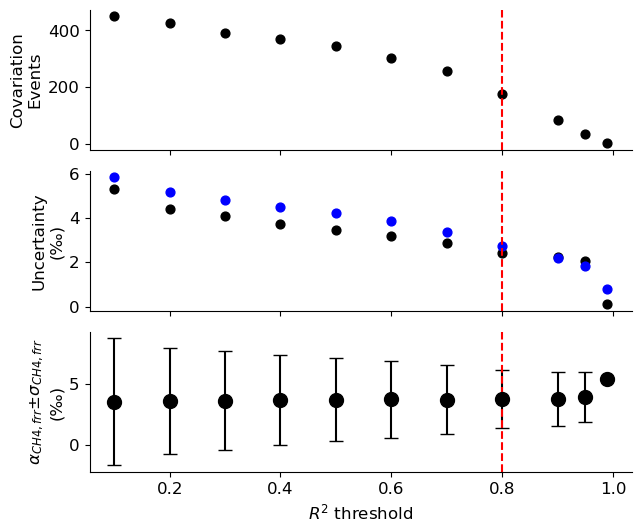

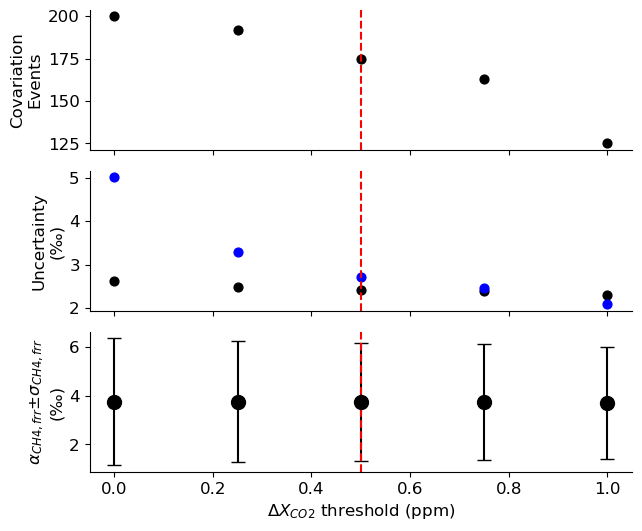

In [18]:
regr_label = 'ch4_co2'
savefig = global_savefig
showfig = global_showfig

labsize = 12
marker_size = 40
line_col = 'red'

# -----------------
# 1) Sensitivity to R² threshold (hold ΔXCO2 fixed)
base_r2 = summary_df.query(
    "(resample == '5min') & (window == '90min') & (range == 0.5)"  # hold ΔXCO2 fixed
).sort_values("r2")

fig, axes = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
line_r2 = 0.8

# Number of groups
axes[0].scatter(base_r2["r2"], base_r2["n_groups"], color="k", s=marker_size)
axes[0].axvline(line_r2, color=line_col, linestyle="dashed")
axes[0].set_ylabel("Covariation\nEvents", size=labsize)
axes[0].tick_params(labelsize=labsize)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

# STD and mean SE
axes[1].scatter(base_r2["r2"], base_r2["std_slope"]*1000, color="k", s=marker_size,
                label=r"${{\sigma}}_{{CH4,frr}}$ (STD)")
axes[1].scatter(base_r2["r2"], base_r2["mean_se_slope"]*1000, color="blue", s=marker_size,
                label=r"Mean Standard Error ${{\alpha}}_{{CH4,frr}}$")
axes[1].axvline(line_r2, color=line_col, linestyle="dashed")
axes[1].set_ylabel("Uncertainty\n(‰)", size=labsize)
axes[1].tick_params(labelsize=labsize)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
#axes[1].legend(fontsize=labsize, frameon=False)

# Mean slope ± std
axes[2].errorbar(base_r2["r2"], base_r2["weighted_mean_slope"]*1000,
                 yerr=base_r2["std_slope"]*1000, fmt="o", color="k", markersize=10, capsize=5)
axes[2].axvline(line_r2, color=line_col, linestyle="dashed")
axes[2].set_ylabel(r"${{\alpha}}_{{CH4,frr}}$±${{\sigma}}_{{CH4,frr}}$"+"\n(‰)", size=labsize)
axes[2].tick_params(labelsize=labsize)
axes[2].spines["top"].set_visible(False)
axes[2].spines["right"].set_visible(False)
axes[2].set_xlabel(r"$R^2$ threshold", size=labsize)

plt.subplots_adjust(hspace=0.15)
if savefig:
    fig.savefig(os.path.join(inst_figures_path, f"sens_r2_sweep_{regr_label}.png"),
                dpi=500, bbox_inches="tight")
if showfig:
    plt.show()
else:
    plt.close()


# -----------------
# 2) Sensitivity to ΔXCO2 threshold (hold R² fixed)
base_range = summary_df.query(
    "(resample == '5min') & (window == '90min') & (r2 == 0.8)"  # hold R² fixed
).sort_values("range")

fig, axes = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
line_range = 0.5

# Number of groups
axes[0].scatter(base_range["range"], base_range["n_groups"], color="k", s=marker_size)
axes[0].axvline(line_range, color=line_col, linestyle="dashed")
axes[0].set_ylabel("Covariation\nEvents", size=labsize)
axes[0].tick_params(labelsize=labsize)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

# STD and mean SE
axes[1].scatter(base_range["range"], base_range["std_slope"]*1000, color="k", s=marker_size,
                label=r"${{\sigma}}_{{CH4,frr}}$ (STD)")
axes[1].scatter(base_range["range"], base_range["mean_se_slope"]*1000, color="blue", s=marker_size,
                label=r"Mean Standard Error ${{\alpha}}_{{CH4,frr}}$")
axes[1].axvline(line_range, color=line_col, linestyle="dashed")
axes[1].set_ylabel("Uncertainty\n(‰)", size=labsize)
axes[1].tick_params(labelsize=labsize)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
#axes[1].legend(fontsize=labsize, frameon=False)

# Mean slope ± std
axes[2].errorbar(base_range["range"], base_range["weighted_mean_slope"]*1000,
                 yerr=base_range["std_slope"]*1000, fmt="o", color="k", markersize=10, capsize=5)
axes[2].axvline(line_range, color=line_col, linestyle="dashed")
axes[2].set_ylabel(r"${{\alpha}}_{{CH4,frr}}$±${{\sigma}}_{{CH4,frr}}$"+"\n(‰)", size=labsize)
axes[2].tick_params(labelsize=labsize)
axes[2].spines["top"].set_visible(False)
axes[2].spines["right"].set_visible(False)
axes[2].set_xlabel(r"$\Delta X_{CO2}$ threshold (ppm)", size=labsize)

plt.subplots_adjust(hspace=0.15)
if savefig:
    fig.savefig(os.path.join(inst_figures_path, f"sens_range_sweep_{regr_label}.png"),
                dpi=500, bbox_inches="tight")
if showfig:
    plt.show()
else:
    plt.close()


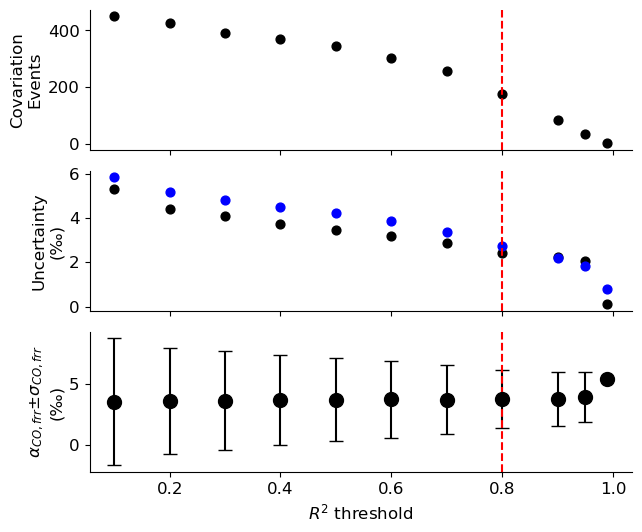

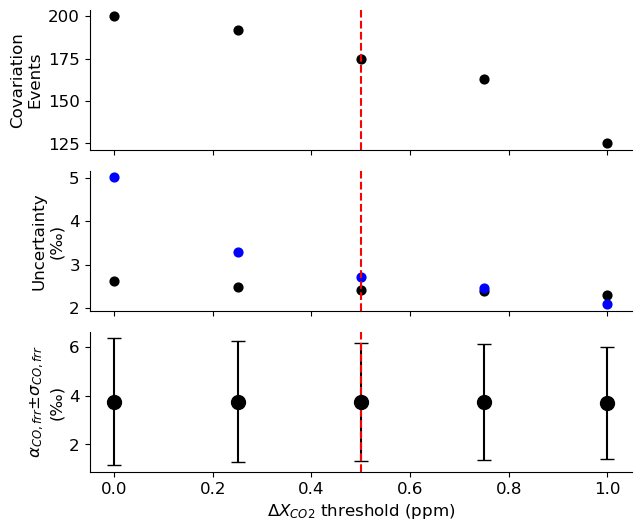

In [19]:
regr_label = 'co_co2'
savefig = global_savefig
showfig = global_showfig

labsize = 12
marker_size = 40
line_col = 'red'

# -----------------
# 1) Sensitivity to R² threshold (hold ΔXCO2 fixed)
base_r2 = summary_df.query(
    "(resample == '5min') & (window == '90min') & (range == 0.5)"  # hold ΔXCO2 fixed
).sort_values("r2")

fig, axes = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
line_r2 = 0.8

# Number of groups
axes[0].scatter(base_r2["r2"], base_r2["n_groups"], color="k", s=marker_size)
axes[0].axvline(line_r2, color=line_col, linestyle="dashed")
axes[0].set_ylabel("Covariation\nEvents", size=labsize)
axes[0].tick_params(labelsize=labsize)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

# STD and mean SE
axes[1].scatter(base_r2["r2"], base_r2["std_slope"]*1000, color="k", s=marker_size,
                label=r"${{\sigma}}_{{CO,frr}}$ (STD)")
axes[1].scatter(base_r2["r2"], base_r2["mean_se_slope"]*1000, color="blue", s=marker_size,
                label=r"Mean Standard Error ${{\alpha}}_{{CO,frr}}$")
axes[1].axvline(line_r2, color=line_col, linestyle="dashed")
axes[1].set_ylabel("Uncertainty\n(‰)", size=labsize)
axes[1].tick_params(labelsize=labsize)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
#axes[1].legend(fontsize=labsize, frameon=False)

# Mean slope ± std
axes[2].errorbar(base_r2["r2"], base_r2["weighted_mean_slope"]*1000,
                 yerr=base_r2["std_slope"]*1000, fmt="o", color="k", markersize=10, capsize=5)
axes[2].axvline(line_r2, color=line_col, linestyle="dashed")
axes[2].set_ylabel(r"${{\alpha}}_{{CO,frr}}$±${{\sigma}}_{{CO,frr}}$"+"\n(‰)", size=labsize)
axes[2].tick_params(labelsize=labsize)
axes[2].spines["top"].set_visible(False)
axes[2].spines["right"].set_visible(False)
axes[2].set_xlabel(r"$R^2$ threshold", size=labsize)

plt.subplots_adjust(hspace=0.15)
if savefig:
    fig.savefig(os.path.join(inst_figures_path, f"sens_r2_sweep_{regr_label}.png"),
                dpi=500, bbox_inches="tight")
if showfig:
    plt.show()
else:
    plt.close()


# -----------------
# 2) Sensitivity to ΔXCO2 threshold (hold R² fixed)
base_range = summary_df.query(
    "(resample == '5min') & (window == '90min') & (r2 == 0.8)"  # hold R² fixed
).sort_values("range")

fig, axes = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
line_range = 0.5

# Number of groups
axes[0].scatter(base_range["range"], base_range["n_groups"], color="k", s=marker_size)
axes[0].axvline(line_range, color=line_col, linestyle="dashed")
axes[0].set_ylabel("Covariation\nEvents", size=labsize)
axes[0].tick_params(labelsize=labsize)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

# STD and mean SE
axes[1].scatter(base_range["range"], base_range["std_slope"]*1000, color="k", s=marker_size,
                label=r"${{\sigma}}_{{CO,frr}}$ (STD)")
axes[1].scatter(base_range["range"], base_range["mean_se_slope"]*1000, color="blue", s=marker_size,
                label=r"Mean Standard Error ${{\alpha}}_{{CO,frr}}$")
axes[1].axvline(line_range, color=line_col, linestyle="dashed")
axes[1].set_ylabel("Uncertainty\n(‰)", size=labsize)
axes[1].tick_params(labelsize=labsize)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
#axes[1].legend(fontsize=labsize, frameon=False)

# Mean slope ± std
axes[2].errorbar(base_range["range"], base_range["weighted_mean_slope"]*1000,
                 yerr=base_range["std_slope"]*1000, fmt="o", color="k", markersize=10, capsize=5)
axes[2].axvline(line_range, color=line_col, linestyle="dashed")
axes[2].set_ylabel(r"${{\alpha}}_{{CO,frr}}$±${{\sigma}}_{{CO,frr}}$"+"\n(‰)", size=labsize)
axes[2].tick_params(labelsize=labsize)
axes[2].spines["top"].set_visible(False)
axes[2].spines["right"].set_visible(False)
axes[2].set_xlabel(r"$\Delta X_{CO2}$ threshold (ppm)", size=labsize)

plt.subplots_adjust(hspace=0.15)
if savefig:
    fig.savefig(os.path.join(inst_figures_path, f"sens_range_sweep_{regr_label}.png"),
                dpi=500, bbox_inches="tight")
if showfig:
    plt.show()
else:
    plt.close()


### Window Size Sensitivity (Figure S14)

In [20]:
oof_resample_freqs = ['5min']
rolling_windows = ['15min','30min','45min','60min','75min','90min','120min','180min','240min','360min','480min','1440min','2880min']
filter_param_grid = {
    "window_nobs": [1],
    "r2": [0.8],
    "range": [0.5],
    "time_diff": [0],  
    "tdelta": [pd.to_timedelta("20min")],
    "nratio_good_thresh": [3]
}
filter_sets = build_filter_sets(q, filter_param_grid)
sensitivity_paths = build_sensitivity_paths(inst_data_path, oof_resample_freqs, rolling_windows,rolling_regr_params, save=False)
sensitivity_dfs = build_sensitivity_dfs(sensitivity_paths, filter_sets)
summary_dfs = {}
summary_dfs['co_co2'] = build_summary_df(sensitivity_dfs, regr_label='co_co2')
summary_dfs['ch4_co2'] = build_summary_df(sensitivity_dfs, regr_label='ch4_co2')


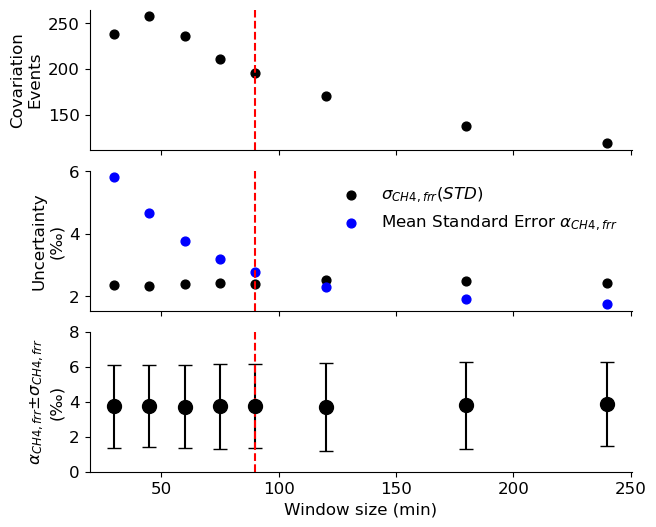

In [21]:
regr_label = 'ch4_co2'
fig_id = f"rolling_window_sensitivity_{regr_label}"
savefig = global_savefig
showfig = global_showfig

labsize = 12
marker_size = 40
line = 90
line_col = 'red'

plotdf = summary_dfs[regr_label][1:-4]  # drop last 2 rows if needed

fig, axes = plt.subplots(3, 1, figsize=(7, 6), sharex=True)

# -----------------
# 1. Number of groups
axes[0].scatter(
    plotdf["window_mins"],
    plotdf["n_groups"],
    color="k",
    s=marker_size
)
axes[0].axvline(line, color="red", linestyle="dashed")
axes[0].set_ylabel("Covariation\nEvents", size=labsize)
axes[0].tick_params(labelsize=labsize)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
#axes[0].xaxis.grid(True)

# -----------------
# 2. STD of slope + mean SE slope
axes[1].scatter(
    plotdf["window_mins"],
    plotdf["std_slope"] * 1000,
    color="k",
    s=marker_size,
    label=r"${{\sigma}}_{{CH4,frr}} (STD)$"
)
axes[1].scatter(
    plotdf["window_mins"],
    plotdf["mean_se_slope"] * 1000,
    color="blue",
    s=marker_size,
    label=r"Mean Standard Error ${{\alpha}}_{{CH4,frr}}$"
) 
axes[1].axvline(line, color="red", linestyle="dashed")
axes[1].set_ylabel("Uncertainty\n(‰)", size=labsize)
axes[1].tick_params(labelsize=labsize)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
#axes[1].xaxis.grid(True)
axes[1].legend(fontsize=labsize , frameon=False)

# -----------------
# 3. Mean slope ± std
axes[2].errorbar(
    plotdf["window_mins"],
    plotdf["weighted_mean_slope"] * 1000,
    yerr=plotdf["std_slope"] * 1000,
    fmt="o",
    color="k",
    markersize=10,
    capsize=5
)
axes[2].axvline(line, color="red", linestyle="dashed")
axes[2].set_ylabel(r"${{\alpha}}_{{CH4,frr}}$±${{\sigma}}_{{CH4,frr}}$"+"\n(‰)", size=labsize)
axes[2].set_ylim(0, 8)
axes[2].tick_params(labelsize=labsize)
axes[2].spines["top"].set_visible(False)
axes[2].spines["right"].set_visible(False)
#axes[2].xaxis.grid(True)
axes[2].set_xlabel("Window size (min)", size=labsize)

# -----------------
plt.subplots_adjust(hspace=0.15)

if savefig:
    fig_name = f"{fig_id}.png"
    fig.savefig(os.path.join(inst_figures_path, fig_name),
                dpi=500, bbox_inches="tight")
if showfig:
    plt.show()
else:
    plt.close()


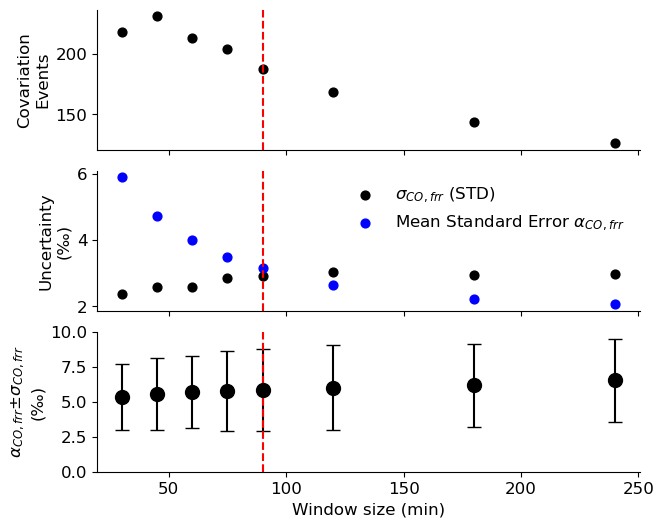

In [22]:
regr_label = 'co_co2'
fig_id = f"rolling_window_sensitivity_{regr_label}"
savefig = global_savefig
showfig = global_showfig

labsize = 12
marker_size = 40
line = 90
line_col = 'red'

plotdf = summary_dfs[regr_label][1:-4]  # drop last 2 rows if needed

fig, axes = plt.subplots(3, 1, figsize=(7, 6), sharex=True)

# -----------------
# 1. Number of groups
axes[0].scatter(
    plotdf["window_mins"],
    plotdf["n_groups"],
    color="k",
    s=marker_size
)
axes[0].axvline(line, color="red", linestyle="dashed")
axes[0].set_ylabel("Covariation\nEvents", size=labsize)
axes[0].tick_params(labelsize=labsize)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
#axes[0].xaxis.grid(True)

# -----------------
# 2. STD of slope + mean SE slope
axes[1].scatter(
    plotdf["window_mins"],
    plotdf["std_slope"] * 1000,
    color="k",
    s=marker_size,
    label=r"${{\sigma}}_{{CO,frr}}$ (STD)"
)
axes[1].scatter(
    plotdf["window_mins"],
    plotdf["mean_se_slope"] * 1000,
    color="blue",
    s=marker_size,
    label=r"Mean Standard Error ${{\alpha}}_{{CO,frr}}$"
) 
axes[1].axvline(line, color="red", linestyle="dashed")
axes[1].set_ylabel("Uncertainty\n(‰)", size=labsize)
axes[1].tick_params(labelsize=labsize)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
#axes[1].xaxis.grid(True)
axes[1].legend(fontsize=labsize , frameon=False)

# -----------------
# 3. Mean slope ± std
axes[2].errorbar(
    plotdf["window_mins"],
    plotdf["weighted_mean_slope"] * 1000,
    yerr=plotdf["std_slope"] * 1000,
    fmt="o",
    color="k",
    markersize=10,
    capsize=5
)
axes[2].axvline(line, color="red", linestyle="dashed")
axes[2].set_ylabel(r"${{\alpha}}_{{CO,frr}}$±${{\sigma}}_{{CO,frr}}$"+"\n(‰)", size=labsize)
axes[2].set_ylim(0, 10)
axes[2].tick_params(labelsize=labsize)
axes[2].spines["top"].set_visible(False)
axes[2].spines["right"].set_visible(False)
axes[2].set_xlabel("Window size (min)", size=labsize)

# -----------------
plt.subplots_adjust(hspace=0.15)

if savefig:
    fig_name = f"{fig_id}.png"
    fig.savefig(os.path.join(inst_figures_path, fig_name),
                dpi=500, bbox_inches="tight")
if showfig:
    plt.show()
else:
    plt.close()


## Rolling Ratio Final selection
After exploring sensitivity to various parameters, we select a final set of parameters for the rolling regression. 

In [23]:
# Define filters and grouping details for final filtering of rolling regression results
oof_resample = '5min'
rolling_window = '90min'
all_rolling_regr_df = pd.read_parquet(os.path.join(inst_data_path,'rolling',f'all_rolling_regr_{oof_resample}res_{rolling_window}win.parquet'))

rolling_regr_filters = {
    'ch4_co2':{
        'window_nobs': ('>',10),
        'ch4_co2_york_r_squared': ('>',0.8),
        'xco2(ppm)_wmean_ex5q_divak_range': ('>',0.5),
        'xco2(ppm)_wmean_ex5q_divak_time_diff': ('>',0)
    },
    'co_co2':{
        'window_nobs': ('>',10),
        'co_co2_york_r_squared': ('>',0.8),
        'xco2(ppm)_wmean_ex5q_divak_range': ('>',0.5),
        'xco2(ppm)_wmean_ex5q_divak_time_diff': ('>',0)
    }
}
grouping_details = {
    'tdelta':pd.to_timedelta('5min')*2,
    'nratio_good_thresh': 4,
}

all_rolling_regr_df_filtered = add_filter_and_group_cols(all_rolling_regr_df,rolling_regr_filters,grouping_details)

In [24]:
#Add met data to the final filtered rolling regression dataframe
met_resampled = met_df[['u','v']].resample('5min',label='right',closed='right').mean()
met_resampled['ws'],met_resampled['wd'] = np.vectorize(met_utils.uv_to_wswd)(met_resampled['u'],met_resampled['v'])
all_rolling_regr_df_filtered = all_rolling_regr_df_filtered.merge(met_resampled[['u','v','wd','ws']],left_index=True,right_index=True,how='left')

In [25]:
# This cell is for saving the dataframes to csv files for R use in OpenAir
csv_for_r_path = os.path.join(inst_data_path,'all_rolling_regr_df_filtered.csv')
all_rolling_regr_df_filtered.reset_index().to_csv(csv_for_r_path,index=False)

# Create Figures

## Full Timeseries and Filter (Figure 2)

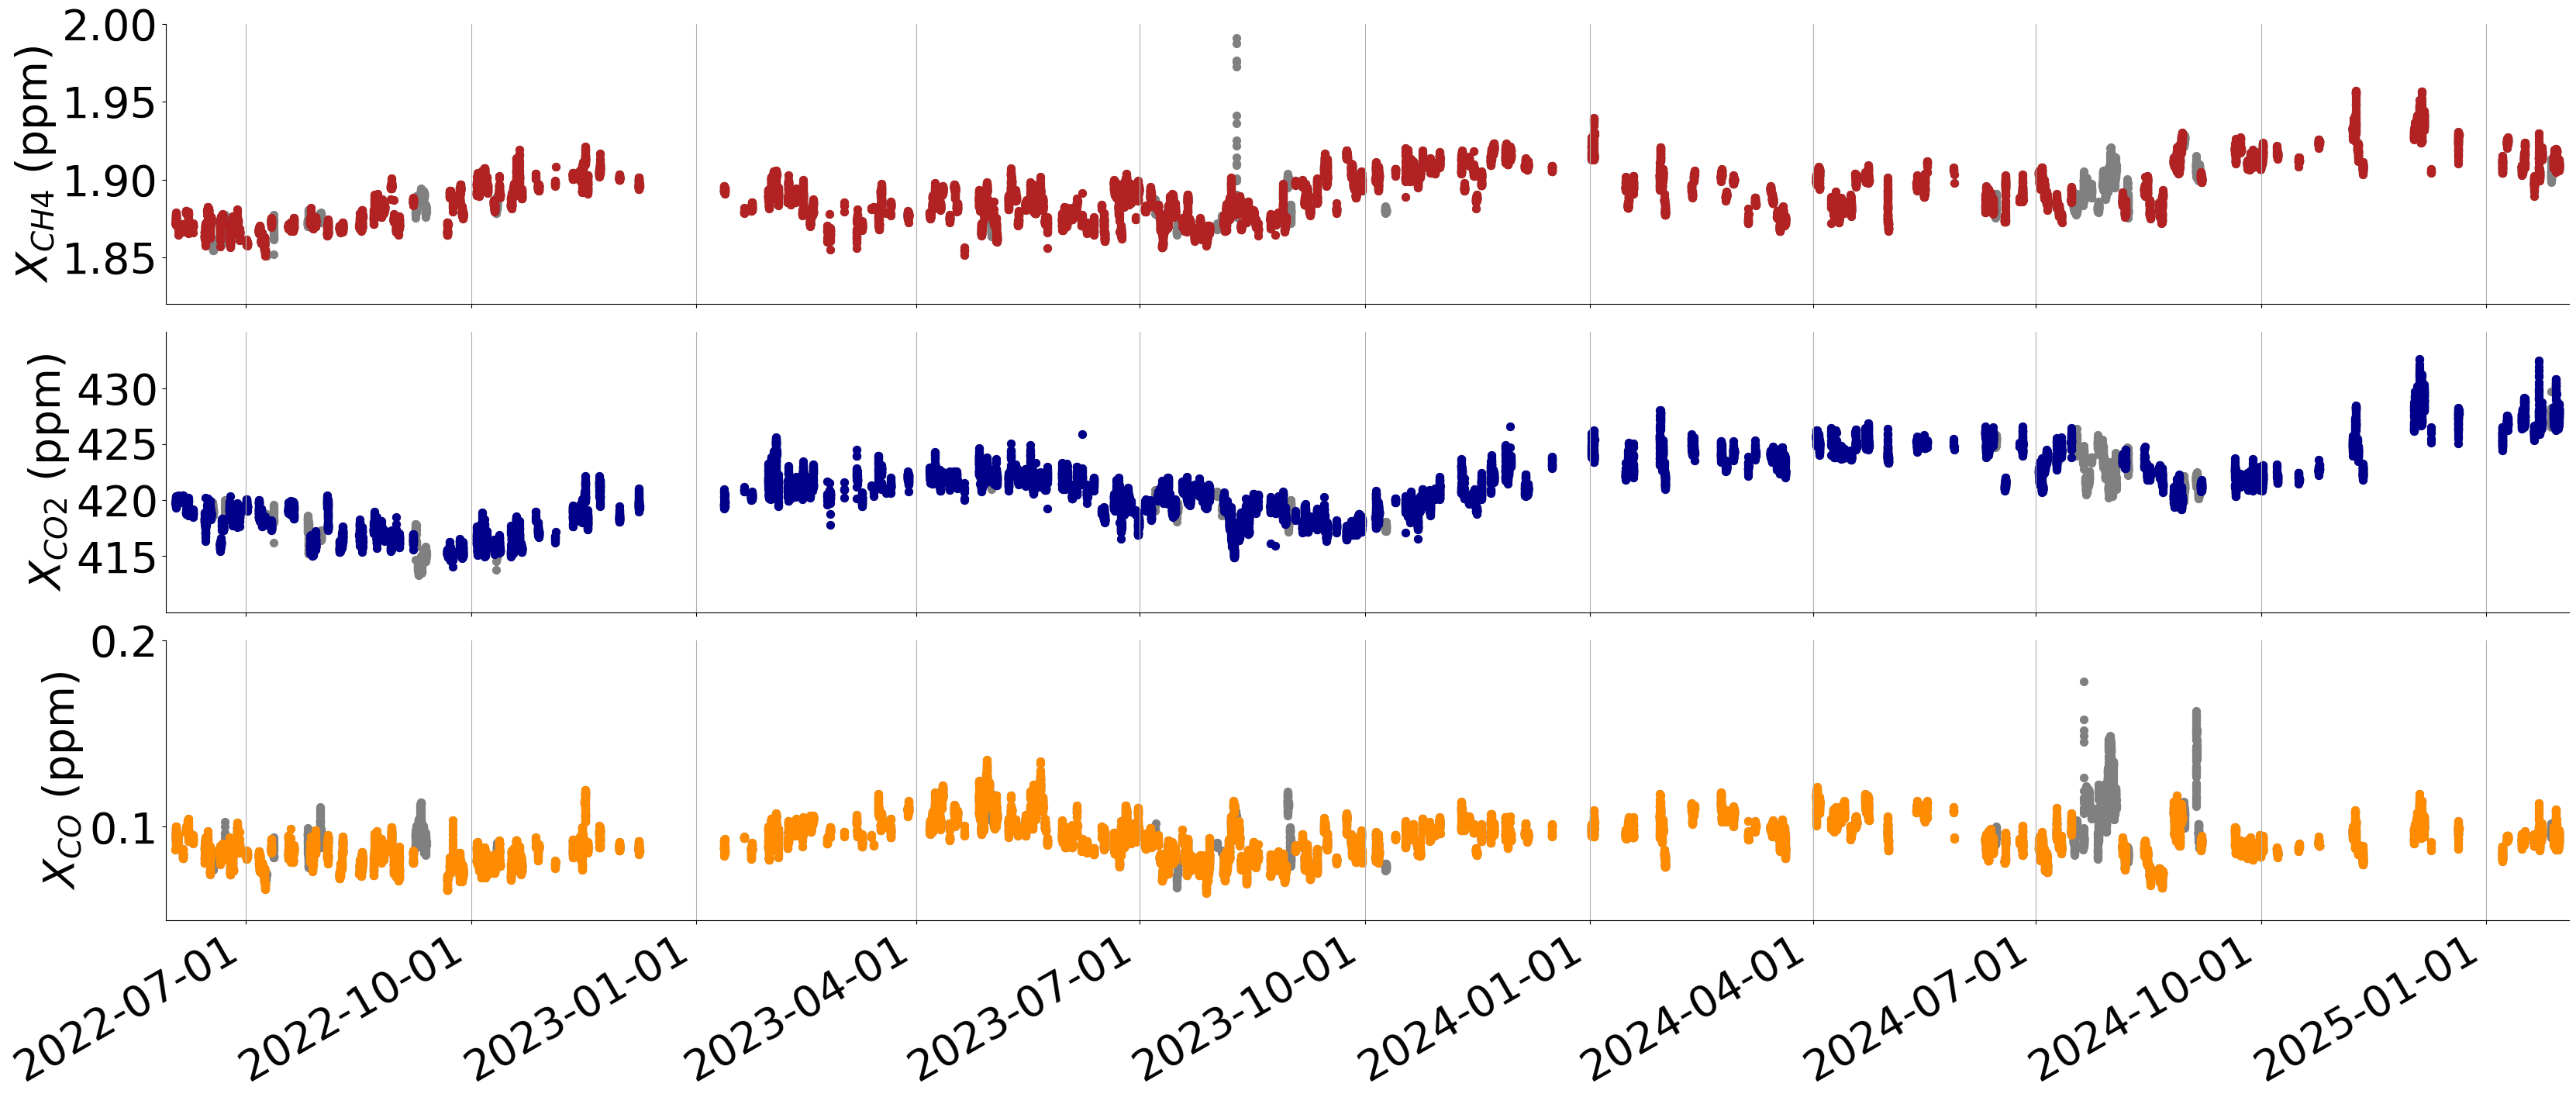

In [26]:
fig_id = f"full_EM27_ts_withfilter" #Set the figure id
savefig = global_savefig 
showfig = global_showfig

fig,axes = plt.subplots(3,1,figsize = (40,17))
labsize = 40
marker_size = 50

resample_freq = '5T'
gases = ['xch4(ppm)','xco2(ppm)','xco(ppm)']
oof_df_full_resampled = oof_df_full[gases].resample(resample_freq).mean()
oof_df_resampled = oof_df[gases].resample(resample_freq).mean()

xlims = [oof_df_full_resampled.index[0]-datetime.timedelta(days=4),oof_df_full_resampled.index[-1]+datetime.timedelta(days=4)]

row = 0
axes[row].scatter(oof_df_full_resampled.index,oof_df_full_resampled['xch4(ppm)'],color = 'grey',s=marker_size)
axes[row].scatter(oof_df_resampled.index,oof_df_resampled['xch4(ppm)'],color = 'firebrick',s=marker_size)
axes[row].tick_params(labelsize = labsize)
axes[row].set_ylabel(r'$X_{CH4}$ (ppm)',size = labsize)
axes[row].set_xlim(xlims)
axes[row].spines['top'].set_visible(False)
axes[row].spines['right'].set_visible(False)
axes[row].xaxis.grid(True)
axes[row].set_ylim([1.82,2.0])
axes[row].set_yticks([1.85,1.9,1.95,2.0])

row = 1
axes[row].scatter(oof_df_full_resampled.index,oof_df_full_resampled['xco2(ppm)'],color = 'grey',s=marker_size)
axes[row].scatter(oof_df_resampled.index,oof_df_resampled['xco2(ppm)'],color = 'darkblue',s=marker_size)
axes[row].tick_params(labelsize = labsize)
axes[row].set_ylabel(r'$X_{CO2}$ (ppm)',size = labsize)
axes[row].set_xlim(xlims)
axes[row].spines['top'].set_visible(False)
axes[row].spines['right'].set_visible(False)
axes[row].xaxis.grid(True)
axes[row].set_ylim([410,435])
axes[row].set_yticks([415,420,425,430])

row = 2
axes[row].scatter(oof_df_full_resampled.index,oof_df_full_resampled['xco(ppm)'],color = 'grey',s=marker_size)
axes[row].scatter(oof_df_resampled.index,oof_df_resampled['xco(ppm)'],color = 'darkorange',s=marker_size)
axes[row].tick_params(labelsize = labsize)
axes[row].set_ylabel(r'$X_{CO}$ (ppm)',size = labsize)
axes[row].set_xlim(xlims)
axes[row].spines['top'].set_visible(False)
axes[row].spines['right'].set_visible(False)
axes[row].xaxis.grid(True)
axes[row].set_ylim([0.05,0.2])
axes[row].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz = oof_df_resampled.index.tz))

plt.subplots_adjust(hspace=0.1)
plt.gcf().autofmt_xdate()


if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=500,bbox_inches = "tight")
if showfig:
    plt.show()
else:
    plt.close()

## Averaging Kernel Figure (Figure S6)

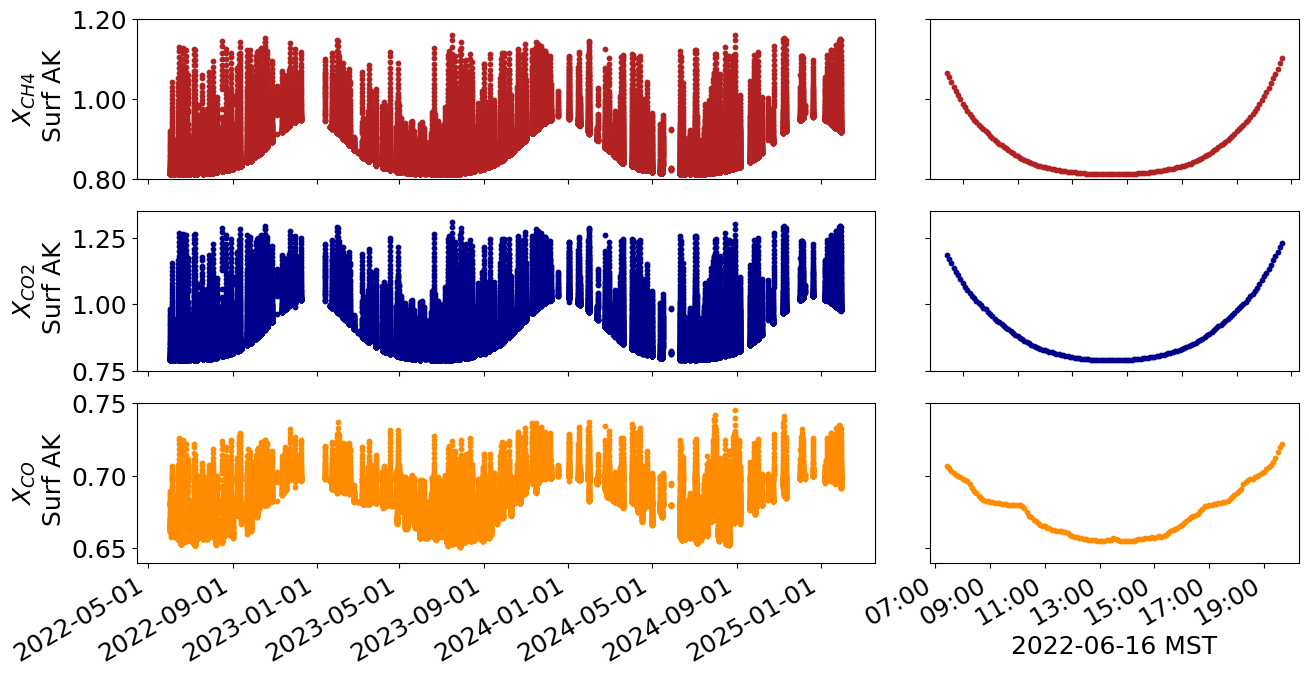

In [27]:
date_str = '2022-06-16'
fig_id = f'ak_example_{date_str}' #Set the figure id
savefig = global_savefig 
showfig = global_showfig

plotdf = ak_df.resample('5T').mean()
single_day = plotdf.loc[date_str]
marker_size = 10
labsize = 18

fig, axes = plt.subplots(3, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.1})

row = 0
col = 0
name = 'xch4(ppm)_surf_ak'
color = 'firebrick'
ylims = [0.8,1.2]
axes[row,col].scatter(plotdf.index,plotdf[name],s=marker_size,c=color)
axes[row,col].set_ylim(ylims)
axes[row,col].set_ylabel(r'$X_{CH4}$'+'\n Surf AK',size = labsize)
axes[row,col].set_yticklabels([f'{i:.2f}' for i in np.arange(0.8,1.3,0.2)])
col = 1
axes[row,col].scatter(single_day.index,single_day[name],s=marker_size,c=color)
axes[row,col].set_ylim(ylims)

row = 1
col = 0
name = 'xco2(ppm)_surf_ak'
color = 'darkblue'
ylims = [0.75,1.35]
axes[row,col].scatter(plotdf.index,plotdf[name],s=marker_size,c=color)
axes[row,col].set_ylim(ylims)
axes[row,col].set_ylabel(r'$X_{CO2}$'+'\n Surf AK',size = labsize)
col = 1
axes[row,col].scatter(single_day.index,single_day[name],s=marker_size,c=color)
axes[row,col].set_ylim(ylims)

row = 2
col = 0
name = 'xco(ppm)_surf_ak'
color = 'darkorange'
ylims = [0.64,0.75]
axes[row,col].scatter(plotdf.index,plotdf[name],s=marker_size,c=color)
axes[row,col].set_ylim(ylims)
axes[row,col].set_ylabel(r'$X_{CO}$'+'\n Surf AK',size = labsize)
axes[row, col].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d', tz=plotdf.index[0].tz))
col = 1
axes[row,col].scatter(single_day.index,single_day[name],s=marker_size,c=color)
axes[row,col].set_ylim(ylims)
axes[row, col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
axes[row, col].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M', tz=plotdf.index[0].tz))
axes[row, col].set_xlabel(f"{datetime.datetime.strftime(single_day.index[0],'%Y-%m-%d')} MST",size = labsize)

for ax in axes.flat:
    ax.tick_params(axis='both', which='major', labelsize=labsize)
for ax in axes[:-1, :].flat:
    ax.set_xticklabels([])
for ax in axes[:, 1].flat:
    ax.set_yticklabels([])
plt.gcf().autofmt_xdate()
plt.tight_layout()

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=500,bbox_inches = "tight")
if showfig:
    plt.show()
else:
    plt.close()

### Lag Plots of Full OOF Data (Figure S3)

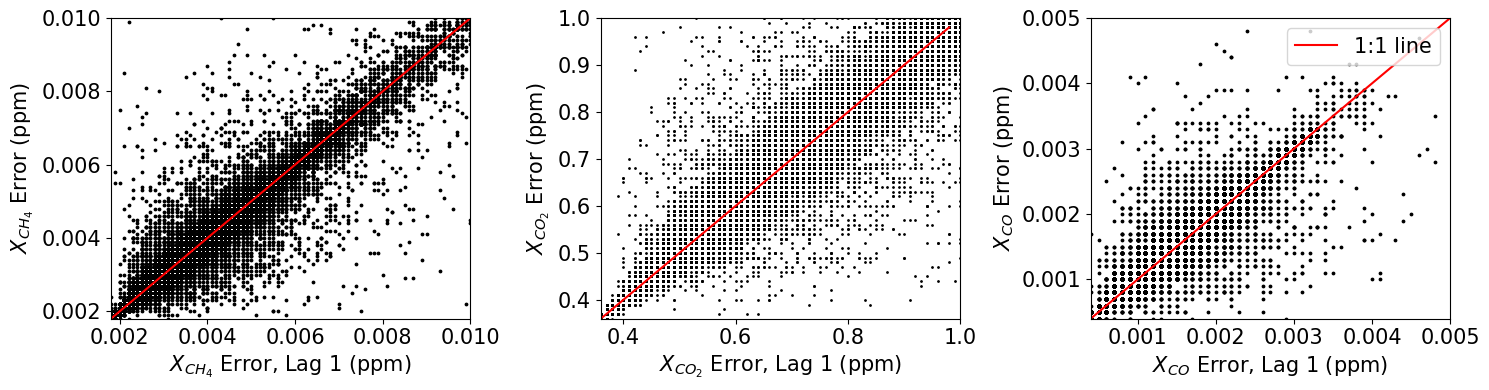

In [28]:
fig_id = 'lag_plots' #Set the figure id
savefig = global_savefig 
showfig = global_showfig

fig,axs = plt.subplots(1,3,figsize=(15,4))
labsize = 15

axs[0].scatter(
    oof_df_full['xch4(ppm)_error'].shift(1),
    oof_df_full['xch4(ppm)_error'],
    s = 3,
    c = 'k'
)
axs[0].plot([oof_df_full['xch4(ppm)_error'].min(),0.01],[oof_df_full['xch4(ppm)_error'].min(),0.01],c='r',label='1:1 line')
axs[0].set_ylabel(r'$X_{CH_{4}}$ '+'Error (ppm)' ,fontsize=labsize)
axs[0].set_xlabel(r'$X_{CH_{4}}$ '+'Error, Lag 1 (ppm)',fontsize=labsize)
axs[0].set_ylim(oof_df_full['xch4(ppm)_error'].min(),0.01)
axs[0].set_xlim(oof_df_full['xch4(ppm)_error'].min(),0.01)
axs[0].tick_params(labelsize=labsize)

axs[1].scatter(
    oof_df_full['xco2(ppm)_error'].shift(1),
    oof_df_full['xco2(ppm)_error'],
    s = 1,
    c = 'k'
)
axs[1].plot([oof_df_full['xco2(ppm)_error'].min(),0.98],[oof_df_full['xco2(ppm)_error'].min(),0.98],c='r',label='1:1 line')
axs[1].set_ylabel(r'$X_{CO_{2}}$ '+'Error (ppm)',fontsize=labsize)
axs[1].set_xlabel(r'$X_{CO_{2}}$ '+'Error, Lag 1 (ppm)',fontsize=labsize)
axs[1].set_ylim(oof_df_full['xco2(ppm)_error'].min(),1)
axs[1].set_xlim(oof_df_full['xco2(ppm)_error'].min(),1)
axs[1].tick_params(labelsize=labsize)

axs[2].scatter(
    oof_df_full['xco(ppm)_error'].shift(1),
    oof_df_full['xco(ppm)_error'],
    s = 3,
    c = 'k'
)
axs[2].plot([oof_df_full['xco(ppm)_error'].min(),0.005],[oof_df_full['xco(ppm)_error'].min(),0.005],c='r',label='1:1 line')
axs[2].set_ylabel(r'$X_{CO}$ '+'Error (ppm)',fontsize=labsize)
axs[2].set_xlabel(r'$X_{CO}$ '+'Error, Lag 1 (ppm)',fontsize=labsize)
axs[2].set_ylim(oof_df_full['xco(ppm)_error'].min(),0.005)
axs[2].set_xlim(oof_df_full['xco(ppm)_error'].min(),0.005)
axs[2].tick_params(labelsize=labsize)

axs[2].legend(fontsize=labsize)
fig.tight_layout()
plt.show()

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=500,bbox_inches = "tight")
if showfig:
    plt.show()
else:
    plt.close()

## Anomaly Illustration (Figure S4)

In [29]:
#Define an instrument, date, sza bin size, and the species we want 
date_str = '2023-09-29'
gases = ['xco2(ppm)','xch4(ppm)','xco(ppm)']
sza_bin_size = 0.5
co2_thresh = 1

day_df = daily_oof_dict[date_str].copy()  #get the specific day's df for that instrument
binned_summary_df = ac_utils.create_binned_summary(day_df,ak_df,sza_bin_size,gases) #create the binned summary 
anom_df, skipped_df = ac_utils.daily_anomaly_creator(binned_summary_df,gases,co2_thresh) #get the anomaly and skipped rows dataframes 

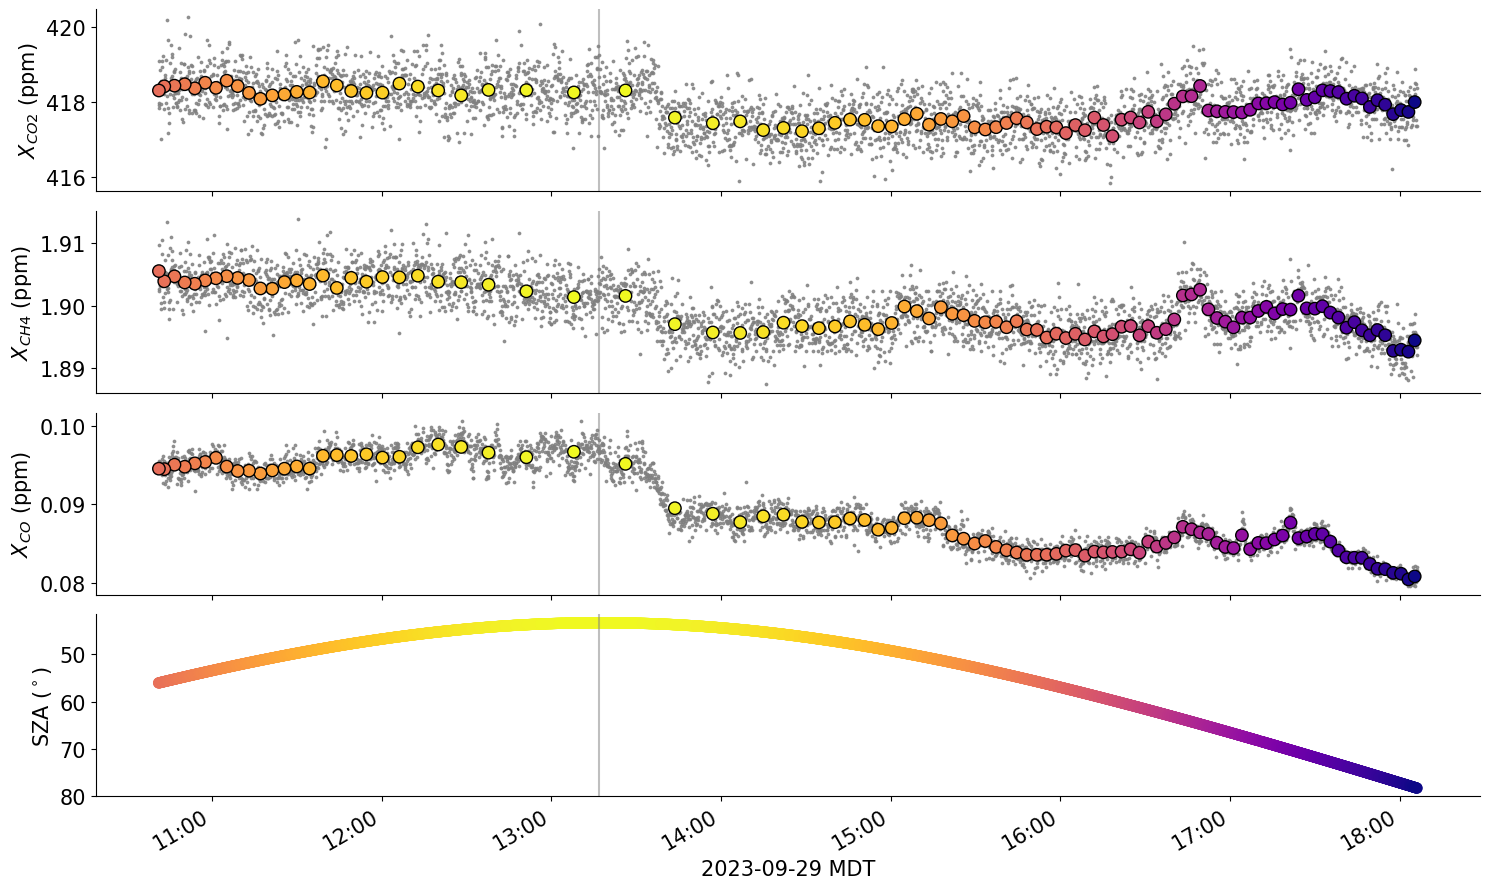

In [30]:
fig_id = f'anomaly_example_ts_{date_str}' #Set the figure id
savefig = global_savefig 
showfig = global_showfig

#Setup the fig
fig, axs = plt.subplots(4, 1, figsize=(15, 9))
labsize = 15

# Get the min and max 'solzen(deg)' values in the DataFrame 'df'
min_sza = day_df['solzen(deg)'].min()
max_sza = day_df['solzen(deg)'].max()
# Create a ScalarMappable object for color mapping
cmap = 'plasma_r'#'autumn_r'
norm = Normalize(vmin=min_sza, vmax=max_sza)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # To satisfy ScalarMappable

min_sza_idx = day_df['solzen(deg)'].idxmin() #for drawing the vertical line indicating change from "rise" to "set"

row = 0
spec = 'xco2(ppm)' #get the species
axs[row].scatter(
    day_df.index,
    day_df[spec],
    s=3,
    c='grey',
    alpha=0.8,
    label='Collected Data'
) #plot the raw data in grey 
scatter = axs[row].scatter(
    binned_summary_df['tmid'],
    binned_summary_df[spec],
    s=80,
    edgecolors = 'k',
    c=binned_summary_df['sza_mid'],
    cmap=cmap,
    norm=norm,  # Apply the same normalization to ensure consistent color scale
)#plot the sza binned data, and color by like sza bins
axs[row].tick_params(labelsize=labsize)
axs[row].set_ylabel(r'$X_{CO2}$ (ppm)',size = labsize)
axs[row].spines['top'].set_visible(False)
axs[row].spines['right'].set_visible(False)
axs[row].axvline(min_sza_idx, c='grey', alpha=0.5)

row = 1
spec = 'xch4(ppm)' #get the species
axs[row].scatter(
    day_df.index,
    day_df[spec],
    s=3,
    c='grey',
    alpha=0.8,
    label='Collected Data'
) #plot the raw data in grey 
scatter = axs[row].scatter(
    binned_summary_df['tmid'],
    binned_summary_df[spec],
    s=80,
    edgecolors = 'k',
    c=binned_summary_df['sza_mid'],
    cmap=cmap,
    norm=norm,  # Apply the same normalization to ensure consistent color scale
)#plot the sza binned data, and color by like sza bins
axs[row].tick_params(labelsize=labsize)
axs[row].set_ylabel(r'$X_{CH4}$ (ppm)',size = labsize)
axs[row].spines['top'].set_visible(False)
axs[row].spines['right'].set_visible(False)
axs[row].axvline(min_sza_idx, c='grey', alpha=0.5)


row = 2
spec = 'xco(ppm)' #get the species
axs[row].scatter(
    day_df.index,
    day_df[spec],
    s=3,
    c='grey',
    alpha=0.8,
    label='Collected Data'
) #plot the raw data in grey 
scatter = axs[row].scatter(
    binned_summary_df['tmid'],
    binned_summary_df[spec],
    s=80,
    edgecolors = 'k',
    c=binned_summary_df['sza_mid'],
    cmap=cmap,
    norm=norm,  # Apply the same normalization to ensure consistent color scale
)#plot the sza binned data, and color by like sza bins
axs[row].tick_params(labelsize=labsize)
axs[row].set_ylabel(r'$X_{CO}$ (ppm)',size = labsize)
axs[row].spines['top'].set_visible(False)
axs[row].spines['right'].set_visible(False)
axs[row].axvline(min_sza_idx, c='grey', alpha=0.5)


# Adjusting the last subplot for 'solzen(deg)' visualization
row = 3
axs[row].scatter(
    day_df.index,
    day_df['solzen(deg)'],
    s=50,
    c=day_df['solzen(deg)'],
    cmap=cmap,
    norm=norm  # Apply the same normalization to ensure consistent color scale
)
axs[row].set_ylim(axs[row].get_ylim()[::-1]) #swap the direction of the y axis for sun "rising" idea
axs[row].axvline(min_sza_idx, c='grey', alpha=0.5) #vertical line for showing change from 'rise' to 'set'
axs[row].tick_params(labelsize=labsize)
axs[row].set_ylabel('SZA ($^\circ$)', size=labsize)
axs[row].spines['top'].set_visible(False)
axs[row].spines['right'].set_visible(False)
axs[row].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=day_df.index.tz))
axs[row].set_xlabel(datetime.datetime.strftime(day_df.index[0], '%Y-%m-%d %Z'), size=labsize)

# Adjusting layout and formatting
plt.subplots_adjust(hspace=0.1)
plt.gcf().autofmt_xdate()
plt.tight_layout()

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=500,bbox_inches = "tight")
if showfig:
    plt.show()
else:
    plt.close()

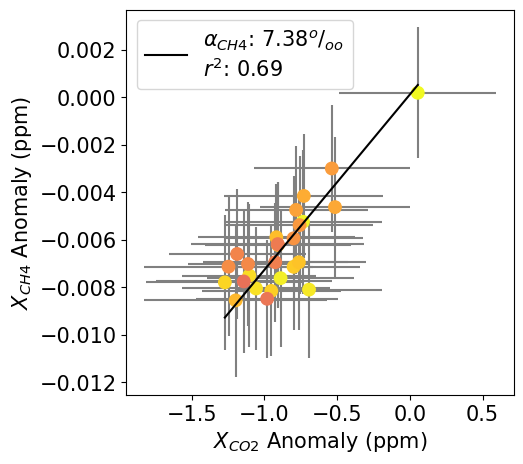

In [31]:
fig_id = f'anomaly_example_ch4_co2_{date_str}' #Set the figure id
savefig = global_savefig 
showfig = global_showfig

#Setup the fig
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
labsize = 15

x_name = 'xco2(ppm)_anom'
y_name = 'xch4(ppm)_anom'
x_err_name = 'xco2(ppm)_std'
y_err_name = 'xch4(ppm)_std'
regression_output = regression_utils.york_regression(anom_df,x_name,y_name,x_err_name,y_err_name)

ax.errorbar(
    anom_df[x_name],
    anom_df[y_name],
    xerr=anom_df[x_err_name],
    yerr=anom_df[y_err_name],
    fmt='o',
    markersize=0,
    c='grey',
    zorder  =1
)
ax.scatter(
    anom_df[x_name],
    anom_df[y_name],
    s=80,
    c=anom_df['sza_mid'],
    cmap=cmap,
    norm=norm,
    zorder = 2
)


# Regression Plotter
xline = np.array([anom_df[x_name].min(), anom_df[x_name].max()])
yline = regression_utils.linear_model([regression_output['slope'], regression_output['intercept']], xline)
label = r'${\alpha}_{CH4}$: ' + f'{regression_output["slope"]*1000:.2f}' + r"$^o/_{oo}$" + '\n' + r'$r^2$: ' + f'{regression_output["r_squared"]:.2f}'
ax.plot(xline, yline, c='k', label=label)
ax.legend(fontsize=labsize)

ax.set_xlabel(r'$X_{CO2}$ Anomaly'+' (ppm)', size=labsize)
ax.set_ylabel(r'$X_{CH4}$ Anomaly'+' (ppm)', size=labsize)

ax.tick_params(labelsize=labsize)

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=500,bbox_inches = "tight")
if showfig:
    plt.show()
else:
    plt.close()

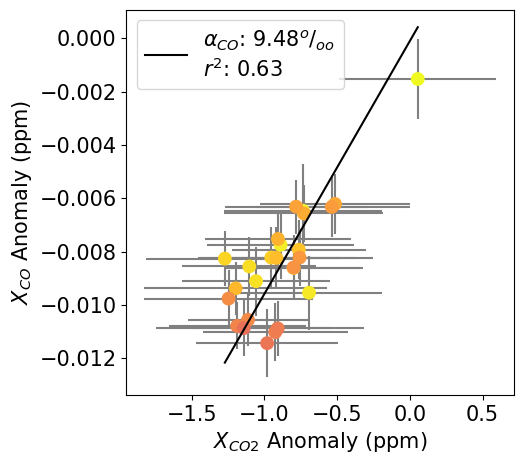

In [32]:
fig_id = f'anomaly_example_co_co2_{date_str}' #Set the figure id
savefig = global_savefig 
showfig = global_showfig

#Setup the fig
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
labsize = 15

x_name = 'xco2(ppm)_anom'
y_name = 'xco(ppm)_anom'
x_err_name = 'xco2(ppm)_std'
y_err_name = 'xco(ppm)_std'
regression_output = regression_utils.york_regression(anom_df,x_name,y_name,x_err_name,y_err_name)

ax.errorbar(
    anom_df[x_name],
    anom_df[y_name],
    xerr=anom_df[x_err_name],
    yerr=anom_df[y_err_name],
    fmt='o',
    markersize=0,
    c='grey',
    zorder  =1
)
ax.scatter(
    anom_df[x_name],
    anom_df[y_name],
    s=80,
    c=anom_df['sza_mid'],
    cmap=cmap,
    norm=norm,
    zorder = 2
)


# Regression Plotter
xline = np.array([anom_df[x_name].min(), anom_df[x_name].max()])
yline = regression_utils.linear_model([regression_output['slope'], regression_output['intercept']], xline)
label = r'${\alpha}_{CO}$: ' + f'{regression_output["slope"]*1000:.2f}' + r"$^o/_{oo}$" + '\n' + r'$r^2$: ' + f'{regression_output["r_squared"]:.2f}'
ax.plot(xline, yline, c='k', label=label)
ax.legend(fontsize=labsize)

ax.set_xlabel(r'$X_{CO2}$ Anomaly'+' (ppm)', size=labsize)
ax.set_ylabel(r'$X_{CO}$ Anomaly'+' (ppm)', size=labsize)

ax.tick_params(labelsize=labsize)

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=500,bbox_inches = "tight")
if showfig:
    plt.show()
else:
    plt.close()

## Quantile Illustration (Figure S5)

In [33]:
resample_freq = '5T'
min_obs = compute_min_obs(oof_dt_raw,resample_freq,pct_required)
resample_with_stats_kwargs = {'min_obs':min_obs}
date_str = '2023-09-29'#'2023-03-17'
df = daily_oof_dict[date_str].copy()

quantile_df, col_quantiles = resample_and_get_excess(df,ak_df,resample_freq,gases,oof_background_quantile,resample_with_stats_kwargs = resample_with_stats_kwargs)

#Compute regressions
quantile_regression_outputs = {}

x_name = f'xco2(ppm)_wmean_ex{q}q_divak'
y_name = f'xch4(ppm)_wmean_ex{q}q_divak'
quantile_regression_outputs['ch4_co2'] = regression_utils.calculate_all_regressions(quantile_df.dropna(),x_name,y_name,err_tags)

x_name = f'xco2(ppm)_wmean_ex{q}q_divak'
y_name = f'xco(ppm)_wmean_ex{q}q_divak'
quantile_regression_outputs['co_co2'] = regression_utils.calculate_all_regressions(quantile_df.dropna(),x_name,y_name,err_tags)

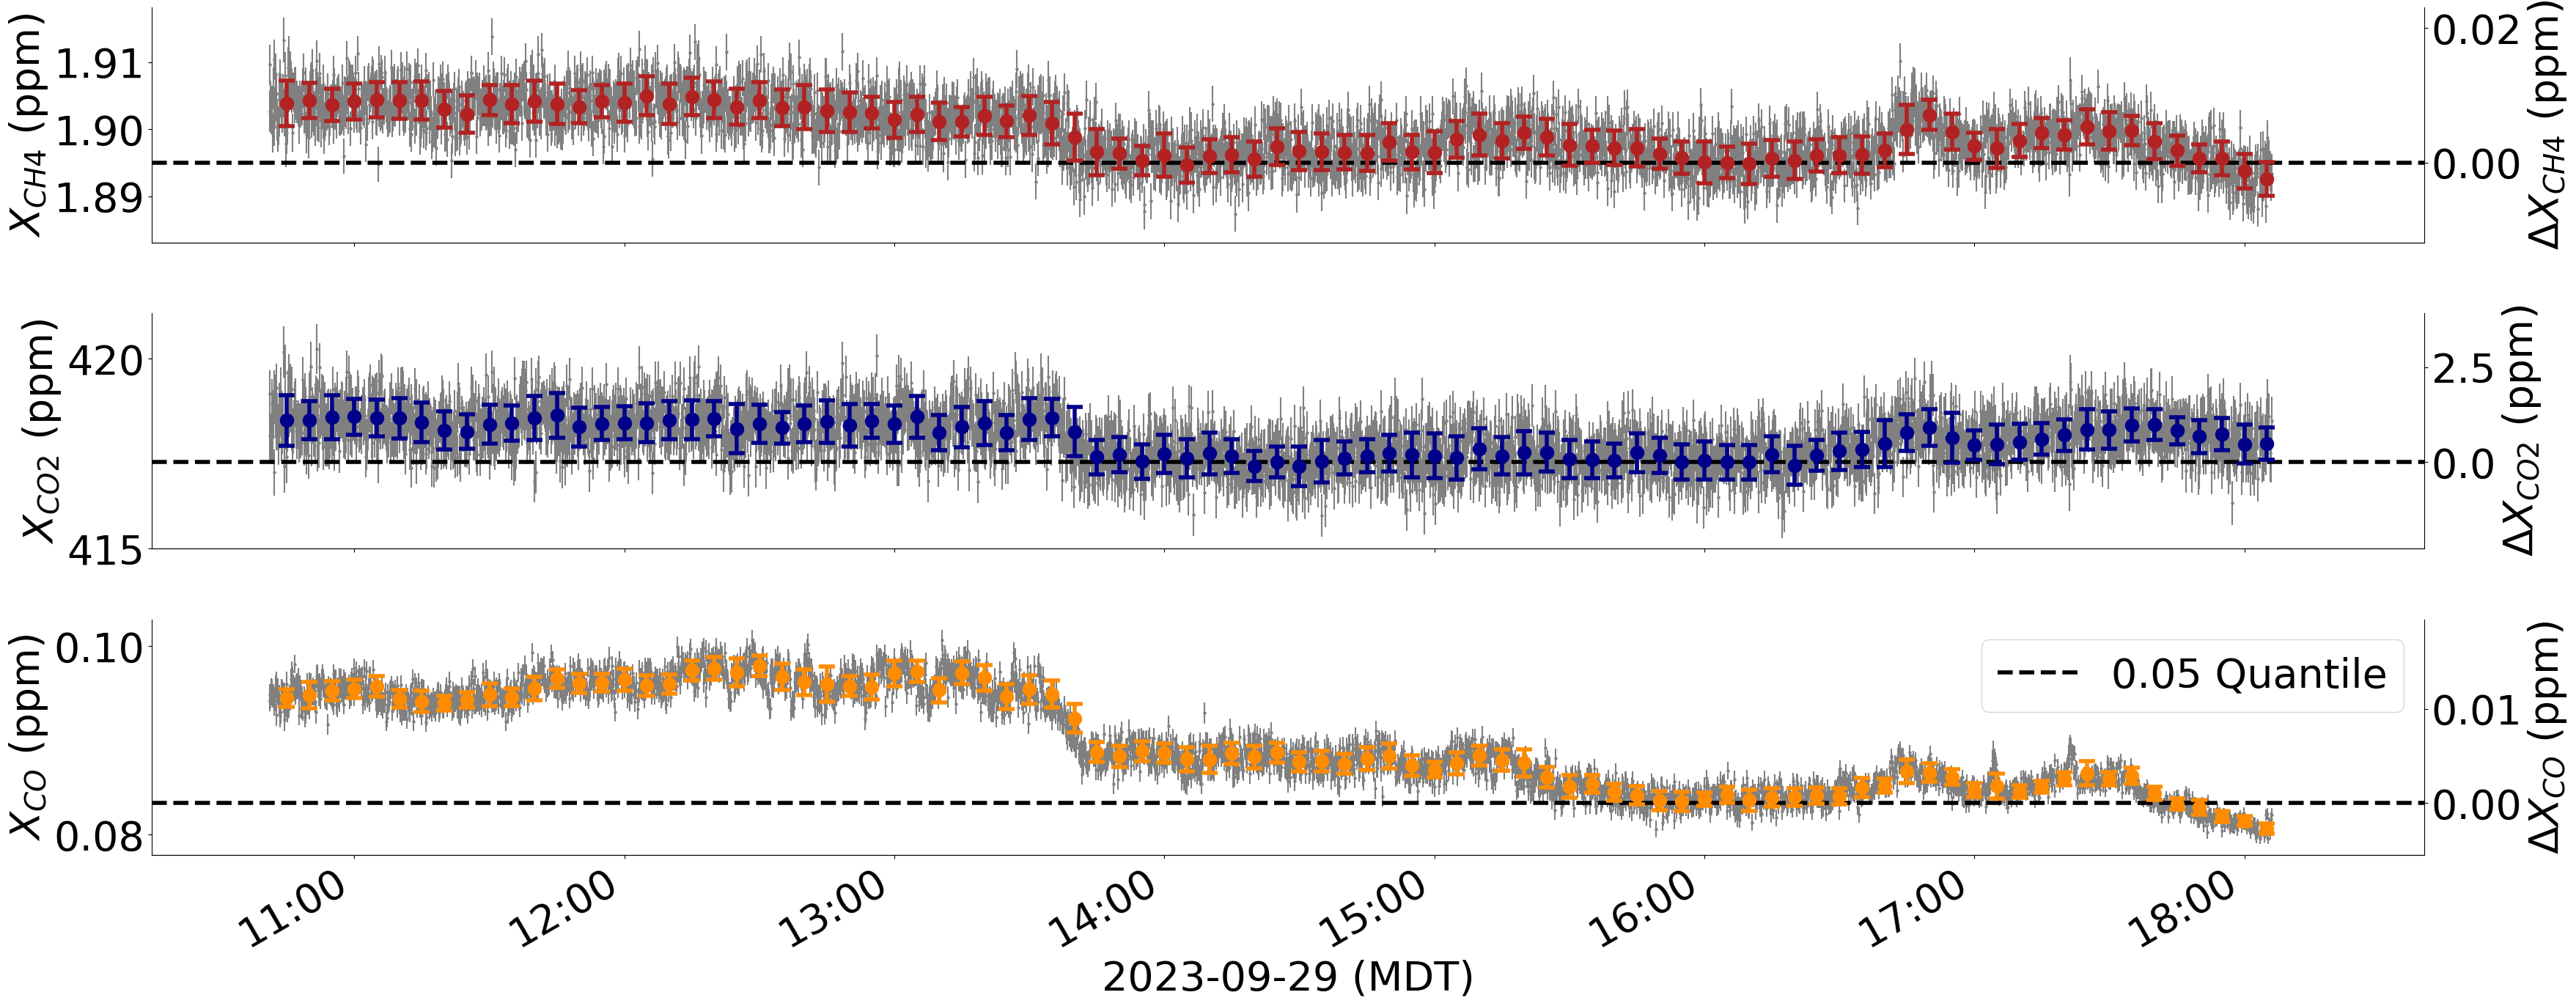

In [34]:
fig_id = f'quantile_example_ts_{date_str}' #Set the figure id
savefig = global_savefig 
showfig = global_showfig

fig,axes = plt.subplots(3,1,figsize = (40,17))
labsize = 40
linewidth = 4
capsize = 8
markeredgewidth = 4

xlims = [quantile_df.index[0]-datetime.timedelta(minutes=30),quantile_df.index[-1]+datetime.timedelta(minutes=30)]

row = 0
axes[row].errorbar(df.index,df['xch4(ppm)'],yerr = df['xch4(ppm)_error'],c = 'grey',fmt='o',markersize=0,zorder = 0)
axes[row].scatter(df.index,df['xch4(ppm)'],s=5,c='grey',zorder = 1)
axes[row].hlines(col_quantiles['xch4(ppm)_wmean'],xmin = xlims[0],xmax = xlims[1],colors = 'black',linestyles = 'dashed',zorder = 3,linewidth = 4)
axes[row].tick_params(labelsize = labsize)
axes[row].set_ylabel(r'$X_{CH4}$ (ppm)',size = labsize)
axes[row].set_xlim(xlims)
axes[row].spines['top'].set_visible(False)
axes[row].spines['right'].set_visible(False)
ax = axes[row].twinx()
ax.errorbar(quantile_df.index, quantile_df['xch4(ppm)_wmean_ex5q'], yerr=quantile_df['xch4(ppm)_wstd'], c='firebrick',
            fmt='o', markersize=10, linewidth=linewidth, zorder=2, capsize=capsize, markeredgewidth=markeredgewidth)
ax.set_ylim(axes[row].get_ylim()[0] - col_quantiles['xch4(ppm)_wmean'], axes[row].get_ylim()[1] - col_quantiles['xch4(ppm)_wmean'])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize = labsize)
ax.set_ylabel(r'${\Delta}X_{CH4}$ (ppm)',size = labsize)

row = 1
axes[row].errorbar(df.index,df['xco2(ppm)'],yerr = df['xco2(ppm)_error'],c = 'grey',fmt='o',markersize=0,zorder = 0)
axes[row].scatter(df.index,df['xco2(ppm)'],s=5,c='grey',zorder = 1)
axes[row].hlines(col_quantiles['xco2(ppm)_wmean'],xmin = xlims[0],xmax = xlims[1],colors = 'black',linestyles = 'dashed',zorder = 3,linewidth = 4)
axes[row].tick_params(labelsize = labsize)
axes[row].set_ylabel(r'$X_{CO2}$ (ppm)',size = labsize)
axes[row].set_xlim(xlims)
axes[row].spines['top'].set_visible(False)
axes[row].spines['right'].set_visible(False)
ax = axes[row].twinx()
ax.errorbar(quantile_df.index, quantile_df['xco2(ppm)_wmean_ex5q'], yerr=quantile_df['xco2(ppm)_wstd'], c='darkblue',
            fmt='o', markersize=10, linewidth=linewidth, zorder=2, capsize=capsize, markeredgewidth=markeredgewidth)
ax.set_ylim(axes[row].get_ylim()[0] - col_quantiles['xco2(ppm)_wmean'], axes[row].get_ylim()[1] - col_quantiles['xco2(ppm)_wmean'])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize = labsize)
ax.set_ylabel(r'${\Delta}X_{CO2}$ (ppm)',size = labsize)

row = 2
axes[row].errorbar(df.index,df['xco(ppm)'],yerr = df['xco(ppm)_error'],c = 'grey',fmt='o',markersize=0,zorder = 0)
axes[row].scatter(df.index,df['xco(ppm)'],s=5,c='grey',zorder = 1)
axes[row].hlines(col_quantiles['xco(ppm)_wmean'],xmin = xlims[0],xmax = xlims[1],colors = 'black',linestyles = 'dashed',zorder = 3,linewidth = 4, label = '0.05 Quantile')
axes[row].tick_params(labelsize = labsize)
axes[row].set_ylabel(r'$X_{CO}$ (ppm)',size = labsize)
axes[row].set_xlim(xlims)
axes[row].spines['top'].set_visible(False)
axes[row].spines['right'].set_visible(False)
axes[row].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz = df.index.tz))
axes[row].set_xlabel(f'{df.index[0].date()} (MDT)',size = labsize)
axes[row].legend(fontsize = labsize,loc = 'upper right')
ax = axes[row].twinx()
ax.errorbar(quantile_df.index, quantile_df['xco(ppm)_wmean_ex5q'], yerr=quantile_df['xco(ppm)_wstd'], c='darkorange',
            fmt='o', markersize=10, linewidth=linewidth, zorder=2, capsize=capsize, markeredgewidth=markeredgewidth)
ax.set_ylim(axes[row].get_ylim()[0] - col_quantiles['xco(ppm)_wmean'], axes[row].get_ylim()[1] - col_quantiles['xco(ppm)_wmean'])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize = labsize)
ax.set_ylabel(r'${\Delta}X_{CO}$ (ppm)',size = labsize)

plt.subplots_adjust(hspace=0.3)
plt.gcf().autofmt_xdate()

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=500,bbox_inches = "tight")
if showfig:
    plt.show()
else:
    plt.close()


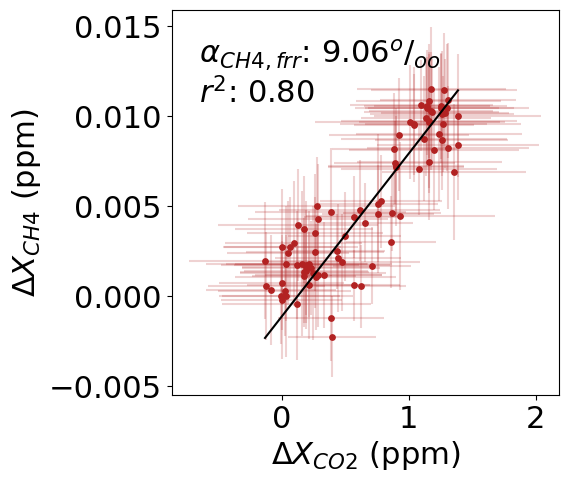

In [35]:
#Calculate and plot regression for quantile data
regr_label = 'ch4_co2'
regr_type = 'york'
err_tag = 'wstd_divak'
fig_id = f'quantile_example_{regr_label}_{date_str}' #Set the figure id

x_name = quantile_regression_outputs[regr_label][err_tag]['details']['x_name']
y_name = quantile_regression_outputs[regr_label][err_tag]['details']['y_name']
x_err_name = quantile_regression_outputs[regr_label][err_tag]['details']['x_err_name']
y_err_name = quantile_regression_outputs[regr_label][err_tag]['details']['y_err_name']
regression_output = regression_utils.york_regression(quantile_df, x_name,y_name,x_err_name,y_err_name) #quantile_regression_outputs[regr_label][err_tag][regr_type]

# Initialize the plotter
plotter = plot_utils.RegressionPlotter(figures_path=inst_figures_path,regr_plot_dict=quantile_regr_plot_dict)
plotter.update_plot_style('ch4_co2',annotate=True)

# Plot using the 'co_co2' label
fig = plotter.plot(
    quantile_df, x_name, y_name, x_err_name, y_err_name,
    regression_output=regression_output,
    fig_id=fig_id,
    regr_label=regr_label,  
    savefig=global_savefig,
    showfig=global_showfig,
    legend_style = {'loc':'upper left','frameon':False},
)

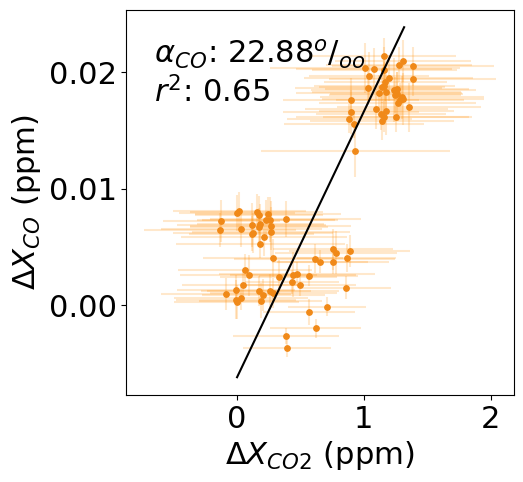

In [36]:
regr_label = 'co_co2'
regr_type = 'york'
err_tag = 'wstd_divak'
fig_id = f'quantile_example_{regr_label}_{date_str}' #Set the figure id

x_name = quantile_regression_outputs[regr_label][err_tag]['details']['x_name']
y_name = quantile_regression_outputs[regr_label][err_tag]['details']['y_name']
x_err_name = quantile_regression_outputs[regr_label][err_tag]['details']['x_err_name']
y_err_name = quantile_regression_outputs[regr_label][err_tag]['details']['y_err_name']
regression_output = regression_utils.york_regression(quantile_df, x_name,y_name,x_err_name,y_err_name) #quantile_regression_outputs[regr_label][err_tag][regr_type]

# Initialize the plotter
plotter = plot_utils.RegressionPlotter(figures_path=inst_figures_path,regr_plot_dict=quantile_regr_plot_dict)
plotter.update_plot_style('co_co2',annotate=True)
# Plot using the 'co_co2' label
fig = plotter.plot(
    quantile_df, x_name, y_name, x_err_name, y_err_name,
    regression_output=regression_output,
    fig_id=fig_id,
    regr_label=regr_label,  
    savefig=global_savefig,
    showfig=global_showfig,
    legend_style = {'loc':'upper left','frameon':False},
)

## Rolling Ratio Illustration (Figures 4, S7)
Ensure that the parmeters are correct for the final selection -- I leave them editable to be able to make figures with different parameters.

In [37]:
oof_resample = '5min' #the resample interval of the EM27 data
min_obs = compute_min_obs(oof_dt_raw,oof_resample,pct_required)
resample_with_stats_kwargs = {'min_obs':min_obs}

regr_resample = '5min'
rolling_window = '90min'
resample_eq_or_all = 'all'

rolling_regr_params = {'regr_labels': {'ch4_co2':{'x_name':f'xco2(ppm)_wmean_ex{q}q_divak',
                                           'y_name':f'xch4(ppm)_wmean_ex{q}q_divak',
                                           'x_err_name':f'xco2(ppm)_wstd_divak',
                                           'y_err_name':f'xch4(ppm)_wstd_divak',
                                           'permil':True},
                                'co_co2': {'x_name':f'xco2(ppm)_wmean_ex{q}q_divak',
                                           'y_name':f'xco(ppm)_wmean_ex{q}q_divak',
                                           'x_err_name':f'xco2(ppm)_wstd_divak',
                                           'y_err_name':f'xco(ppm)_wstd_divak',
                                           'permil':True},
                                        },    
                    'regr_type_details':{'ols': ['slope','intercept','r','r_squared','R_squared'],
                                         'york': ['slope','intercept','r','r_squared','R_squared','S','se_slope'],
                                         'odr': ['slope','intercept','r','r_squared','R_squared','chi_squared','sd_slope'],
                    },
                }

rolling_regr_filters = {
    'ch4_co2':{
        'window_nobs': ('>=',10),
        'ch4_co2_york_r_squared': ('>',0.8),
        'xco2(ppm)_wmean_ex5q_divak_range': ('>',0.5),
        'xco2(ppm)_wmean_ex5q_divak_time_diff': ('>',0)
    },
    'co_co2':{
        'window_nobs': ('>',10),
        'co_co2_york_r_squared': ('>',0.8),
        'xco2(ppm)_wmean_ex5q_divak_range': ('>',0.5),
        'xco2(ppm)_wmean_ex5q_divak_time_diff': ('>',0)
    }
}
grouping_details = {
    'tdelta':pd.to_timedelta(regr_resample)*3,
    'nratio_good_thresh': 3,
}

2023-03-17


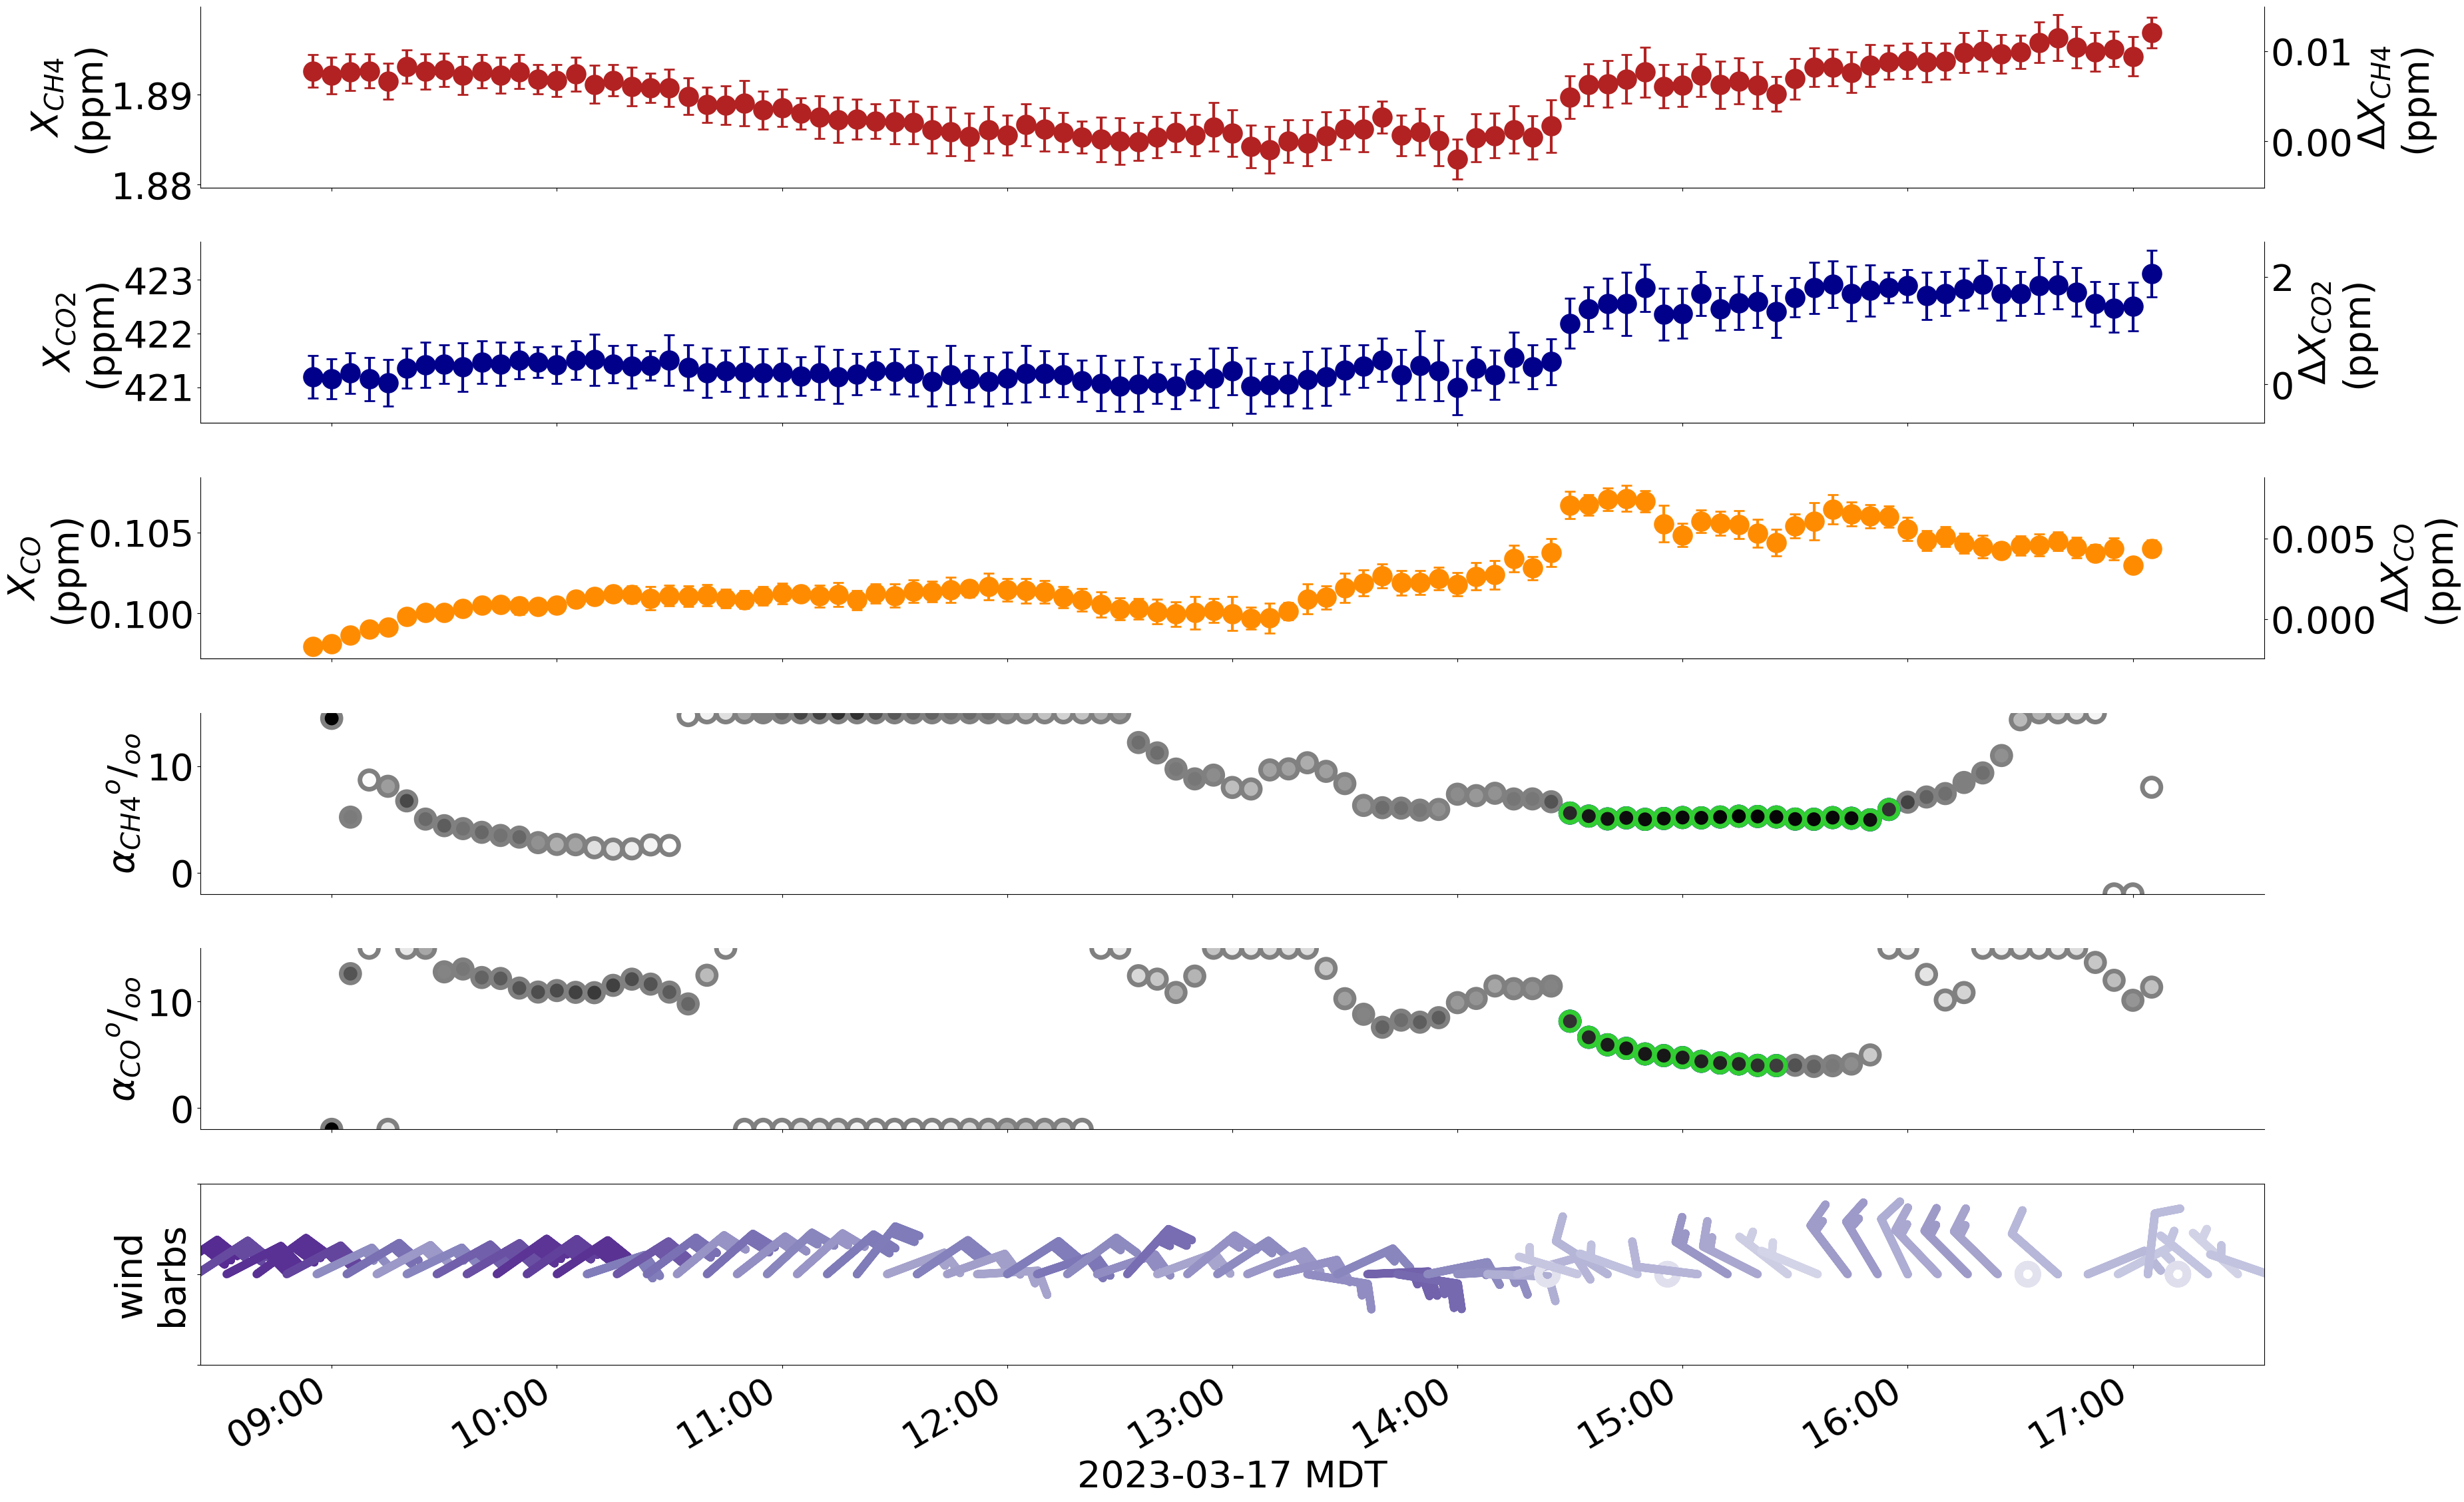

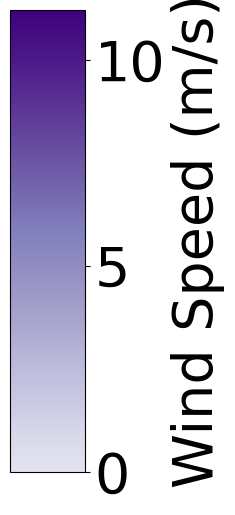

In [38]:
# This is a loop over days to create daily plots of the rolling regression results, so that you could create all of the daily plots in one go if you wanted. 
# However, if you choose single date string, it will only do that date.

single_date_str = '2023-03-17' #'2023-09-29' #2025-01-22
savefig = global_savefig 
showfig = global_showfig
for date_str in daily_oof_dict.keys():
    try:
        if single_date_str is not None:
            if date_str != single_date_str:
                continue
        print(date_str)
        day_dfs = get_day_dfs(daily_oof_dict,daily_met_dict,ak_df,date_str,gases,oof_resample,oof_background_quantile,oof_filter_dict,resample_with_stats_kwargs = resample_with_stats_kwargs)
        #rolling_regr_df = rolling_regression_creator(day_dfs['quantile_df'],rolling_regr_params,rolling_window,regr_resample=regr_resample,resample_eq_or_all = resample_eq_or_all)
        #rolling_regr_df = add_filter_and_group_cols(rolling_regr_df, rolling_regr_filters, grouping_details)
        rolling_regr_df = pd.read_parquet(os.path.join(inst_data_path,'rolling',f'all_rolling_regr_5minres_90minwin.parquet'))
        rolling_regr_df = rolling_regr_df[rolling_regr_df.index.date == pd.to_datetime(date_str).date()]
        rolling_regr_df = add_filter_and_group_cols(rolling_regr_df, rolling_regr_filters, grouping_details)

        fig_id = os.path.join('rolling_ratio_tss',f"{date_str}") #Set the figure id

        fig,axes = plt.subplots(6,1,figsize = (40,30))

        labsize = 40
        marker_size = 20
        xlims = [rolling_regr_df.index[0]-datetime.timedelta(minutes=30),rolling_regr_df.index[-1]+datetime.timedelta(minutes=30)]
        quantile_df = day_dfs['quantile_df']
        col_quantiles = day_dfs['col_quantiles']

        row = 0
        y_name = 'xch4(ppm)_wmean'
        y_err_name = 'xch4(ppm)_wstd'
        axes[row].errorbar(quantile_df.index, quantile_df[y_name], yerr=quantile_df[y_err_name], c='firebrick', 
        fmt='o', markersize=marker_size, linewidth=3, zorder=2, capsize=6, markeredgewidth=2)
        axes[row].tick_params(labelsize=labsize)
        axes[row].set_ylabel(r'$X_{CH4}$'+'\n(ppm)', size=labsize)
        axes[row].set_xlim(xlims)
        axes[row].spines['top'].set_visible(False)
        axes[row].spines['right'].set_visible(False)
        ax2 = axes[row].twinx()
        ax2.set_ylim(axes[row].get_ylim()[0] - col_quantiles[y_name], axes[row].get_ylim()[1] - col_quantiles[y_name])
        ax2.spines['top'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.tick_params(labelsize=labsize)
        ax2.set_ylabel(r'${\Delta}X_{CH4}$'+'\n(ppm)', size=labsize)

        row = 1
        y_name = 'xco2(ppm)_wmean'
        y_err_name = 'xco2(ppm)_wstd'
        axes[row].errorbar(quantile_df.index, quantile_df[y_name], yerr=quantile_df[y_err_name], c='darkblue', 
        fmt='o', markersize=marker_size, linewidth=3, zorder=2, capsize=6, markeredgewidth=2)
        axes[row].tick_params(labelsize=labsize)
        axes[row].set_ylabel(r'$X_{CO2}$'+'\n(ppm)', size=labsize)
        axes[row].set_xlim(xlims)
        axes[row].spines['top'].set_visible(False)
        axes[row].spines['right'].set_visible(False)
        ax2 = axes[row].twinx()
        ax2.set_ylim(axes[row].get_ylim()[0] - col_quantiles[y_name], axes[row].get_ylim()[1] - col_quantiles[y_name])
        ax2.spines['top'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.tick_params(labelsize=labsize)
        ax2.set_ylabel(r'${\Delta}X_{CO2}$'+'\n(ppm)', size=labsize)

        row = 2
        y_name = 'xco(ppm)_wmean'
        y_err_name = 'xco(ppm)_wstd'
        axes[row].errorbar(quantile_df.index, quantile_df[y_name], yerr=quantile_df[y_err_name], c='darkorange', 
        fmt='o', markersize=marker_size, linewidth=3, zorder=2, capsize=6, markeredgewidth=2)
        axes[row].tick_params(labelsize=labsize)
        axes[row].set_ylabel(r'$X_{CO}$'+'\n(ppm)', size=labsize)
        axes[row].set_xlim(xlims)
        axes[row].spines['top'].set_visible(False)
        axes[row].spines['right'].set_visible(False)
        ax2 = axes[row].twinx()
        ax2.set_ylim(axes[row].get_ylim()[0] - col_quantiles[y_name], axes[row].get_ylim()[1] - col_quantiles[y_name])
        ax2.spines['top'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.tick_params(labelsize=labsize)
        ax2.set_ylabel(r'${\Delta}X_{CO}$'+'\n(ppm)', size=labsize)

        row = 3
        regr_label = 'ch4_co2'
        regr_type = 'york'
        marker_size = 400
        marker_lw = 5
        ax = axes[row]
        plot_utils.ratio_ts_plot(ax,rolling_regr_df,rolling_regr_params,regr_label,regr_type,labsize,marker_size,marker_lw,ylims=[-2,15])
        ax.set_ylabel(r'${\alpha}_{CH4}$'+"$^o/_{oo}$" , size=labsize)
        ax.set_xlim(xlims)

        row = 4
        regr_label = 'co_co2'
        regr_type = 'york'
        ax = axes[row]
        plot_utils.ratio_ts_plot(ax,rolling_regr_df,rolling_regr_params,regr_label,regr_type,labsize,marker_size,marker_lw,ylims=[-2,15])
        ax.set_ylabel(r'${\alpha}_{CO}$'+"$^o/_{oo}$" , size=labsize)
        ax.set_xlim(xlims)

        row = 5
        ax = axes[row]
        windmode = 8
        wind_cmap = plot_utils.truncate_colormap(matplotlib.colormaps['Purples'], 0.2, 1)
        barbs = ax.barbs(day_dfs['met_df'][::windmode].index,0,day_dfs['met_df']['u'][::windmode],day_dfs['met_df']['v'][::windmode],
                        day_dfs['met_df']['ws'][::windmode],cmap = wind_cmap,length =11.5,linewidth = 9,barb_increments={'half':1,'full':3,'flag':10})
        ax.tick_params(labelsize = labsize)
        ax.set_ylabel('wind\nbarbs',size = labsize)
        ax.get_yaxis().set_ticklabels([])
        ax.set_ylim(-1,1)
        ax.set_xlim(xlims)

        axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz = quantile_df.index.tz))
        axes[-1].set_xlabel(f"{datetime.datetime.strftime(quantile_df.index[0],'%Y-%m-%d %Z')}",size = labsize)#)day_dfs['resampled_oof'][0].index.tz))


        plt.subplots_adjust(hspace=0.3)
        plt.gcf().autofmt_xdate()

        if savefig:
            fig_name = f'{fig_id}.png'
            fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=200,bbox_inches = "tight")
        if showfig:
            plt.show()
        else:
            plt.close()

        # Create a standalone figure for the colorbar
        fig, ax = plt.subplots(figsize=(2, 6))
        fig.subplots_adjust(right=0.5)
        cbar = fig.colorbar(barbs, cax=ax)
        cbar.set_label('Wind Speed (m/s)', size=labsize)
        cbar.ax.tick_params(labelsize=labsize)

        if savefig:
            fig_name = f'{fig_id}_windcolorbar.png'
            fig.savefig(os.path.join(inst_figures_path, fig_name), dpi=500, bbox_inches="tight")
        if showfig:
            plt.show()
        else:
            plt.close()

        # # Create a standalone figure for the r^2 colorbar
        # fig, ax = plt.subplots(figsize=(2, 6))
        # fig.subplots_adjust(left=0.4, right=0.6)

        # cmap = plt.cm.Greys
        # norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
        # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        # sm.set_array([])
        # cbar = fig.colorbar(sm, cax=ax)
        # cbar.set_label(r'$r^2$', size=labsize*1.5)
        # cbar.ax.tick_params(labelsize=labsize*1.5)
        # cbar.set_ticks([0, 1])
        # if savefig:
        #     fig_name = f'{fig_id}_r2colorbar.png'
        #     fig.savefig(os.path.join(inst_figures_path, fig_name), dpi=500, bbox_inches="tight")
        # if showfig:
        #     plt.show()
        # else:
        #     plt.close()
    except Exception as e:
        print(f"Error in {date_str}: {e}")
        continue

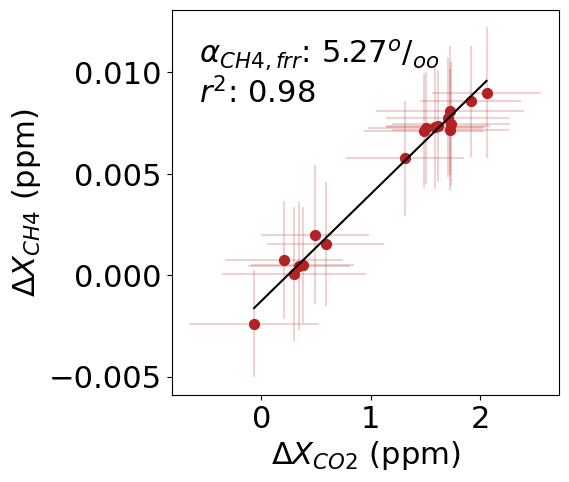

{'slope': 0.005268034112850164,
 'intercept': -0.0012589421951985464,
 'r': 0.991602773171072,
 'r_squared': 0.9832760597605605,
 'R_squared': 0.9832184701210939,
 'S': 0.23489847080340423,
 'se_slope': 0.0014024743037898467}

In [39]:
# Here you can set a specific date and time to look at the rolling regression results in more detail

window_dt = pd.to_datetime(f'{single_date_str} 15:20:00').tz_localize('America/Denver') #Set the window date and time
#window_dt = pd.to_datetime(f'{single_date_str} 10:30:00').tz_localize('America/Denver') #Set the window date and time
#window_dt = pd.to_datetime(f'{single_date_str} 14:20:00').tz_localize('America/Denver') #Set the window date and time

regr_label = 'ch4_co2'
regr_type = 'york'
err_tag = 'wstd_divak'
fig_id = f"rolling_example_{regr_label}_{window_dt.strftime('%Y%m%d_%H%M%S')}" #Set the figure id

full_df = day_dfs['quantile_df']
window_df = get_window_df(full_df,window_dt,rolling_window,'before')

#window_df = window_df.sample(10)

window_regr_out = get_regressions(window_df,rolling_regr_params,regr_type,rolling_regr_params['regr_type_details'][regr_type])
regression_output = window_regr_out[regr_label]
x_name = rolling_regr_params['regr_labels'][regr_label]['x_name']
y_name = rolling_regr_params['regr_labels'][regr_label]['y_name']
x_err_name = rolling_regr_params['regr_labels'][regr_label]['x_err_name']
y_err_name = rolling_regr_params['regr_labels'][regr_label]['y_err_name']


# Initialize the plotter
plotter = plot_utils.RegressionPlotter(figures_path=inst_figures_path,regr_plot_dict=quantile_regr_plot_dict)
plotter.update_plot_style('ch4_co2', scatter_style= {"s": 50})
plotter.update_plot_style('co_co2', scatter_style= {"s": 50})
plotter.update_plot_style('ch4_co2',annotate=True)

# Plot using the 'co_co2' label
fig = plotter.plot(
    window_df, x_name, y_name, x_err_name, y_err_name,
    regression_output=regression_output,
    fig_id=fig_id,
    regr_label=regr_label,  
    savefig=global_savefig,
    showfig=global_showfig,
    legend_style={'loc':'upper left','frameon':False},
)
regression_output

### Monte Carlo, points per window (Figure S15)

In [40]:
def monte_carlo_regressions(window_df, regr_label, regr_params, regr_type, n_iter=200):
    """Perform Monte Carlo regressions by sampling different numbers of points from the window_df.
    
    Args:
        window_df (pd.DataFrame): DataFrame containing the data for regression.
        regr_label (str): Label for the regression (e.g., 'ch4_co2').
        regr_params (dict): Dictionary containing regression parameters.
        regr_type (str): Type of regression to perform (e.g., 'york').
        n_iter (int): Number of iterations for each sample size.        
        
    Returns:
        pd.DataFrame: DataFrame containing regression results for each sample size and iteration.
    """
    
    outs = []

    # loop over possible sample sizes
    for npoints in range(2, len(window_df) + 1):
        #print(npoints)
        for i in range(n_iter):
            df = window_df.sample(npoints, replace=False)

            # run regression
            window_regr_out = get_regressions(
                df,
                regr_params,
                regr_type,
                regr_params['regr_type_details'][regr_type]
            )
            regression_output = window_regr_out[regr_label]

            outs.append({
                'npoints': npoints,
                'slope': regression_output['slope'],
                'se_slope': regression_output['se_slope'],
                'r_squared': regression_output['r_squared']
            })

    return pd.DataFrame(outs)


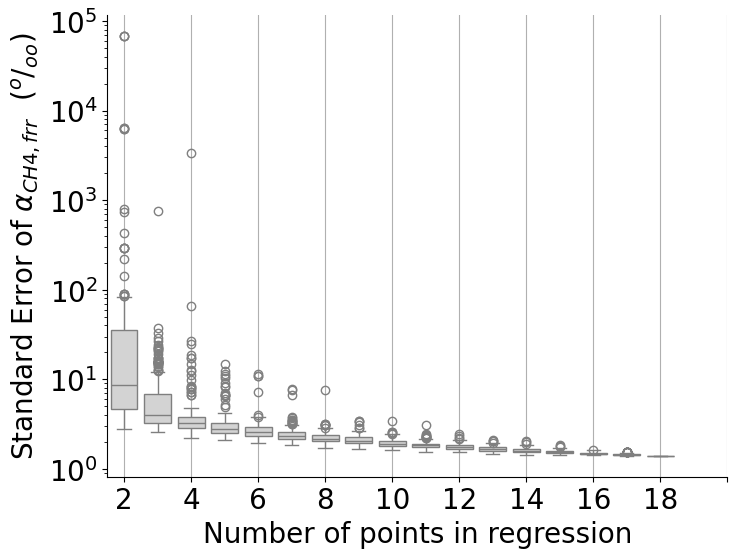

In [41]:
save_fig = global_savefig
show_fig = global_showfig

regr_label = 'ch4_co2'
fig_id = f'monte_carlo_se_slope_{regr_label}_{window_dt.strftime("%Y%m%d_%H%M%S")}'  # Set the figure id
labsize = 20

# Get window data
window_df = get_window_df(full_df, window_dt, rolling_window, 'before')

# Run Monte Carlo regressions
mc_results = monte_carlo_regressions(
    window_df,
    regr_label=regr_label,
    regr_params=rolling_regr_params,
    regr_type='york',
    n_iter=200
)

# Scale SE slope for plotting
mc_results_plot = mc_results.copy()
mc_results_plot["se_slope_scaled"] = mc_results_plot["se_slope"] * 1000

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=mc_results_plot,
    x="npoints",
    y="se_slope_scaled",
    ax=ax,
    color="lightgrey"
)

ax.set_yscale("log")
ax.set_xlabel("Number of points in regression", size=labsize)
ax.set_ylabel(r"Standard Error of $\alpha_{CH4,frr}$  ($^o/_{oo}$)", size=labsize)
ax.tick_params(labelsize=labsize)
ax.set_xticks(np.arange(0, len(window_df) + 1, 2))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(True)

plt.subplots_adjust(hspace=0.2)

# Save or show
if save_fig:
    fig_name = f"{fig_id}.png"
    fig.savefig(os.path.join(inst_figures_path, fig_name), dpi=500, bbox_inches="tight")
if show_fig:
    plt.show()
else:
    plt.close()

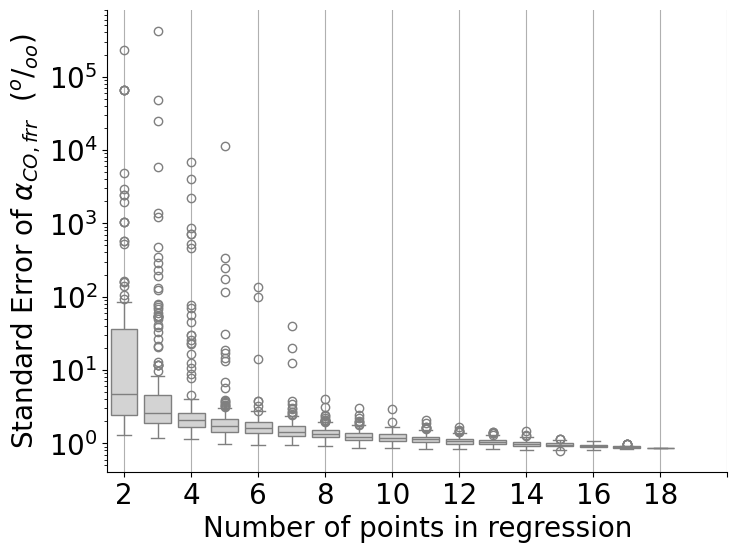

In [42]:
save_fig = global_savefig
show_fig = global_showfig

regr_label = 'co_co2'
fig_id = f'monte_carlo_se_slope_{regr_label}_{window_dt.strftime("%Y%m%d_%H%M%S")}'  # Set the figure id
labsize = 20

# Get window data
window_df = get_window_df(full_df, window_dt, rolling_window, 'before')

# Run Monte Carlo regressions
mc_results = monte_carlo_regressions(
    window_df,
    regr_label=regr_label,
    regr_params=rolling_regr_params,
    regr_type='york',
    n_iter=200
)

# Scale SE slope for plotting
mc_results_plot = mc_results.copy()
mc_results_plot["se_slope_scaled"] = mc_results_plot["se_slope"] * 1000

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(
    data=mc_results_plot,
    x="npoints",
    y="se_slope_scaled",
    ax=ax,
    color="lightgrey"
)

ax.set_yscale("log")
ax.set_xlabel("Number of points in regression", size=labsize)
ax.set_ylabel(r"Standard Error of $\alpha_{CO,frr}$  ($^o/_{oo}$)", size=labsize)
ax.tick_params(labelsize=labsize)
ax.set_xticks(np.arange(0, len(window_df) + 1, 2))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(True)

plt.subplots_adjust(hspace=0.2)

# Save or show
if save_fig:
    fig_name = f"{fig_id}.png"
    fig.savefig(os.path.join(inst_figures_path, fig_name), dpi=500, bbox_inches="tight")
if show_fig:
    plt.show()
else:
    plt.close()

### Window ratio comparisons (Figure S12, S13)

In [43]:
window_dt = pd.to_datetime(f'{single_date_str} 10:30:00-06:00')
#window_dt = pd.to_datetime(f'{single_date_str} 15:20:00-06:00')

regr_label = 'ch4_co2'
regr_type = 'york'
err_tag = 'wstd_divak'
fig_id = f"rolling_example_{regr_label}_{window_dt.strftime('%Y%m%d_%H%M%S')}_regr_comparison" #Set the figure id

full_df = day_dfs['quantile_df']
window_df = get_window_df(full_df,window_dt,rolling_window,'before')

x_name = rolling_regr_params['regr_labels'][regr_label]['x_name']
y_name = rolling_regr_params['regr_labels'][regr_label]['y_name']
x_err_name = rolling_regr_params['regr_labels'][regr_label]['x_err_name']
y_err_name = rolling_regr_params['regr_labels'][regr_label]['y_err_name']

window_regr_out = regression_utils.calculate_all_regressions(window_df,x_name,y_name,err_tags)
regression_output = window_regr_out[err_tag]
df = window_df.copy()

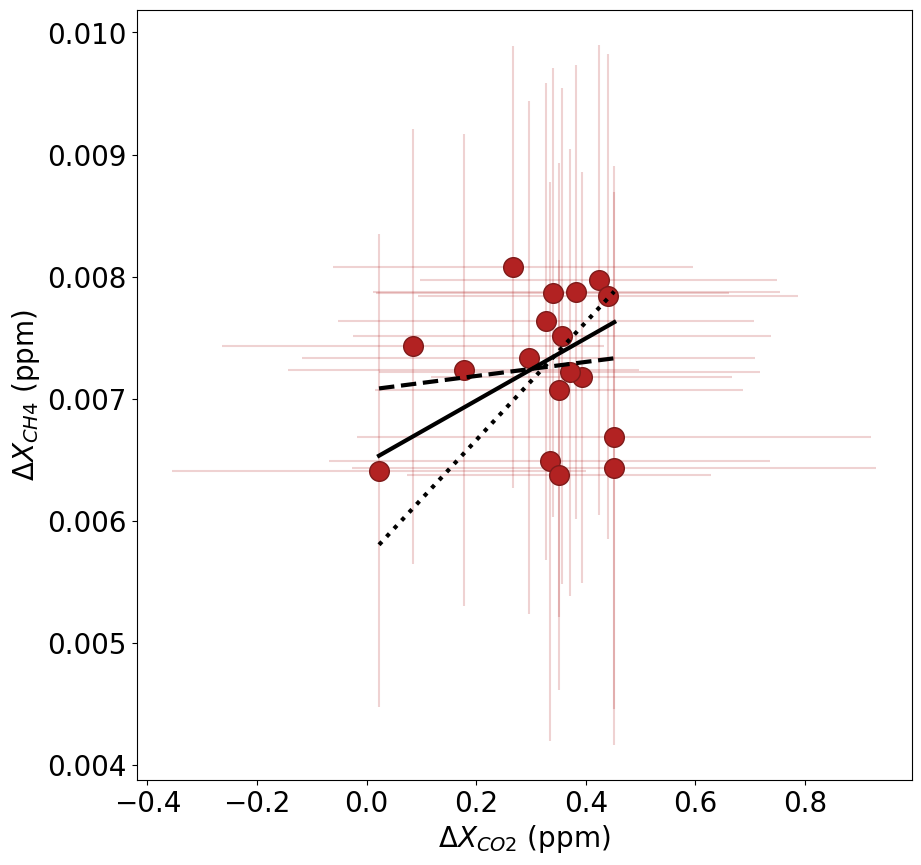

In [44]:
savefig = global_savefig
showfig = global_showfig
fig, ax = plt.subplots(1, 1, figsize=(10,10))

x_min, x_max = df[x_name].min(), df[x_name].max()
y_min, y_max = df[y_name].min(), df[y_name].max()

ax.errorbar(df[x_name], df[y_name], xerr=df[x_err_name], yerr=df[y_err_name], c='firebrick', markersize=0, zorder=1, linestyle='none',alpha=0.2)
ax.scatter(df[x_name], df[y_name], s=200, c='firebrick', zorder=2,edgecolors ='#7e1b1a')

outs = regression_output['york']
slope = outs['slope']
intercept = outs['intercept']
xline = np.linspace(x_min, x_max, 100)
yline = slope * xline + intercept
ax.plot(xline, yline, c='k', linewidth=3, linestyle='-', zorder=3,label = 'York')

outs = regression_output['ols']
slope = outs['slope']
intercept = outs['intercept']
xline = np.linspace(x_min, x_max, 100)
yline = slope * xline + intercept
ax.plot(xline, yline, c='k', linewidth=3, linestyle='--', zorder=3,label = 'OLS')

outs = regression_output['rma']
slope = outs['slope']
intercept = outs['intercept']
xline = np.linspace(x_min, x_max, 100)
yline = slope * xline + intercept
ax.plot(xline, yline, c='k', linewidth=3, linestyle='dotted', zorder=3,label = 'RMA')

ax.set_xlabel(r'${\Delta}X_{CO2}$' + ' (ppm)', size=labsize)
ax.set_ylabel(r'${\Delta}X_{CH4}$' + ' (ppm)', size=labsize)
ax.tick_params(labelsize=labsize)

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=500,bbox_inches = "tight")
if showfig:
    plt.show()
else:
    plt.close()


### Full day with selected periods (Figure 10)

In [45]:
date_str = '2025-01-22'
day_dfs = get_day_dfs(daily_oof_dict,daily_met_dict,ak_df,date_str,gases,oof_resample,oof_background_quantile,oof_filter_dict,resample_with_stats_kwargs = resample_with_stats_kwargs)
rolling_regr_df = rolling_regression_creator(day_dfs['quantile_df'],rolling_regr_params,rolling_window,regr_resample=regr_resample,resample_eq_or_all = resample_eq_or_all)
rolling_regr_df = add_filter_and_group_cols(rolling_regr_df, rolling_regr_filters, grouping_details)

In [46]:
# Splitting up into the time periods of interest

# Select only pass-filter points
pass_filter_df = rolling_regr_df.loc[rolling_regr_df['ch4_co2_pass_filter']]

# Build a mask for all times within 1h before pass-filter points
mask = pd.Series(False, index=rolling_regr_df.index)

for t in pass_filter_df.index:
    mask |= (rolling_regr_df.index >= t - pd.Timedelta(hours=1.5)) & (rolling_regr_df.index <= t)

# All times of interest (pre-window + filter points)
combined_df = rolling_regr_df.loc[mask].sort_index()

# Split into consecutive chunks if gap > 5 minutes
split_dfs = [
    g for _, g in combined_df.groupby(
        (combined_df.index.to_series().diff().dt.total_seconds() / 60 > 30).cumsum()
    )
]

# For plotting
nopass_filter_df = rolling_regr_df.loc[~rolling_regr_df['ch4_co2_pass_filter']]

pass_filter_dfs = [
    g for _, g in pass_filter_df.groupby(
        (pass_filter_df.index.to_series().diff().dt.total_seconds() / 60 > 5).cumsum()
    )
]

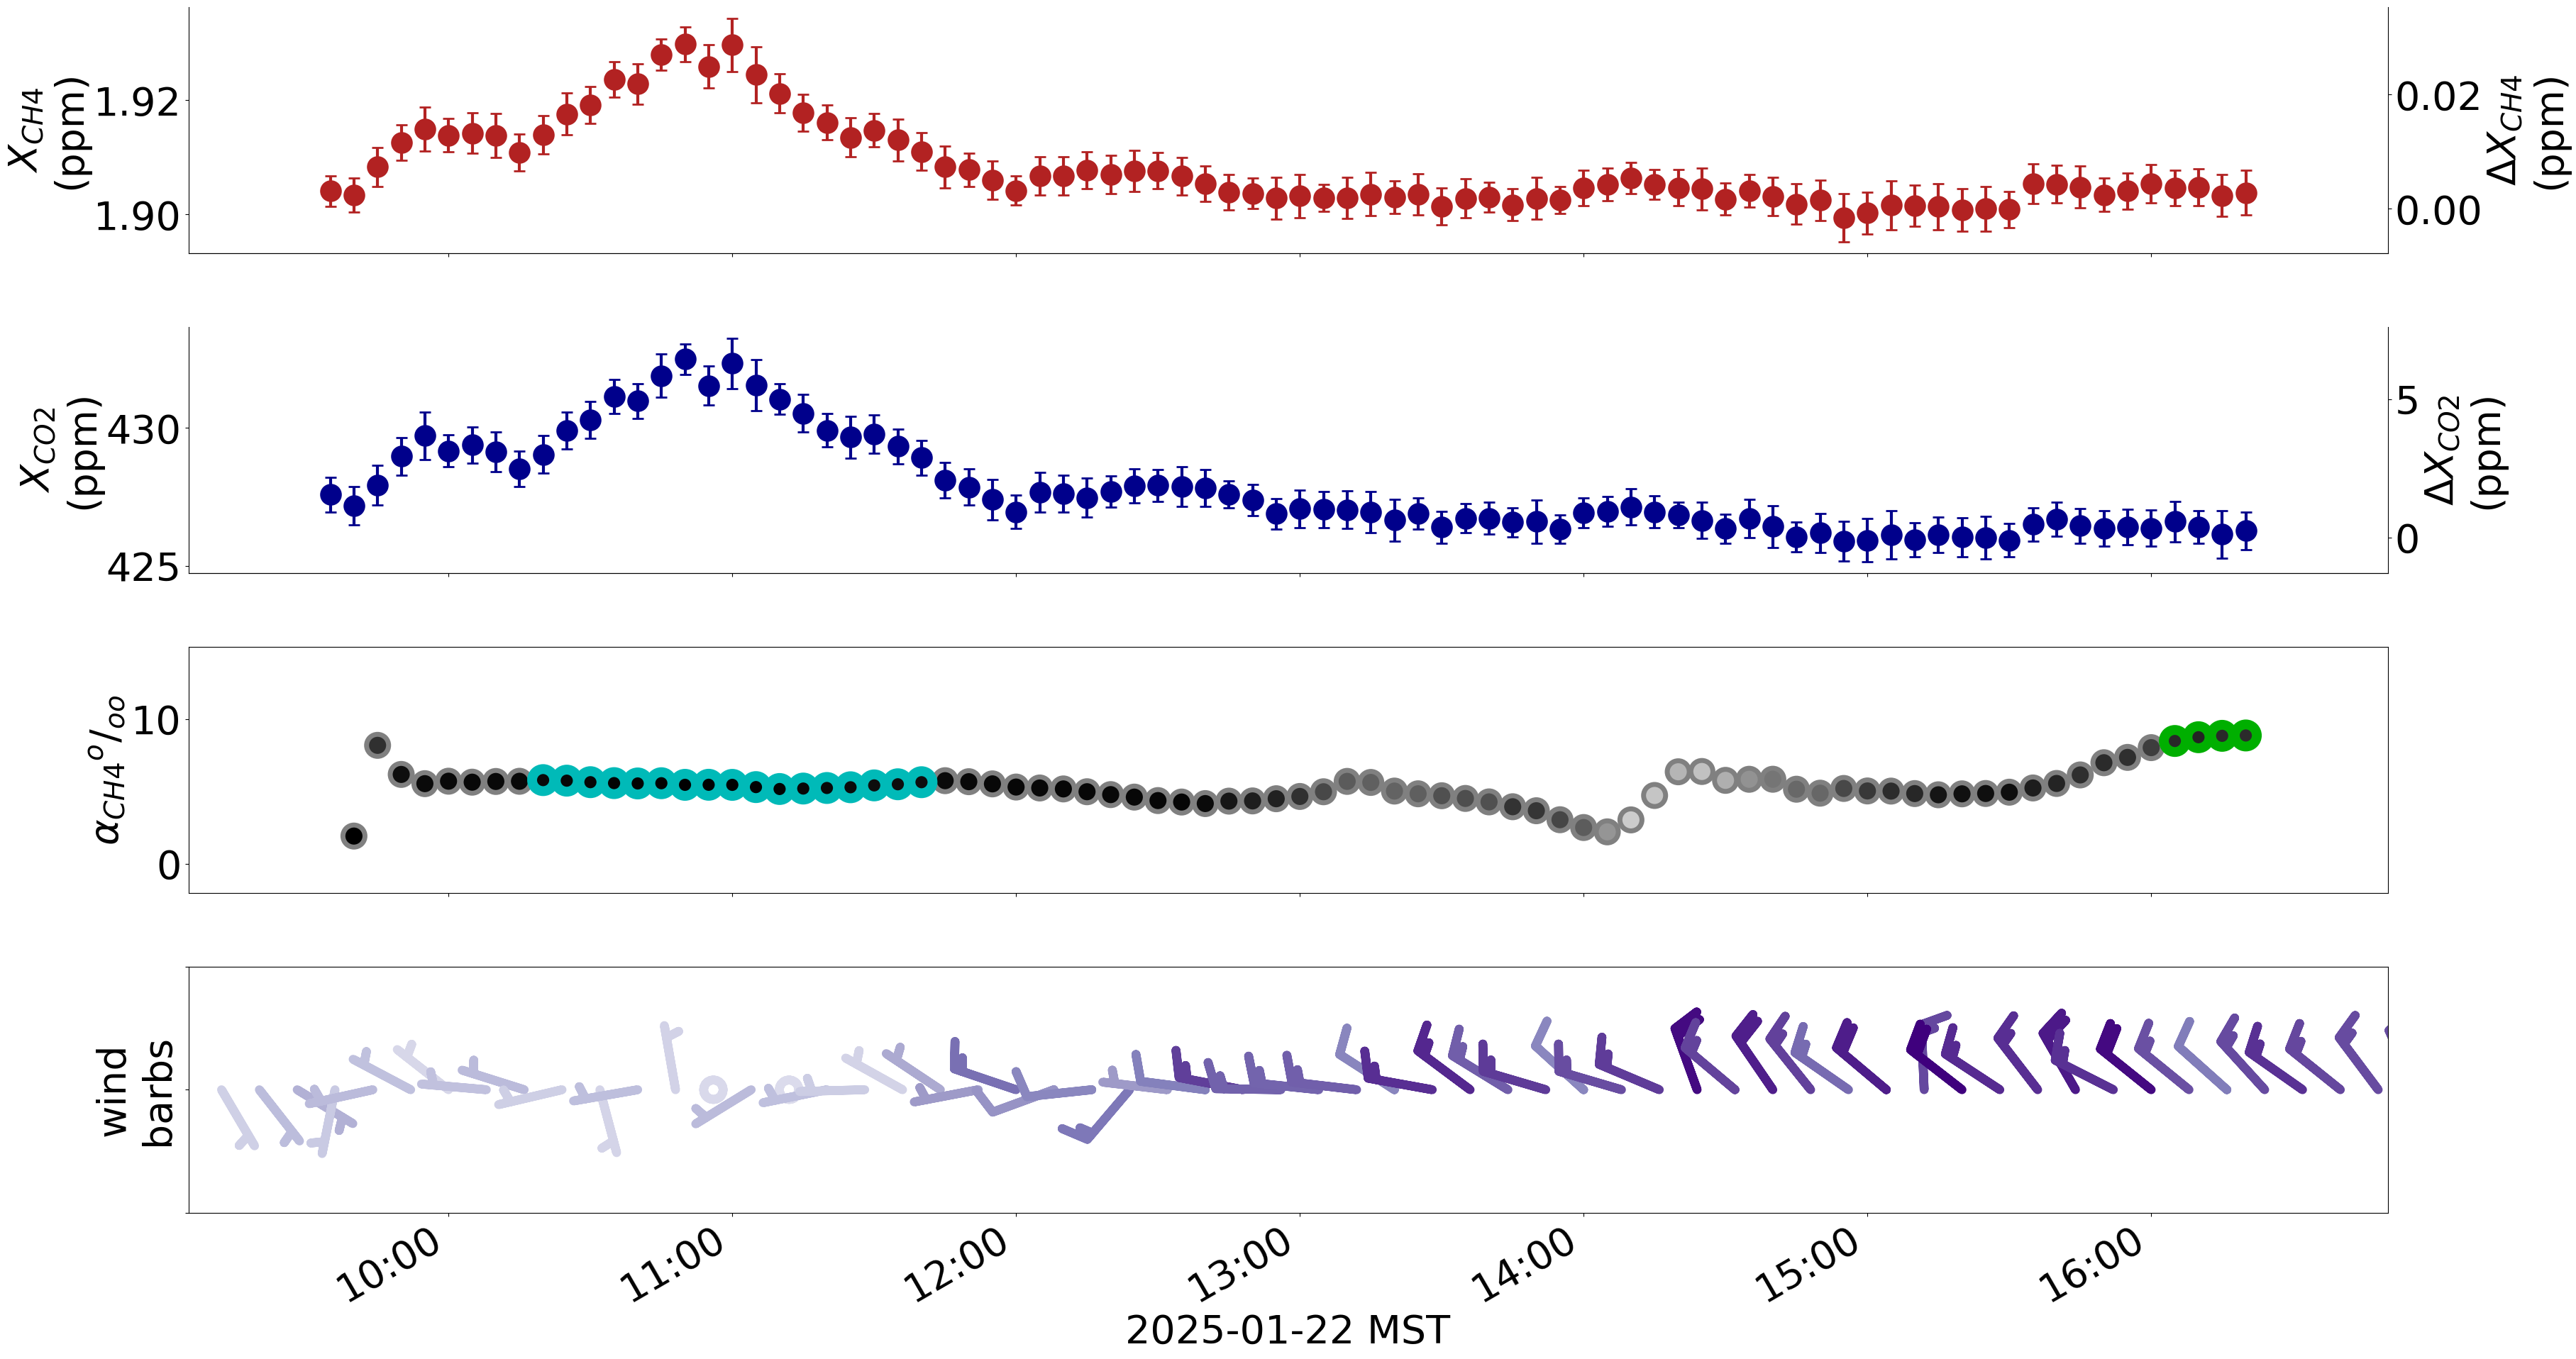

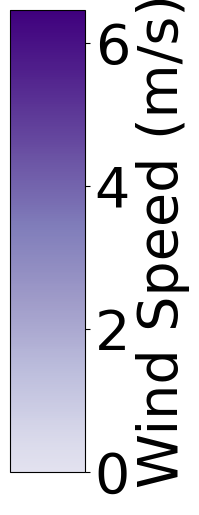

In [47]:
savefig = global_savefig
showfig = global_showfig 

fig_id = f'rolling_ratio_tss_mini_{date_str}' #Set the figure id

#fig,axes = plt.subplots(6,1,figsize = (40,30))
fig,axes = plt.subplots(4,1,figsize = (40,25))

labsize = 40
marker_size = 20
xlims = [rolling_regr_df.index[0]-datetime.timedelta(minutes=30),rolling_regr_df.index[-1]+datetime.timedelta(minutes=30)]
quantile_df = day_dfs['quantile_df']
col_quantiles = day_dfs['col_quantiles']

row = 0
y_name = 'xch4(ppm)_wmean'
y_err_name = 'xch4(ppm)_wstd'
axes[row].errorbar(quantile_df.index, quantile_df[y_name], yerr=quantile_df[y_err_name], c='firebrick', 
fmt='o', markersize=marker_size, linewidth=3, zorder=2, capsize=6, markeredgewidth=2)
axes[row].tick_params(labelsize=labsize)
axes[row].set_ylabel(r'$X_{CH4}$'+'\n(ppm)', size=labsize)
axes[row].set_xlim(xlims)
axes[row].spines['top'].set_visible(False)
axes[row].spines['right'].set_visible(False)
ax2 = axes[row].twinx()
ax2.set_ylim(axes[row].get_ylim()[0] - col_quantiles[y_name], axes[row].get_ylim()[1] - col_quantiles[y_name])
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(labelsize=labsize)
ax2.set_ylabel(r'${\Delta}X_{CH4}$'+'\n(ppm)', size=labsize)

row = 1
y_name = 'xco2(ppm)_wmean'
y_err_name = 'xco2(ppm)_wstd'
axes[row].errorbar(quantile_df.index, quantile_df[y_name], yerr=quantile_df[y_err_name], c='darkblue', 
fmt='o', markersize=marker_size, linewidth=3, zorder=2, capsize=6, markeredgewidth=2)
axes[row].tick_params(labelsize=labsize)
axes[row].set_ylabel(r'$X_{CO2}$'+'\n(ppm)', size=labsize)
axes[row].set_xlim(xlims)
axes[row].spines['top'].set_visible(False)
axes[row].spines['right'].set_visible(False)
ax2 = axes[row].twinx()
ax2.set_ylim(axes[row].get_ylim()[0] - col_quantiles[y_name], axes[row].get_ylim()[1] - col_quantiles[y_name])
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(labelsize=labsize)
ax2.set_ylabel(r'${\Delta}X_{CO2}$'+'\n(ppm)', size=labsize)


row = 2#3
regr_label = 'ch4_co2'
regr_type = 'york'
marker_size = 500
marker_lw = 10
ax = axes[row]
#plot_utils.ratio_ts_plot(ax,rolling_regr_df,rolling_regr_params,regr_label,regr_type,labsize,marker_size,marker_lw,ylims=[-2,15])
plot_df = rolling_regr_df.copy()
plot_df[f'{regr_label}_{regr_type}_slope'] = plot_utils.force_to_ylims(plot_df[f'{regr_label}_{regr_type}_slope'],[ylim/1000 for ylim in [-2,15]])
ax.scatter(
    plot_df.index,
    plot_df[f'{regr_label}_{regr_type}_slope']*1000,
    s=marker_size,
    c=plot_df[f'{regr_label}_{regr_type}_r_squared'],
    cmap='Greys',
    edgecolors='grey',
    linewidth=5,
    vmin=0,
    vmax=1,
)
ax.scatter(
    pass_filter_dfs[0].index,
    pass_filter_dfs[0][f'{regr_label}_{regr_type}_slope']*1000,
    s=marker_size,
    edgecolors='#00bab8',
    linewidth=marker_lw,
    c=pass_filter_dfs[0][f'{regr_label}_{regr_type}_r_squared'],
    cmap='Greys',
    vmin=0,
    vmax=1,
)
ax.scatter(
    pass_filter_dfs[1].index,
    pass_filter_dfs[1][f'{regr_label}_{regr_type}_slope']*1000,
    s=marker_size,
    edgecolors='#00af00',
    linewidth=marker_lw,
    c=pass_filter_dfs[1][f'{regr_label}_{regr_type}_r_squared'],
    cmap='Greys',
    vmin=0,
    vmax=1,
)
ax.set_ylim(-2, 15)
ax.set_ylabel(r'${\alpha}_{CH4}$'+"$^o/_{oo}$" , size=labsize)
ax.set_xlim(xlims)
ax.tick_params(labelsize=labsize)


row = 3#5
ax = axes[row]
windmode = 8
wind_cmap = plot_utils.truncate_colormap(matplotlib.colormaps['Purples'], 0.2, 1)
barbs = ax.barbs(day_dfs['met_df'][::windmode].index,0,day_dfs['met_df']['u'][::windmode],day_dfs['met_df']['v'][::windmode],
                day_dfs['met_df']['ws'][::windmode],cmap = wind_cmap,length =11.5,linewidth = 9,barb_increments={'half':1,'full':3,'flag':10})
ax.tick_params(labelsize = labsize)
ax.set_ylabel('wind\nbarbs',size = labsize)
ax.get_yaxis().set_ticklabels([])
ax.set_ylim(-1,1)
ax.set_xlim(xlims)

axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz = quantile_df.index.tz))
axes[-1].set_xlabel(f"{datetime.datetime.strftime(quantile_df.index[0],'%Y-%m-%d %Z')}",size = labsize)#)day_dfs['resampled_oof'][0].index.tz))

plt.subplots_adjust(hspace=0.3)
plt.gcf().autofmt_xdate()

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=200,bbox_inches = "tight")
if showfig:
    plt.show()
else:
    plt.close()

# Create a standalone figure for the colorbar
fig, ax = plt.subplots(figsize=(2, 6))
fig.subplots_adjust(right=0.5)
cbar = fig.colorbar(barbs, cax=ax)
cbar.set_label('Wind Speed (m/s)', size=labsize)
cbar.ax.tick_params(labelsize=labsize)

if savefig:
    fig_name = f'{fig_id}_windcolorbar.png'
    fig.savefig(os.path.join(inst_figures_path, fig_name), dpi=500, bbox_inches="tight")
if showfig:
    plt.show()
else:
    plt.close()



In [48]:
#Get the regressions
regr_label = 'ch4_co2'
regr_type = 'york'
err_tag = 'wstd_divak'

x_name = rolling_regr_params['regr_labels'][regr_label]['x_name']
y_name = rolling_regr_params['regr_labels'][regr_label]['y_name']
x_err_name = rolling_regr_params['regr_labels'][regr_label]['x_err_name']
y_err_name = rolling_regr_params['regr_labels'][regr_label]['y_err_name']
split_dfs[0] = split_dfs[0].dropna(subset=[x_name,y_name,x_err_name,y_err_name])
split_dfs[1] = split_dfs[1].dropna(subset=[x_name,y_name,x_err_name,y_err_name])
rolling_regr_df = rolling_regr_df.dropna(subset=[x_name,y_name,x_err_name,y_err_name])

split0_out = regression_utils.calculate_all_regressions(split_dfs[0],x_name,y_name,err_tags)[err_tag][regr_type]
split1_out = regression_utils.calculate_all_regressions(split_dfs[1],x_name,y_name,err_tags)[err_tag][regr_type]
fullday_out = regression_utils.calculate_all_regressions(rolling_regr_df,x_name,y_name,err_tags)[err_tag][regr_type]

In [49]:
df_good0 = pass_filter_dfs[0].copy()
weights = 1/(df_good0[f'{regr_label}_{regr_type}_se_slope']**2)
weighted_mean_slope = np.sum(df_good0[f'{regr_label}_{regr_type}_slope'] * weights) / np.sum(weights)
weighted_std_slope = np.sqrt(np.sum(weights * (df_good0[f'{regr_label}_{regr_type}_slope'] - weighted_mean_slope)**2) / np.sum(weights))
print(f"Weighted Mean Slope: {weighted_mean_slope:.6f}")
print(f"Std Dev of Slopes: {df_good0[f'{regr_label}_{regr_type}_slope'].std():.6f}")
print(len(df_good0), "points in first good period")

Weighted Mean Slope: 0.005423
Std Dev of Slopes: 0.000184
17 points in first good period


In [50]:
df_good1 = pass_filter_dfs[1].copy()
weights = 1/(df_good1[f'{regr_label}_{regr_type}_se_slope']**2)
weighted_mean_slope = np.sum(df_good1[f'{regr_label}_{regr_type}_slope'] * weights) / np.sum(weights)
weighted_std_slope = np.sqrt(np.sum(weights * (df_good1[f'{regr_label}_{regr_type}_slope'] - weighted_mean_slope)**2) / np.sum(weights))
print(f"Weighted Mean Slope: {weighted_mean_slope:.6f}")
print(f"Std Dev of Slopes: {df_good1[f'{regr_label}_{regr_type}_slope'].std():.6f}")
print(len(df_good1), "points in first good period")

Weighted Mean Slope: 0.008736
Std Dev of Slopes: 0.000174
4 points in first good period


0.005476384247171328 0
0.00018398280944682208 0
0.008741986891581097 1
0.00017390364494534994 1
0.004602764863298477 full
0.9611126596443328


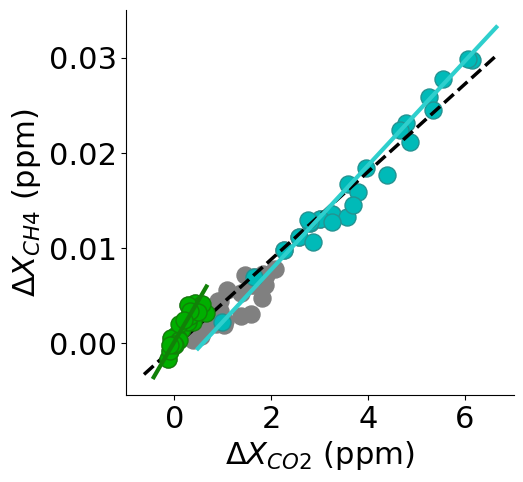

In [51]:
savefig = global_savefig
showfig = global_showfig

fig_id = f'rolling_example_combined_{regr_label}_{date_str}' #Set the figure id

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

labsize = 22
marker_size = 150
linewidth = 3
# Plot points that never pass the filter
ax.scatter(nopass_filter_df[x_name], nopass_filter_df[y_name], c='grey',s=marker_size,zorder = 0)

# Plot chunks of combined points in alternating colors
ax.scatter(split_dfs[0][x_name], split_dfs[0][y_name], c='#00bab8', s=marker_size,edgecolors = '#239392',zorder=4)
ax.scatter(split_dfs[1][x_name], split_dfs[1][y_name], c='#00af00', s=marker_size,edgecolors = '#118108',zorder = 8)

slope = pass_filter_dfs[0]['ch4_co2_york_slope'].mean()
intercept = pass_filter_dfs[0]['ch4_co2_york_intercept'].mean()
print(slope,'0')
print(pass_filter_dfs[0]['ch4_co2_york_slope'].std(),'0')
x_min, x_max = split_dfs[0][x_name].min()-0.5, split_dfs[0][x_name].max()+0.5
y_min, y_max = split_dfs[0][y_name].min(), split_dfs[0][y_name].max()
xline = np.linspace(x_min, x_max, 100)
yline = slope * xline + intercept
ax.plot(xline, yline, c='#2ecfcd', linewidth=linewidth, linestyle='-', zorder=5)

slope = pass_filter_dfs[1]['ch4_co2_york_slope'].mean()
intercept = pass_filter_dfs[1]['ch4_co2_york_intercept'].mean()
print(slope,'1')
print(pass_filter_dfs[1]['ch4_co2_york_slope'].std(),'1')
x_min, x_max = split_dfs[1][x_name].min()-0.3, split_dfs[1][x_name].max()
y_min, y_max = split_dfs[1][y_name].min(), split_dfs[1][y_name].max()
xline = np.linspace(x_min, x_max, 100)
yline = slope * xline + intercept
ax.plot(xline, yline, c='#118108', linewidth=linewidth, linestyle='-', zorder=10)

slope = fullday_out['slope']
intercept = fullday_out['intercept']
print(slope,'full')
x_min, x_max = rolling_regr_df[x_name].min()-0.5, rolling_regr_df[x_name].max()+0.5
y_min, y_max = rolling_regr_df[y_name].min(), rolling_regr_df[y_name].max()
print(fullday_out['r_squared'])
xline = np.linspace(x_min, x_max, 100)
yline = slope * xline + intercept
ax.plot(xline, yline, c='black', linewidth=linewidth/1.2, linestyle='--', zorder=4)

ax.set_xlabel(quantile_regr_plot_dict['ch4_co2']['x_label'], size=labsize)
ax.set_ylabel(quantile_regr_plot_dict['ch4_co2']['y_label'], size=labsize)
ax.tick_params(labelsize=labsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

aspect = (ax.get_xlim()[1] - ax.get_xlim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0])

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=200,bbox_inches = "tight")
if showfig:
    plt.show()
else:
    plt.close()

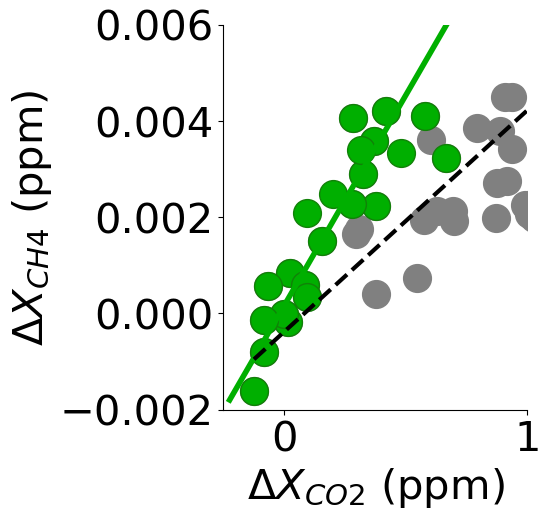

In [52]:
savefig = global_savefig
showfig = global_showfig

fig_id = f'rolling_example_combined_zoomed_{regr_label}_{date_str}' #

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

labsize = 30
marker_size = 400

# Plot chunks of combined points in alternating colors
#ax.scatter(split_dfs[0][x_name], split_dfs[0][y_name], c='#00bab8', s=marker_size,edgecolors = '#239392')
ax.scatter(split_dfs[1][x_name], split_dfs[1][y_name], c='#00af00', s=marker_size,edgecolors = '#118108')
ax.scatter(nopass_filter_df[x_name], nopass_filter_df[y_name], c='grey',s=marker_size,zorder = 0)

slope = pass_filter_dfs[1]['ch4_co2_york_slope'].mean()
intercept = pass_filter_dfs[1]['ch4_co2_york_intercept'].mean()
x_min, x_max = split_dfs[1][x_name].min()-.1, split_dfs[1][x_name].max()
y_min, y_max = split_dfs[1][y_name].min(), split_dfs[1][y_name].max()
xline = np.linspace(x_min, x_max, 100)
yline = slope * xline + intercept
ax.plot(xline, yline, c='#00af00', linewidth=4, linestyle='-', zorder=3)

slope = fullday_out['slope']
intercept = fullday_out['intercept']
x_min, x_max = rolling_regr_df[x_name].min(), rolling_regr_df[x_name].max()
y_min, y_max = rolling_regr_df[y_name].min(), rolling_regr_df[y_name].max()
xline = np.linspace(x_min, x_max, 100)
yline = slope * xline + intercept
ax.plot(xline, yline, c='black', linewidth=3, linestyle='--', zorder=3)


ax.set_xlabel(quantile_regr_plot_dict['ch4_co2']['x_label'], size=labsize)
ax.set_ylabel(quantile_regr_plot_dict['ch4_co2']['y_label'], size=labsize)
ax.tick_params(labelsize=labsize)

#ax.ticklabel_format(style='sci',axis = 'y',scilimits=(0,0),useMathText=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(-0.25,1)
ax.set_ylim(-0.002,0.006)
ax.set_aspect(aspect)

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=200,bbox_inches = "tight")
if showfig:
    plt.show()
else:
    plt.close()

## Multi-Year Ratios

## Quantile (Excess, Figure 5)

In [53]:
#Create the plot df (filter out bad data)
print(len(all_quantile_df))
quantile_plot_df = all_quantile_df.copy()
quantile_plot_df = quantile_plot_df.dropna()
print(len(quantile_plot_df))

23579
22009


In [54]:
#Compute regressions
full_quantile_regression_outputs = {}
err_tags = ['wstd_divak']

x_name = f'xco2(ppm)_wmean_ex{q}q_divak'
y_name = f'xch4(ppm)_wmean_ex{q}q_divak'
full_quantile_regression_outputs['ch4_co2'] = regression_utils.calculate_all_regressions(quantile_plot_df,x_name,y_name,err_tags)

x_name = f'xco2(ppm)_wmean_ex{q}q_divak'
y_name = f'xco(ppm)_wmean_ex{q}q_divak'
full_quantile_regression_outputs['co_co2'] = regression_utils.calculate_all_regressions(quantile_plot_df,x_name,y_name,err_tags)

### CH4:CO2

{'slope': 0.008951359700387086, 'intercept': -0.0013249832691186476, 'r': 0.46747656271803006, 'r_squared': 0.2185343366906643, 'R_squared': -0.41460043114811995, 'S': 21306.402409035312, 'cov': array([[ 6.19328623e-09, -3.88636359e-09],
       [-3.88636359e-09,  3.68523958e-09]]), 'se_slope': 7.869743470712981e-05, 'se_intercept': 6.070617411253421e-05}


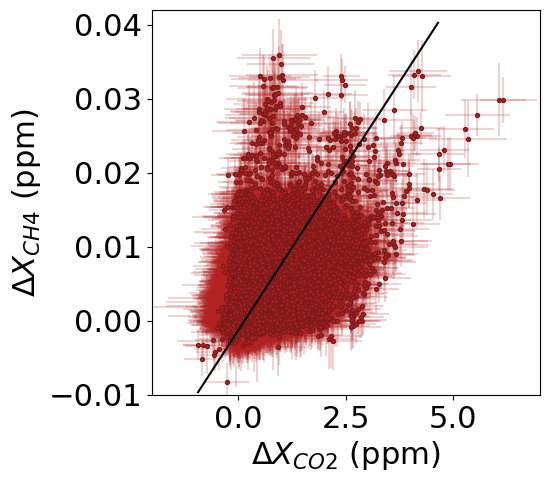

In [55]:
regr_label = 'ch4_co2'
regr_type = 'york'
err_tag = 'wstd_divak'
annotate = False

fig_id = f'quantile_fullyear_{regr_label}' #Set the figure id
if annotate:
    fig_id = f'{fig_id}_ann'

x_name = full_quantile_regression_outputs[regr_label][err_tag]['details']['x_name']
y_name = full_quantile_regression_outputs[regr_label][err_tag]['details']['y_name']
x_err_name = full_quantile_regression_outputs[regr_label][err_tag]['details']['x_err_name']
y_err_name = full_quantile_regression_outputs[regr_label][err_tag]['details']['y_err_name']
regression_output = full_quantile_regression_outputs[regr_label][err_tag][regr_type]
print(regression_output)

# Initialize the plotter
plotter = plot_utils.RegressionPlotter(figures_path=inst_figures_path,regr_plot_dict=quantile_regr_plot_dict)
plotter.update_plot_style('ch4_co2', scatter_style= {"s": 8,'edgecolors':'#7e1b1a'},annotate = annotate)

# Plot using the 'co_co2' label
fig = plotter.plot(
    quantile_plot_df, x_name, y_name, x_err_name, y_err_name,
    regression_output=regression_output,
    fig_id=fig_id,
    regr_label=regr_label,  
    savefig=global_savefig,
    showfig=global_showfig,
    ylim = [-0.01,0.042],
    xlim = [-2,7],
    legend_style = {'loc':'upper left','frameon':False},
)

### Regression type comparison (Figure S11)

In [56]:
regr_label = 'ch4_co2'
err_tag = 'wstd_divak'
fig_id = f'quantile_fullyear_{regr_label}_regrcomparison' #Set the figure id

x_name = full_quantile_regression_outputs[regr_label][err_tag]['details']['x_name']
y_name = full_quantile_regression_outputs[regr_label][err_tag]['details']['y_name']
x_err_name = full_quantile_regression_outputs[regr_label][err_tag]['details']['x_err_name']
y_err_name = full_quantile_regression_outputs[regr_label][err_tag]['details']['y_err_name']

df  = quantile_plot_df.copy()

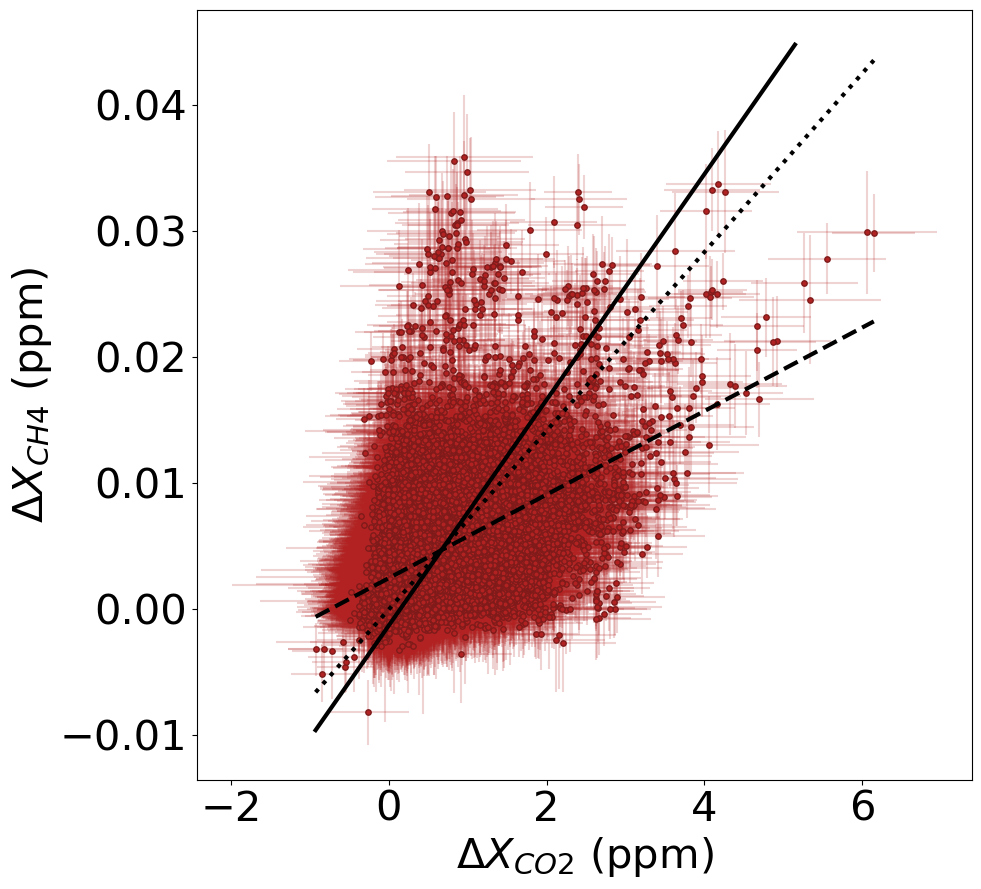

In [57]:
savefig = global_savefig
showfig = global_showfig
fig_id = f'quantile_fullyear_{regr_label}_regrcomparison' #Set the figure id

fig, ax = plt.subplots(1, 1, figsize=(10,10))
labsize = 30

x_min, x_max = df[x_name].min(), df[x_name].max()
y_min, y_max = df[y_name].min(), df[y_name].max()

ax.errorbar(df[x_name], df[y_name], xerr=df[x_err_name], yerr=df[y_err_name], c='firebrick', markersize=0, zorder=1, linestyle='none',alpha=0.2)
ax.scatter(df[x_name], df[y_name], s=15, c='firebrick', zorder=2,edgecolors ='#7e1b1a')

outs = full_quantile_regression_outputs[regr_label][err_tag]['york']
slope = outs['slope']
intercept = outs['intercept']
xline = np.linspace(x_min, x_max-1, 100)
yline = slope * xline + intercept
ax.plot(xline, yline, c='k', linewidth=3, linestyle='-', zorder=3,label = 'York')

outs = full_quantile_regression_outputs[regr_label][err_tag]['ols']
slope = outs['slope']
intercept = outs['intercept']
xline = np.linspace(x_min, x_max, 100)
yline = slope * xline + intercept
ax.plot(xline, yline, c='k', linewidth=3, linestyle='--', zorder=3,label = 'OLS')

outs = full_quantile_regression_outputs[regr_label][err_tag]['rma']
slope = outs['slope']
intercept = outs['intercept']
xline = np.linspace(x_min, x_max, 100)
yline = slope * xline + intercept
ax.plot(xline, yline, c='k', linewidth=3, linestyle='dotted', zorder=3,label = 'RMA')

ax.set_xlabel(r'${\Delta}X_{CO2}$' + ' (ppm)', size=labsize)
ax.set_ylabel(r'${\Delta}X_{CH4}$' + ' (ppm)', size=labsize)
ax.tick_params(labelsize=labsize)

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(inst_figures_path,fig_name),dpi=500,bbox_inches = "tight")
if showfig:
    plt.show()
else:
    plt.close()


### CO:CO2 (Figure 5)

{'slope': 0.014767186187258589, 'intercept': -0.003215421908558112, 'r': 0.5423570473281728, 'r_squared': 0.29415116678653386, 'R_squared': -1.0284656523399502, 'S': 22300.45671606413, 'cov': array([[ 1.89578293e-08, -1.18763308e-08],
       [-1.18763308e-08,  9.96689230e-09]]), 'se_slope': 0.00013768743321728694, 'se_intercept': 9.983432427096442e-05}


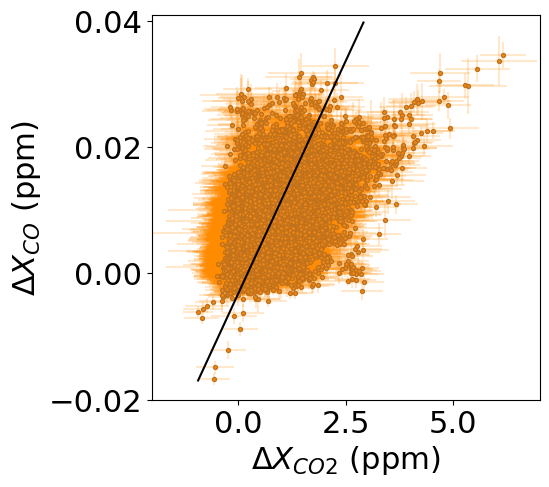

In [58]:
regr_label = 'co_co2'
regr_type = 'york'
err_tag = 'wstd_divak'
annotate = False

fig_id = f'quantile_fullyear_{regr_label}' #Set the figure id
if annotate:
    fig_id = f'{fig_id}_ann'

x_name = full_quantile_regression_outputs[regr_label][err_tag]['details']['x_name']
y_name = full_quantile_regression_outputs[regr_label][err_tag]['details']['y_name']
x_err_name = full_quantile_regression_outputs[regr_label][err_tag]['details']['x_err_name']
y_err_name = full_quantile_regression_outputs[regr_label][err_tag]['details']['y_err_name']
regression_output = full_quantile_regression_outputs[regr_label][err_tag][regr_type]
print(regression_output)

# Initialize the plotter
plotter = plot_utils.RegressionPlotter(figures_path=inst_figures_path,regr_plot_dict=quantile_regr_plot_dict)
plotter.update_plot_style('co_co2', scatter_style= {"s": 8,'edgecolors':'#c1721b'},annotate=annotate)

# Plot using the 'co_co2' label
fig = plotter.plot(
    quantile_plot_df, x_name, y_name, x_err_name, y_err_name,
    regression_output=regression_output,
    fig_id=fig_id,
    regr_label=regr_label,  
    savefig=global_savefig,
    showfig=global_showfig,
    ylim = [-0.02,0.041],
    xlim = [-2,7],
    legend_style = {'loc':'lower right','frameon':False},
    line_xlim = [-1,3]
    
)

## Anomaly (Figure 5)

In [59]:
#Create the plot df (filter out bad data)
print(len(all_anom_df))
anom_plot_df = all_anom_df.copy()
anom_plot_df = anom_plot_df.loc[anom_plot_df['co2_above_thresh']==True]
print(len(anom_plot_df))

9292
8369


In [60]:
#Compute regressions
anom_regression_outputs = {}
anom_err_tags = ['std_divak']

x_name = f'xco2(ppm)_anom_divak'
y_name = f'xch4(ppm)_anom_divak'
anom_regression_outputs['ch4_co2'] = regression_utils.calculate_all_regressions(anom_plot_df,x_name,y_name,anom_err_tags)

x_name = f'xco2(ppm)_anom_divak'
y_name = f'xco(ppm)_anom_divak'
anom_regression_outputs['co_co2'] = regression_utils.calculate_all_regressions(anom_plot_df,x_name,y_name,anom_err_tags)

### CH4:CO2

{'slope': 0.010250811550874355, 'intercept': 0.00382160121869641, 'r': 0.4536321233178534, 'r_squared': 0.20578210330586416, 'R_squared': -0.5886437053919604, 'S': 19086.736055446865, 'cov': array([[1.00052762e-08, 1.66422988e-09],
       [1.66422988e-09, 4.49096787e-09]]), 'se_slope': 0.00010002637733259011, 'se_intercept': 6.701468398510795e-05}


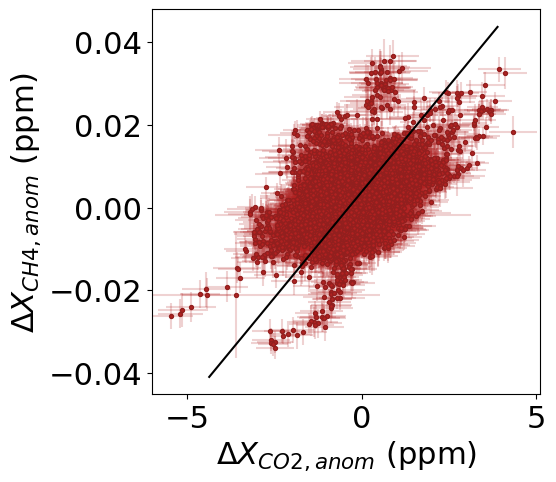

In [61]:
regr_label = 'ch4_co2'
regr_type = 'york'
err_tag = 'std_divak'
annotate = False

fig_id = f'anom_fullyear_{regr_label}' #Set the figure id
if annotate:
    fig_id = f'{fig_id}_ann'

x_name = anom_regression_outputs[regr_label][err_tag]['details']['x_name']
y_name = anom_regression_outputs[regr_label][err_tag]['details']['y_name']
x_err_name = anom_regression_outputs[regr_label][err_tag]['details']['x_err_name']
y_err_name = anom_regression_outputs[regr_label][err_tag]['details']['y_err_name']
regression_output = anom_regression_outputs[regr_label][err_tag][regr_type]
print(regression_output)
# Initialize the plotter
plotter = plot_utils.RegressionPlotter(figures_path=inst_figures_path,regr_plot_dict=anom_regr_plot_dict)
plotter.update_plot_style('ch4_co2', scatter_style= {"s": 8,'edgecolors':'#921f1e','linewidth':1},annotate = annotate)

fig = plotter.plot(
    anom_plot_df, x_name, y_name, x_err_name, y_err_name,
    regression_output=regression_output,
    fig_id=fig_id,
    regr_label=regr_label,  
    savefig=global_savefig,
    showfig=global_showfig,
    legend_style = {'loc':'upper left','frameon':False},
    line_xlim = [-4,4.2],
    xlim = [-6,5.1]
)

### CO:CO2 (Figure 5)

{'slope': 0.012770897560471955, 'intercept': 0.0017258432774291143, 'r': 0.5797815876069237, 'r_squared': 0.3361466893280049, 'R_squared': -0.6879445491097282, 'S': 17821.604572225922, 'cov': array([[1.50218807e-08, 2.47555026e-09],
       [2.47555026e-09, 5.69875846e-09]]), 'se_slope': 0.00012256378215320647, 'se_intercept': 7.549012159352145e-05}


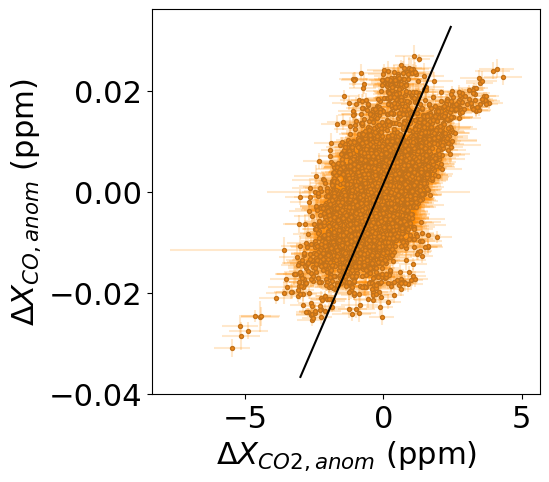

In [62]:
regr_label = 'co_co2'
regr_type = 'york'
err_tag = 'std_divak'
annotate = False

fig_id = f'anom_fullyear_{regr_label}' #Set the figure id
if annotate:
    fig_id = f'{fig_id}_ann'

x_name = anom_regression_outputs[regr_label][err_tag]['details']['x_name']
y_name = anom_regression_outputs[regr_label][err_tag]['details']['y_name']
x_err_name = anom_regression_outputs[regr_label][err_tag]['details']['x_err_name']
y_err_name = anom_regression_outputs[regr_label][err_tag]['details']['y_err_name']
regression_output = anom_regression_outputs[regr_label][err_tag][regr_type]
print(regression_output)
# Initialize the plotter
plotter = plot_utils.RegressionPlotter(figures_path=inst_figures_path,regr_plot_dict=anom_regr_plot_dict)
plotter.update_plot_style('co_co2', scatter_style= {"s": 8,'edgecolors':'#c1721b'},annotate=annotate)

fig = plotter.plot(
    anom_plot_df, x_name, y_name, x_err_name, y_err_name,
    regression_output=regression_output,
    fig_id=fig_id,
    regr_label=regr_label,  
    savefig=global_savefig,
    showfig=global_showfig,
    legend_style = {'loc':'upper left','frameon':False},
    line_xlim = [-3,2.5],
    # xlim = [-6,5.1]
)

## Rolling (Figure 5) 

### CH4:CO2

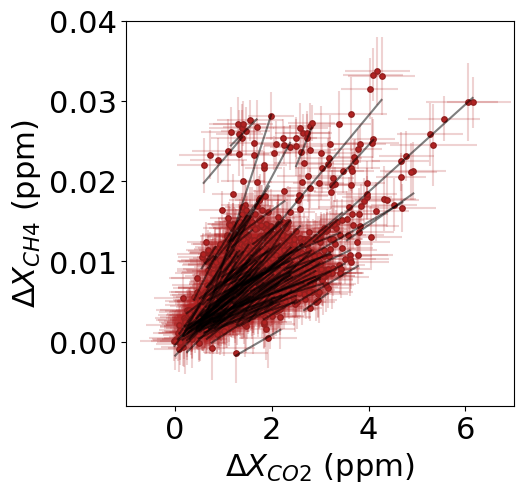

ch4_co2_york_slope  ch4_co2_york_intercept  ch4_co2_york_r  \
count         1609.000000             1609.000000     1609.000000   
mean             0.005032               -0.000123        0.942281   
std              0.002483                0.003201        0.026639   
min              0.001619               -0.017747        0.894676   
25%              0.003394               -0.001239        0.919415   
50%              0.004456               -0.000129        0.943178   
75%              0.005956                0.001083        0.963438   
max              0.020438                0.018127        0.997425   

       ch4_co2_york_r_squared  ch4_co2_york_R_squared  ch4_co2_york_S  \
count             1609.000000             1609.000000     1609.000000   
mean                 0.888603                0.883997        0.590533   
std                  0.050214                0.053916        0.515153   
min                  0.800445                0.720556        0.065640   
25%                  0.845324                0.838721        0.284626   
50%                  0.889584                0.886299        0.414955   
75%                  0.928212                0.926386        0.690047   
max                  0.994856                0.994802        4.517686   

       ch4_co2_york_se_slope  
count            1609.000000  
mean                0.002532  
std                 0.001498  
min                 0.000551  
25%                 0.001450  
50%                 0.002148  
75%                 0.003205  
max                 0.009231

In [63]:
regr_label = 'ch4_co2'
regr_type = 'york'
err_tag = 'wstd_divak'
fig_id = f'rolling_fullyear_{regr_label}' #Set the figure id

plot_df = all_rolling_regr_df_filtered.copy()

good_rolling_grouped_df = plot_df.loc[plot_df[f'{regr_label}_good_group'].notnull()]

# Initialize the plotter
plotter = plot_utils.RollingRegressionPlotter(figures_path=inst_figures_path, rolling_regr_plot_dict=rolling_regr_plot_dict)

# Plot the rolling regression results
fig = plotter.plot(
    good_rolling_grouped_df,
    regr_label,
    regr_type,
    rolling_regr_params['regr_labels'][regr_label]['x_name'],
    rolling_regr_params['regr_labels'][regr_label]['y_name'],
    rolling_regr_params['regr_labels'][regr_label]['x_err_name'],
    rolling_regr_params['regr_labels'][regr_label]['y_err_name'],
    fig_id=fig_id,
    savefig=global_savefig,
    showfig=global_showfig,
    ylim = [-0.008,0.04],
    xlim = [-1,7],
    weighted=False
)

regex = f"(?=.*{regr_type})(?=.*{regr_label})"
good_rolling_grouped_df.filter(regex=regex).describe()


# group_col = f"{regr_label}_good_group"
# good_rolling_grouped_df.groupby(group_col).mean().describe()

In [64]:
df_good = good_rolling_grouped_df.copy()
weights = 1/(df_good[f'{regr_label}_{regr_type}_se_slope']**2)
weighted_mean_slope = np.sum(df_good[f'{regr_label}_{regr_type}_slope'] * weights) / np.sum(weights)
weighted_std_slope = np.sqrt(np.sum(weights * (df_good[f'{regr_label}_{regr_type}_slope'] - weighted_mean_slope)**2) / np.sum(weights))
print(f"Weighted Mean Slope: {weighted_mean_slope:.6f}")
print(f"Std Dev of Slopes: {df_good[f'{regr_label}_{regr_type}_slope'].std():.6f}")

Weighted Mean Slope: 0.003761
Std Dev of Slopes: 0.002483


### CO:CO2 (Figure 5)

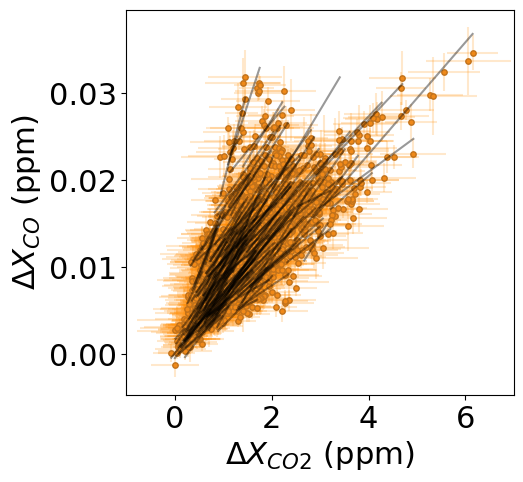

co_co2_york_slope  co_co2_york_intercept  co_co2_york_r  \
count        1682.000000            1682.000000    1682.000000   
mean            0.007540               0.001438       0.946817   
std             0.002753               0.003948       0.027181   
min             0.002191              -0.014710       0.894441   
25%             0.005871              -0.000500       0.924845   
50%             0.007089               0.000883       0.947329   
75%             0.008528               0.003841       0.969837   
max             0.026442               0.013808       0.997241   

       co_co2_york_r_squared  co_co2_york_R_squared  co_co2_york_S  \
count            1682.000000            1682.000000    1682.000000   
mean                0.897201               0.884329       1.136008   
std                 0.051414               0.062443       0.872841   
min                 0.800024               0.689502       0.105126   
25%                 0.855338               0.835713       0.554675   
50%                 0.897433               0.887554       0.854936   
75%                 0.940584               0.937142       1.426525   
max                 0.994489               0.994467       8.015375   

       co_co2_york_se_slope  
count           1682.000000  
mean               0.002792  
std                0.001939  
min                0.000506  
25%                0.001447  
50%                0.002246  
75%                0.003635  
max                0.016497

In [65]:
regr_label = 'co_co2'
regr_type = 'york'
err_tag = 'wstd_divak'
fig_id = f'rolling_fullyear_{regr_label}' #Set the figure id

good_rolling_grouped_df = all_rolling_regr_df_filtered.loc[all_rolling_regr_df_filtered[f'{regr_label}_good_group'].notnull()]

# Initialize the plotter
plotter = plot_utils.RollingRegressionPlotter(figures_path=inst_figures_path, rolling_regr_plot_dict=rolling_regr_plot_dict)

# Plot the rolling regression results
fig = plotter.plot(
    all_rolling_regr_df_filtered,
    regr_label,
    regr_type,
    rolling_regr_params['regr_labels'][regr_label]['x_name'],
    rolling_regr_params['regr_labels'][regr_label]['y_name'],
    rolling_regr_params['regr_labels'][regr_label]['x_err_name'],
    rolling_regr_params['regr_labels'][regr_label]['y_err_name'],
    fig_id=fig_id,
    savefig=global_savefig,
    showfig=global_showfig,
    xlim=[-1,7],
    #ylim=[-0.008,0.049]
)


regex = f"(?=.*{regr_type})(?=.*{regr_label})"
good_rolling_grouped_df.filter(regex=regex).describe()

# group_col = f"{regr_label}_good_group"
# good_rolling_grouped_df.groupby(group_col).mean().filter(regex=regex).describe()

In [66]:
df_good = good_rolling_grouped_df.copy()
weights = 1/(df_good[f'{regr_label}_{regr_type}_se_slope']**2)
weighted_mean_slope = np.sum(df_good[f'{regr_label}_{regr_type}_slope'] * weights) / np.sum(weights)
weighted_std_slope = np.sqrt(np.sum(weights * (df_good[f'{regr_label}_{regr_type}_slope'] - weighted_mean_slope)**2) / np.sum(weights))
print(f"Weighted Mean Slope: {weighted_mean_slope:.6f}")
print(f"Std Dev of Slopes: {df_good[f'{regr_label}_{regr_type}_slope'].std():.6f}")

Weighted Mean Slope: 0.005833
Std Dev of Slopes: 0.002753


## Seasonal Ratios (Figures 6, 7, S8, S9, S10)

In [67]:
season_keys = ['DJF','MAM','JJA','SON']
inst_season_figures_path = os.path.join(inst_figures_path,'seasonal')
os.makedirs(inst_season_figures_path,exist_ok=True)

In [68]:
# Setup Quantile Dict
#Create the plot df (filter out bad data)
quantile_plot_df = all_quantile_df.copy()
quantile_plot_df = quantile_plot_df.dropna()

season_quantile_plot_dfs = {}
for season in season_keys:
    season_quantile_plot_dfs[season] = df_utils.get_season_df(quantile_plot_df,season,date_col=None)

#Compute regressions
all_season_quantile_regression_outputs = {}
err_tags = ['wstd_divak']
for season, season_quantile_plot_df in season_quantile_plot_dfs.items():
    regression_outputs = {}

    x_name = f'xco2(ppm)_wmean_ex{q}q_divak'
    y_name = f'xch4(ppm)_wmean_ex{q}q_divak'
    regression_outputs['ch4_co2'] = regression_utils.calculate_all_regressions(season_quantile_plot_df,x_name,y_name,err_tags)

    x_name = f'xco2(ppm)_wmean_ex{q}q_divak'
    y_name = f'xco(ppm)_wmean_ex{q}q_divak'
    regression_outputs['co_co2'] = regression_utils.calculate_all_regressions(season_quantile_plot_df,x_name,y_name,err_tags)
    all_season_quantile_regression_outputs[season] = regression_outputs   

In [69]:
# Setup Anomaly Dict
#Create the plot df 
anom_plot_df = all_anom_df.copy()
season_anom_plot_dfs = {}
for season in season_keys:
    season_anom_plot_dfs[season] = df_utils.get_season_df(anom_plot_df,season,date_col='date')

#Compute regressions
all_season_anom_regression_outputs = {}
err_tags = ['std_divak']
for season, season_anom_plot_df in season_anom_plot_dfs.items():
    regression_outputs = {}

    x_name = f'xco2(ppm)_anom_divak'
    y_name = f'xch4(ppm)_anom_divak'
    regression_outputs['ch4_co2'] = regression_utils.calculate_all_regressions(season_anom_plot_df,x_name,y_name,err_tags)

    x_name = f'xco2(ppm)_anom_divak'
    y_name = f'xco(ppm)_anom_divak'
    regression_outputs['co_co2'] = regression_utils.calculate_all_regressions(season_anom_plot_df,x_name,y_name,err_tags)
    all_season_anom_regression_outputs[season] = regression_outputs

In [70]:
#Create the plot df 
season_rolling_plot_dfs = {}
for season in season_keys:
    season_rolling_plot_dfs[season] = df_utils.get_season_df(all_rolling_regr_df_filtered,season,date_col=None)

### Get all plots and means (Figure S8)

In [71]:
regr_type = 'york'
savefig = global_savefig
showfig = False
annotate = True
seasonal_rolling_regr_details = {}
for season in season_keys:
    if annotate:
        title = season
    else:
        title = None#season
    seasonal_rolling_regr_details[season] = {}
    for regr_label in ['co_co2','ch4_co2']:
        # if regr_label == 'ch4_co2':
        #     continue
        # if season not in ['JJA','DJF']:
        #     continue
        err_tag = 'wstd_divak'
        season_quantile_plot_df = season_quantile_plot_dfs[season]
        season_quantile_regression_outputs = all_season_quantile_regression_outputs[season]
        fig_id = f'quantile_{season}_{regr_label}' #Set the figure id
        plotter = plot_utils.RegressionPlotter(figures_path=inst_season_figures_path,regr_plot_dict=quantile_regr_plot_dict)
        plotter.update_plot_style(regr_label, annotate = annotate)
        plot_utils.bulk_regression_plotter(
            plotter,
            season_quantile_plot_df,
            season_quantile_regression_outputs,
            regr_label,
            err_tag,
            regr_type,
            fig_id,
            savefig=savefig,
            showfig=showfig,
            annotate=annotate,
            legend_style = {'loc':'upper left','frameon':False},
            title = title
            # plot_kwargs = {
            #     'line_xlim':[0,2]
            # }
        )

        err_tag = 'std_divak'
        season_anom_plot_df = season_anom_plot_dfs[season]
        season_anom_regression_outputs = all_season_anom_regression_outputs[season]
        fig_id = f'anom_{season}_{regr_label}' #Set the figure id
        plotter = plot_utils.RegressionPlotter(figures_path=inst_season_figures_path,regr_plot_dict=anom_regr_plot_dict)
        plotter.update_plot_style(regr_label, annotate = annotate)
        plot_utils.bulk_regression_plotter(
            plotter,
            season_anom_plot_df,
            season_anom_regression_outputs,
            regr_label,
            err_tag,
            regr_type,
            fig_id,
            savefig=savefig,
            showfig=showfig,
            annotate=annotate,
            legend_style = {'loc':'upper left','frameon':False},
            # plot_kwargs = {
            #     'line_xlim':[0,2]
            # },
            title = title
        )

        err_tag = 'wstd_divak'
        fig_id = f'rolling_{season}_{regr_label}' #Set the figure id
        season_rolling_plot_df = season_rolling_plot_dfs[season]
        good_rolling_grouped_df = season_rolling_plot_df.loc[season_rolling_plot_df[f'{regr_label}_good_group'].notnull()]
        # Initialize the plotter
        plotter = plot_utils.RollingRegressionPlotter(figures_path=inst_season_figures_path, rolling_regr_plot_dict=rolling_regr_plot_dict)
        # Plot the rolling regression results
        fig = plotter.plot(
            good_rolling_grouped_df,
            regr_label,
            regr_type,
            rolling_regr_params['regr_labels'][regr_label]['x_name'],
            rolling_regr_params['regr_labels'][regr_label]['y_name'],
            rolling_regr_params['regr_labels'][regr_label]['x_err_name'],
            rolling_regr_params['regr_labels'][regr_label]['y_err_name'],
            fig_id=fig_id,
            savefig=savefig,
            showfig=showfig,
            title = title,
            # xlim=[-1,6.7],
            # ylim=[-0.006,0.039]
        )
        print(season)
        print(regr_label)
        #print(good_rolling_grouped_df.filter(regex=f"(?=.*{regr_type})(?=.*{regr_label})").describe())

        df_good = good_rolling_grouped_df.copy()
        weights = 1/(df_good[f'{regr_label}_{regr_type}_se_slope']**2)
        weighted_mean_slope = np.sum(df_good[f'{regr_label}_{regr_type}_slope'] * weights) / np.sum(weights)
        weighted_std_slope = np.sqrt(np.sum(weights * (df_good[f'{regr_label}_{regr_type}_slope'] - weighted_mean_slope)**2) / np.sum(weights))
        print(f"Weighted Mean Slope: {weighted_mean_slope:.6f}")
        #print(f'Mean of slope: {df_good[f"{regr_label}_{regr_type}_slope"].mean():.6f}')
        #print(f"Weighted Std Dev of Slope: {weighted_std_slope:.6f}")
        print(f'Std of slope: {df_good[f"{regr_label}_{regr_type}_slope"].std():.6f}')


        seasonal_rolling_regr_details[season][regr_label] = {
            'mean': df_good[f'{regr_label}_{regr_type}_slope'].mean(),
            'std': df_good[f'{regr_label}_{regr_type}_slope'].std(),
            'weighted_mean': weighted_mean_slope,
            'weighted_std': weighted_std_slope
        }
        #seasonal_rolling_regr_details[season][regr_label] = good_rolling_grouped_df.filter(regex=f"(?=.*{regr_type})(?=.*{regr_label})").describe()

DJF
co_co2
Weighted Mean Slope: 0.005585
Std of slope: 0.001771
DJF
ch4_co2
Weighted Mean Slope: 0.004167
Std of slope: 0.002002
MAM
co_co2
Weighted Mean Slope: 0.006733
Std of slope: 0.003042
MAM
ch4_co2
Weighted Mean Slope: 0.004995
Std of slope: 0.001809
JJA
co_co2
Weighted Mean Slope: 0.006254
Std of slope: 0.003582
JJA
ch4_co2
Weighted Mean Slope: 0.003535
Std of slope: 0.002215
SON
co_co2
Weighted Mean Slope: 0.005845
Std of slope: 0.002460
SON
ch4_co2
Weighted Mean Slope: 0.003305
Std of slope: 0.003158


### Timeseries (Figures 6, S9, S10)

In [72]:
#These values are taken from the inventories.ipynb notebook

grapes_season_ratios = {'DJF': {'ch4_co2': 0.003384561848008199, 'co_co2': 0.005506621140658146},
 'MAM': {'ch4_co2': 0.00395303588458636, 'co_co2': 0.006105654891904166},
 'JJA': {'ch4_co2': 0.004570129302373407, 'co_co2': 0.0066724028957525095},
 'SON': {'ch4_co2': 0.004077867962175399, 'co_co2': 0.006235658154424308}}

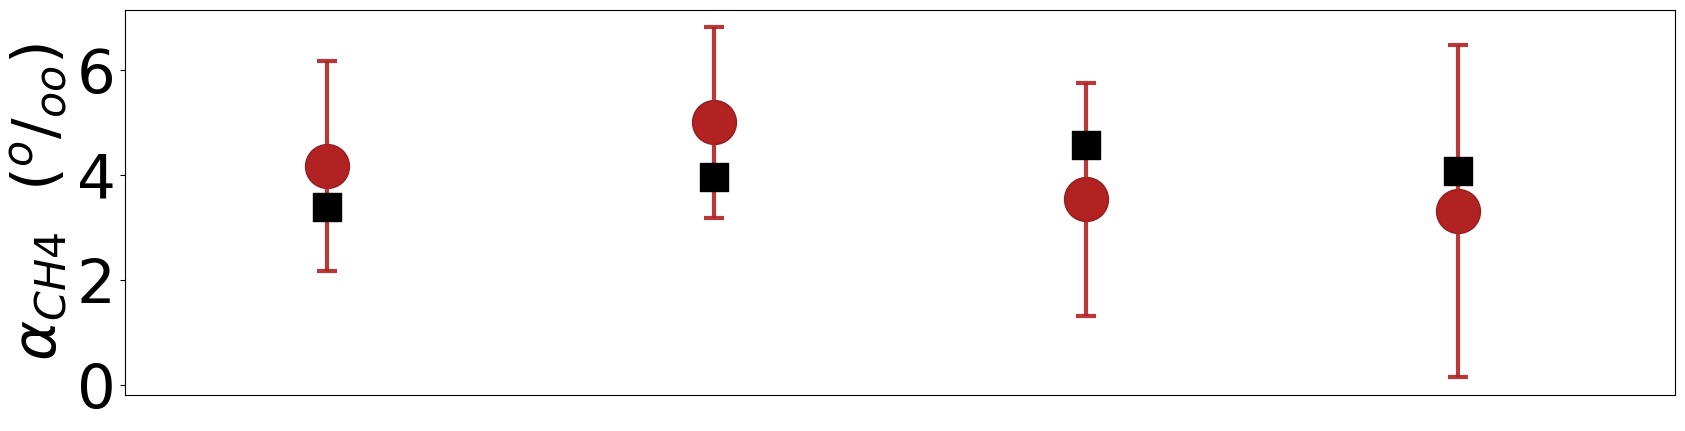

In [73]:
regr_label = 'ch4_co2'
regr_type = 'york'
season_positions = {
    'DJF': 1.3,
    'MAM': 3.8,
    'JJA': 6.2,
    'SON': 8.6
}
xlims = [0, 10]
fig_id = f'season_{regr_label}_ts' #Set the figure id
plotter = plot_utils.RegressionPlotter(figures_path=inst_season_figures_path, regr_plot_dict=seasonal_regr_plot_dict)
plotter.figsize = (20,5)
plotter.labsize = 44
plotter.plot_seasonal_details(
    seasonal_rolling_regr_details,
    regr_label,
    regr_type, 
    savefig=global_savefig, 
    showfig=global_showfig,
    fig_id = fig_id,
    #ylims = [2,11],
    y_ticks = [0,2,4,6],
    grapes_season_ratios = grapes_season_ratios,
    remove_x_ticks = True,
    season_positions = season_positions,
    xlims = xlims,
    mean_col = 'weighted_mean')

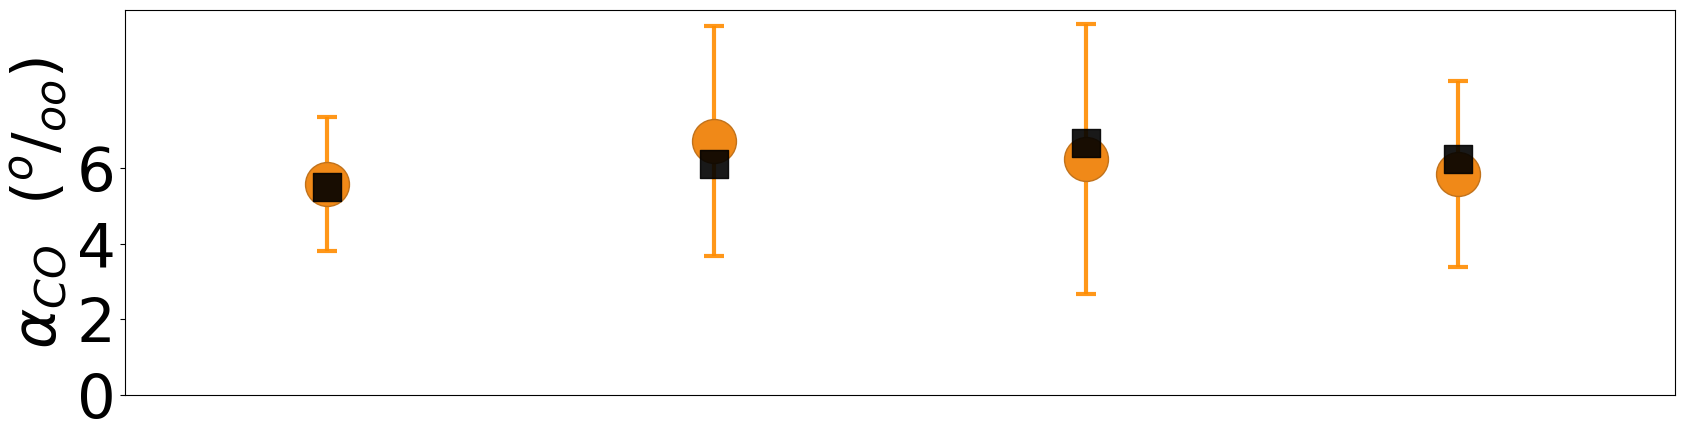

In [74]:
regr_label = 'co_co2'
regr_type = 'york'
season_positions = {
    'DJF': 1.3,
    'MAM': 3.8,
    'JJA': 6.2,
    'SON': 8.6
}
xlims = [0, 10]
fig_id = f'season_{regr_label}_ts' #Set the figure id
plotter = plot_utils.RegressionPlotter(figures_path=inst_season_figures_path, regr_plot_dict=seasonal_regr_plot_dict)
plotter.figsize = (20,5)
plotter.labsize = 44
plotter.plot_seasonal_details(
    seasonal_rolling_regr_details,
    regr_label,
    regr_type, 
    savefig=global_savefig, 
    showfig=global_showfig,
    fig_id = fig_id,
    #ylims = [2,11],
    y_ticks = [0,2,4,6],
    grapes_season_ratios = grapes_season_ratios,
    remove_x_ticks = True,
    season_positions = season_positions,
    xlims = xlims,
    mean_col = 'weighted_mean')